In [208]:
import logging
import os
import gc
import time
from datetime import datetime as dt

import numpy as np
import pandas as pd
from pandas.core.common import SettingWithCopyWarning

import warnings
warnings.simplefilter(action='ignore', category=SettingWithCopyWarning)
warnings.simplefilter(action='ignore', category=FutureWarning)

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold, StratifiedKFold

import lightgbm as lgb
import xgboost as xgb

import matplotlib.pyplot as plt
import seaborn as sns

from contextlib import contextmanager

logger = logging.getLogger(__name__)
logging.basicConfig(
    format='[%(levelname)s] %(asctime)s %(filename)s: %(lineno)d: %(message)s',
    datefmt='%Y-%m-%d:%H:%M:%S',
    level=logging.DEBUG)

DATE_TODAY = dt(2019, 1, 26)

FEATS_EXCLUDED = [
    'first_active_month', 'target', 'card_id', 'outliers',
    'hist_purchase_date_max', 'hist_purchase_date_min', 'hist_card_id_size',
    'new_purchase_date_max', 'new_purchase_date_min', 'new_card_id_size',
    'OOF_PRED', 'month_0']


@contextmanager
def timer(title):
    t0 = time.time()
    yield
    logger.info("{} - done in {:.0f}s".format(title, time.time() - t0))


# Display/plot feature importance
def display_importances(feature_importance_df_):
    cols = feature_importance_df_[["feature", "importance"]].groupby("feature").mean().sort_values(
        by="importance", ascending=False)[:40].index
    best_features = feature_importance_df_.loc[feature_importance_df_.feature.isin(cols)]

    plt.figure(figsize=(8, 10))
    sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance", ascending=False))
    plt.title('LightGBM Features (avg over folds)')
    plt.tight_layout()
    plt.savefig('lgbm_importances.png')


# reduce memory
def reduce_mem_usage(df, verbose=True):
    start_mem = df.memory_usage().sum() / 1024**2
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']

    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
                    
    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    return df


# rmse
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))


# One-hot encoding for categorical columns with get_dummies
def one_hot_encoder(df, nan_as_category=True):
    original_columns = df.columns.tolist()

    categorical_columns = list(filter(lambda c: c in ['object'], df.dtypes))
    df = pd.get_dummies(df, columns=categorical_columns, dummy_na=nan_as_category)

    new_columns = list(filter(lambda c: c not in original_columns, df.columns))
    return df, new_columns


def process_main_df(df):
    
    # datetime features
    df['quarter'] = df['first_active_month'].dt.quarter
    df['elapsed_time'] = (DATE_TODAY - df['first_active_month']).dt.days

    feature_cols = ['feature_1', 'feature_2', 'feature_3']
    for f in feature_cols:    
        df['days_' + f] = df['elapsed_time'] * df[f]
        df['days_' + f + '_ratio'] = df[f] / df['elapsed_time']

    # one hot encoding
    df, cols = one_hot_encoder(df, nan_as_category=False)

    df_feats = df.reindex(columns=feature_cols)
    df['features_sum'] = df_feats.sum(axis=1)
    df['features_mean'] = df_feats.mean(axis=1)
    df['features_max'] = df_feats.max(axis=1)
    df['features_min'] = df_feats.min(axis=1)
    df['features_var'] = df_feats.std(axis=1)
    df['features_prod'] = df_feats.product(axis=1)

    return df


# preprocessing train & test
def train_test(num_rows=None):

    def read_csv(filename):
        df = pd.read_csv(
            filename, index_col=['card_id'], parse_dates=['first_active_month'], nrows=num_rows)
        return df
    
    # load csv
    train_df = read_csv('data/train.csv')
    test_df = read_csv('data/test.csv') 
    logger.info("samples: train {}, test: {}".format(train_df.shape, test_df.shape))

    # outlier
    train_df['outliers'] = 0
    train_df.loc[train_df['target'] < -30., 'outliers'] = 1

    train_df = reduce_mem_usage(process_main_df(train_df))
    test_df = reduce_mem_usage(process_main_df(test_df))

    feature_cols = ['feature_1', 'feature_2', 'feature_3']
    for f in feature_cols:
        order_label = train_df.groupby([f])['outliers'].mean()
        train_df[f] = train_df[f].map(order_label)
        test_df[f] = test_df[f].map(order_label)    

    return train_df, test_df


def process_date(df):
    df['purchase_date'] = pd.to_datetime(df['purchase_date'])
    df['month'] = df['purchase_date'].dt.month
    df['day'] = df['purchase_date'].dt.day
    df['hour'] = df['purchase_date'].dt.hour
    df['weekofyear'] = df['purchase_date'].dt.weekofyear
    df['weekday'] = df['purchase_date'].dt.weekday
    df['weekend'] = (df['purchase_date'].dt.weekday >= 5).astype(int)
    return df


def dist_holiday(df, col_name, date_holiday, date_ref, period=100):
    df[col_name] = np.maximum(np.minimum((pd.to_datetime(date_holiday) - df[date_ref]).dt.days, period), 0)


def historical_transactions(num_rows=None):
    """
    preprocessing historical transactions
    """
    na_dict = {
        'category_2': 1.,
        'category_3': 'A',
        'merchant_id': 'M_ID_00a6ca8a8a',
    }

    holidays = [
        ('Christmas_Day_2017', '2017-12-25'),  # Christmas: December 25 2017
        ('Mothers_Day_2017', '2017-06-04'),  # Mothers Day: May 14 2017
        ('fathers_day_2017', '2017-08-13'),  # fathers day: August 13 2017
        ('Children_day_2017', '2017-10-12'),  # Childrens day: October 12 2017
        ('Valentine_Day_2017', '2017-06-12'),  # Valentine's Day : 12th June, 2017
        ('Black_Friday_2017', '2017-11-24'),  # Black Friday: 24th November 2017
        ('Mothers_Day_2018', '2018-05-13'),
    ]

    # agg
    aggs = dict()
    col_unique = ['subsector_id', 'merchant_id', 'merchant_category_id']
    aggs.update({col: ['nunique'] for col in col_unique})

    col_seas = ['month', 'hour', 'weekofyear', 'weekday', 'day']
    aggs.update({col: ['nunique', 'mean', 'min', 'max'] for col in col_seas})

    aggs_specific = {
        'purchase_amount': ['sum', 'max', 'min', 'mean', 'var', 'skew'],
        'installments': ['sum', 'max', 'mean', 'var', 'skew'],
        'purchase_date': ['max', 'min'],
        'month_lag': ['max', 'min', 'mean', 'var', 'skew'],
        'month_diff': ['max', 'min', 'mean', 'var', 'skew'],
        'authorized_flag': ['mean'],
        'weekend': ['mean'], # overwrite
        'weekday': ['mean'], # overwrite
        'day': ['nunique', 'mean', 'min'], # overwrite
        'category_1': ['mean'],
        'category_2': ['mean'],
        'category_3': ['mean'],
        'card_id': ['size', 'count'],
        'price': ['sum', 'mean', 'max', 'min', 'var'],
        'Christmas_Day_2017': ['mean', 'sum'],
        'Mothers_Day_2017': ['mean', 'sum'],
        'fathers_day_2017': ['mean', 'sum'],
        'Children_day_2017': ['mean', 'sum'],
        'Valentine_Day_2017': ['mean', 'sum'],
        'Black_Friday_2017': ['mean', 'sum'],
        'Mothers_Day_2018': ['mean', 'sum'],
        'duration': ['mean', 'min', 'max', 'var', 'skew'],
        'amount_month_ratio': ['mean', 'min', 'max', 'var', 'skew'],
    }
    aggs.update(aggs_specific)

    # starting to process
    # load csv
    df = pd.read_csv('data/historical_transactions.csv', nrows=num_rows)
    df['purchase_amount'] = np.round(df['purchase_amount'] / 0.00150265118 + 497.06,2)
    logger.info('read historical_transactions {}'.format(df.shape))
    
    # fillna
    df.fillna(na_dict, inplace=True)
    df['installments'].replace({
        -1: np.nan, 999: np.nan}, inplace=True)

    # trim
    df['purchase_amount'] = df['purchase_amount'].apply(lambda x: min(x, 0.8))

    # Y/N to 1/0
    df['authorized_flag'] = df['authorized_flag'].map({'Y': 1, 'N': 0}).astype(np.int16)
    df['category_1'] = df['category_1'].map({'Y': 1, 'N': 0}).astype(np.int16)
    df['category_3'] = df['category_3'].map({'A': 0, 'B': 1, 'C':2}).astype(np.int16)

    # additional features
    df['price'] = df['purchase_amount'] / df['installments']

    # datetime features
    df = process_date(df)

    # holidays
    for d_name, d_day in holidays:
        dist_holiday(df, d_name, d_day, 'purchase_date')

    df['month_diff'] = (DATE_TODAY - df['purchase_date']).dt.days // 30
    df['month_diff'] += df['month_lag']

    # additional features
    df['duration'] = df['purchase_amount'] * df['month_diff']
    df['amount_month_ratio'] = df['purchase_amount'] / df['month_diff']

    # reduce memory usage
    df = reduce_mem_usage(df)

    for col in ['category_2', 'category_3']:
        df[col + '_mean'] = df.groupby([col])['purchase_amount'].transform('mean')
        df[col + '_min'] = df.groupby([col])['purchase_amount'].transform('min')
        df[col + '_max'] = df.groupby([col])['purchase_amount'].transform('max')
        df[col + '_sum'] = df.groupby([col])['purchase_amount'].transform('sum')
        aggs[col + '_mean'] = ['mean']
    
    df = df.reset_index().groupby('card_id').agg(aggs)

    # change column name
    df.columns = pd.Index([e[0] + "_" + e[1] for e in df.columns.tolist()])
    df.columns = ['hist_' + c for c in df.columns]

    df['hist_CLV'] = df['hist_card_id_count'] * df['hist_purchase_amount_sum'] / df['hist_month_diff_mean']

    df['hist_purchase_date_diff'] = (df['hist_purchase_date_max'] - df['hist_purchase_date_min']).dt.days
    df['hist_purchase_date_average'] = df['hist_purchase_date_diff'] / df['hist_card_id_size']
    df['hist_purchase_date_uptonow'] = (DATE_TODAY - df['hist_purchase_date_max']).dt.days
    df['hist_purchase_date_uptomin'] = (DATE_TODAY - df['hist_purchase_date_min']).dt.days

    # reduce memory usage
    df = reduce_mem_usage(df)

    return df


def new_merchant_transactions(num_rows=None):
    """
    preprocessing new_merchant_transactions
    """
    na_dict = {
        'category_2': 1.,
        'category_3': 'A',
        'merchant_id': 'M_ID_00a6ca8a8a',
    }

    holidays = [
        ('Christmas_Day_2017', '2017-12-25'),  # Christmas: December 25 2017
        # ('Mothers_Day_2017', '2017-06-04'),  # Mothers Day: May 14 2017
        # ('fathers_day_2017', '2017-08-13'),  # fathers day: August 13 2017
        ('Children_day_2017', '2017-10-12'),  # Childrens day: October 12 2017
        # ('Valentine_Day_2017', '2017-06-12'),  # Valentine's Day : 12th June, 2017
        ('Black_Friday_2017', '2017-11-24'),  # Black Friday: 24th November 2017
        ('Mothers_Day_2018', '2018-05-13'),
    ]
    
    aggs = dict()
    col_unique = ['subsector_id', 'merchant_id', 'merchant_category_id']
    aggs.update({col: ['nunique'] for col in col_unique})

    col_seas = ['month', 'hour', 'weekofyear', 'weekday', 'day']
    aggs.update({col: ['nunique', 'mean', 'min', 'max'] for col in col_seas})

    aggs_specific = {
        'purchase_amount': ['sum', 'max', 'min', 'mean', 'var', 'skew'],
        'installments': ['sum', 'max', 'mean', 'var', 'skew'],
        'purchase_date': ['max', 'min'],
        'month_lag': ['max', 'min', 'mean', 'var', 'skew'],
        'month_diff': ['mean', 'var', 'skew'],
        'weekend': ['mean'],
        'month': ['mean', 'min', 'max'],
        'weekday': ['mean', 'min', 'max'],
        'category_1': ['mean'],
        'category_2': ['mean'],
        'category_3': ['mean'],
        'card_id': ['size', 'count'],
        'price': ['mean', 'max', 'min', 'var'],
        'Christmas_Day_2017': ['mean', 'sum'],
        'Children_day_2017': ['mean', 'sum'],
        'Black_Friday_2017': ['mean', 'sum'],
        'Mothers_Day_2018': ['mean', 'sum'],
        'duration': ['mean', 'min', 'max', 'var', 'skew'],
        'amount_month_ratio': ['mean', 'min', 'max', 'var', 'skew'],
    }
    aggs.update(aggs_specific)

    # load csv
    df = pd.read_csv('data/new_merchant_transactions.csv', nrows=num_rows)
    df['purchase_amount'] = np.round(df['purchase_amount'] / 0.00150265118 + 497.06,2)
    logger.info('read new_merchant_transactions {}'.format(df.shape))
    
    # fillna
    df.fillna(na_dict, inplace=True)
    df['installments'].replace({
        -1: np.nan, 999: np.nan}, inplace=True)

    # trim
    df['purchase_amount'] = df['purchase_amount'].apply(lambda x: min(x, 0.8))

    # Y/N to 1/0
    df['authorized_flag'] = df['authorized_flag'].map({'Y': 1, 'N': 0}).astype(int).astype(np.int16)
    df['category_1'] = df['category_1'].map({'Y': 1, 'N': 0}).astype(int).astype(np.int16)
    df['category_3'] = df['category_3'].map({'A': 0, 'B': 1, 'C': 2}).astype(int).astype(np.int16)

    # additional features
    df['price'] = df['purchase_amount'] / df['installments']

    # datetime features
    df = process_date(df)
    for d_name, d_day in holidays:
        dist_holiday(df, d_name, d_day, 'purchase_date')

    df['month_diff'] = (DATE_TODAY - df['purchase_date']).dt.days // 30
    df['month_diff'] += df['month_lag']

    # additional features
    df['duration'] = df['purchase_amount'] * df['month_diff']
    df['amount_month_ratio'] = df['purchase_amount'] / df['month_diff']

    # reduce memory usage
    df = reduce_mem_usage(df)

    for col in ['category_2', 'category_3']:
        df[col+'_mean'] = df.groupby([col])['purchase_amount'].transform('mean')
        df[col+'_min'] = df.groupby([col])['purchase_amount'].transform('min')
        df[col+'_max'] = df.groupby([col])['purchase_amount'].transform('max')
        df[col+'_sum'] = df.groupby([col])['purchase_amount'].transform('sum')
        aggs[col + '_mean'] = ['mean']

    df = df.reset_index().groupby('card_id').agg(aggs)

    # change column name
    df.columns = pd.Index([e[0] + "_" + e[1] for e in df.columns.tolist()])
    df.columns = ['new_' + c for c in df.columns]

    df['new_CLV'] = df['new_card_id_count'] * df['new_purchase_amount_sum'] / df['new_month_diff_mean']
    
    df['new_purchase_date_diff'] = (df['new_purchase_date_max'] - df['new_purchase_date_min']).dt.days
    df['new_purchase_date_average'] = df['new_purchase_date_diff'] / df['new_card_id_size']
    df['new_purchase_date_uptonow'] = (DATE_TODAY - df['new_purchase_date_max']).dt.days
    df['new_purchase_date_uptomin'] = (DATE_TODAY - df['new_purchase_date_min']).dt.days

    # reduce memory usage
    df = reduce_mem_usage(df)

    return df
        

# additional features
def additional_features(df):
    
    df['hist_first_buy'] = (df['hist_purchase_date_min'] - df['first_active_month']).dt.days
    df['hist_last_buy'] = (df['hist_purchase_date_max'] - df['first_active_month']).dt.days

    df['new_first_buy'] = (df['new_purchase_date_min'] - df['first_active_month']).dt.days
    df['new_last_buy'] = (df['new_purchase_date_max'] - df['first_active_month']).dt.days

    date_features = [
        'hist_purchase_date_max', 'hist_purchase_date_min', 'new_purchase_date_max', 'new_purchase_date_min']
    for f in date_features:
        df[f] = df[f].astype(np.int64) * 1e-9

    #
    df['card_id_total'] = df['new_card_id_size'] + df['hist_card_id_size']
    df['card_id_cnt_total'] = df['new_card_id_count'] + df['hist_card_id_count']
    df['card_id_cnt_ratio'] = df['new_card_id_count'] / df['hist_card_id_count']
    
    df['purchase_amount_total'] = df['new_purchase_amount_sum'] + df['hist_purchase_amount_sum']
    df['purchase_amount_mean'] = df['new_purchase_amount_mean'] + df['hist_purchase_amount_mean']
    df['purchase_amount_max'] = df['new_purchase_amount_max'] + df['hist_purchase_amount_max']
    df['purchase_amount_min'] = df['new_purchase_amount_min'] + df['hist_purchase_amount_min']
    df['purchase_amount_ratio'] = df['new_purchase_amount_sum'] / df['hist_purchase_amount_sum']

    df['installments_total'] = df['new_installments_sum'] + df['hist_installments_sum']
    df['installments_mean'] = df['new_installments_mean'] + df['hist_installments_mean']
    df['installments_max'] = df['new_installments_max'] + df['hist_installments_max']
    df['installments_ratio'] = df['new_installments_sum'] / df['hist_installments_sum']

    df['price_total'] = df['purchase_amount_total'] / df['installments_total']
    df['price_mean'] = df['purchase_amount_mean'] / df['installments_mean']
    df['price_max'] = df['purchase_amount_max'] / df['installments_max']

    #
    df['month_diff_mean'] = df['new_month_diff_mean'] + df['hist_month_diff_mean']
    df['month_diff_ratio'] = df['new_month_diff_mean'] / df['hist_month_diff_mean']
    
    df['month_lag_mean'] = df['new_month_lag_mean'] + df['hist_month_lag_mean']
    df['month_lag_max'] = df['new_month_lag_max'] + df['hist_month_lag_max']
    df['month_lag_min'] = df['new_month_lag_min'] + df['hist_month_lag_min']
    df['category_1_mean'] = df['new_category_1_mean'] + df['hist_category_1_mean']
        
    df['duration_mean'] = df['new_duration_mean'] + df['hist_duration_mean']
    df['duration_min'] = df['new_duration_min'] + df['hist_duration_min']
    df['duration_max'] = df['new_duration_max'] + df['hist_duration_max']
    
    df['amount_month_ratio_mean'] = df['new_amount_month_ratio_mean'] + df['hist_amount_month_ratio_mean']
    df['amount_month_ratio_min'] = df['new_amount_month_ratio_min'] + df['hist_amount_month_ratio_min']
    df['amount_month_ratio_max'] = df['new_amount_month_ratio_max'] + df['hist_amount_month_ratio_max']
    
    df['CLV_ratio'] = df['new_CLV'] / df['hist_CLV']
    df['CLV_sq'] = df['new_CLV'] * df['hist_CLV']

    df = reduce_mem_usage(df)
    return df


def modeling_xgb_cross_validation(params, X, y, nr_folds=5, verbose=0):
    clfs = list()
    oof_preds = np.zeros(X.shape[0])
    # Split data with kfold
    #kfolds = TimeSeriesSplit(n_splits=nr_folds)
    kfolds = StratifiedKFold(n_splits=nr_folds, shuffle=True, random_state=42)
    split_index = X[['feature_1', 'feature_2', 'feature_3']].apply(lambda x: np.log1p(x)).product(axis=1)
    kfolds = KFold(n_splits=nr_folds, shuffle=True, random_state=42)
    for n_fold, (trn_idx, val_idx) in enumerate(kfolds.split(X, split_index)):
        if verbose:
            print('no {} of {} folds'.format(n_fold, nr_folds))

        X_train, y_train = X.iloc[trn_idx], y.iloc[trn_idx]
        X_valid, y_valid = X.iloc[val_idx], y.iloc[val_idx]

        model = xgb.XGBRegressor(**params)
        model.fit(
            X_train, y_train,
            # eval_set=[(X_train, y_train), (X_valid, y_valid)],
            eval_set=[(X_valid, y_valid)],
            verbose=verbose, eval_metric='rmse',
            early_stopping_rounds=500
        )

        clfs.append(model)
        oof_preds[val_idx] = model.predict(X_valid, ntree_limit=model.best_ntree_limit)

        del X_train, y_train, X_valid, y_valid
        gc.collect()

    score = mean_squared_error(y, oof_preds) ** .5
    return clfs, score


def modeling_lgbm_cross_validation(params, X, y, nr_folds=5, verbose=0):
    clfs = list()
    oof_preds = np.zeros(X.shape[0])
    # Split data with kfold
    # kfolds = TimeSeriesSplit(n_splits=nr_folds)
    kfolds = StratifiedKFold(n_splits=nr_folds, shuffle=True, random_state=42)
    split_index = X[['feature_1', 'feature_2', 'feature_3']].apply(lambda x: np.log1p(x)).product(axis=1)
    kfolds = KFold(n_splits=nr_folds, shuffle=True, random_state=42)
    for n_fold, (trn_idx, val_idx) in enumerate(kfolds.split(X, y)):
        if verbose:
            print('no {} of {} folds'.format(n_fold, nr_folds))

        X_train, y_train = X.iloc[trn_idx], y.iloc[trn_idx]
        X_valid, y_valid = X.iloc[val_idx], y.iloc[val_idx]

        model = lgb.LGBMRegressor(**params)
        model.fit(
            X_train, y_train,
            # eval_set=[(X_train, y_train), (X_valid, y_valid)],
            eval_set=[(X_valid, y_valid)],
            verbose=verbose, eval_metric='rmse',
            early_stopping_rounds=500
        )

        clfs.append(model)
        oof_preds[val_idx] = model.predict(X_valid, num_iteration=model.best_iteration_)

        del X_train, y_train, X_valid, y_valid
        gc.collect()

    score = mean_squared_error(y, oof_preds) ** .5
    return clfs, score


def predict_cross_validation(test, clfs, ntree_limit=None):
    sub_preds = np.zeros(test.shape[0])
    for i, model in enumerate(clfs, 1):

        num_tree = 10000
        if not ntree_limit:
            ntree_limit = num_tree

        if isinstance(model, lgb.sklearn.LGBMRegressor):
            if model.best_iteration_:
                num_tree = min(ntree_limit, model.best_iteration_)

            test_preds = model.predict(test, raw_score=True, num_iteration=num_tree)

        if isinstance(model, xgb.sklearn.XGBRegressor):
            num_tree = min(ntree_limit, model.best_ntree_limit)
            test_preds = model.predict(test, ntree_limit=num_tree)

        sub_preds += test_preds

    sub_preds = sub_preds / len(clfs)
    ret = pd.Series(sub_preds, index=test.index)
    ret.index.name = test.index.name
    return ret


def write_to_parquet(filename, df, debug=False):
    print('write to {}: {}'.format(filename, df.shape))

    # safety check
    cols_type = df.dtypes.to_dict()
    for col, col_type in cols_type.items():
        if str(col_type).startswith('float16'):
            df[col] = df[col].astype(np.float32)

    df.to_parquet(filename, engine='auto', compression='snappy')
    if debug:
        df = pd.read_parquet(filename)
        print('debug reload save file: {}\n{}'.format(df.shape, df.head().T))


def main(debug=False):
    num_rows = 10000 if debug else None
    
    with timer("historical transactions"):
        hist_df = historical_transactions(num_rows)
        
    with timer("new merchants"):
        new_merchant_df = new_merchant_transactions(num_rows)
        
    with timer("additional features"):
        df = pd.concat([new_merchant_df, hist_df], axis=1)
        del new_merchant_df, hist_df
        gc.collect()

        train_df, test_df = train_test(num_rows)
        train_df = train_df.join(df, how='left', on='card_id')
        test_df = test_df.join(df, how='left', on='card_id')
        del df
        gc.collect()

        train_df = additional_features(train_df)
        test_df = additional_features(test_df)
        
        train_df = pd.merge(train_df, lag_f, on='card_id', how='left')
        test_df = pd.merge(test_df, lag_f, on='card_id', how='left')
               
    with timer("Run LightGBM with kfold"):
        excluded_features = FEATS_EXCLUDED
        train_features = [c for c in train_df.columns if c not in excluded_features]

        best_params = {
            #'gpu_use_dp': False, 
            #'gpu_platform_id': 0, 
            #'gpu_device_id': 0, 
            #'device': 'gpu', 
            'objective': 'regression_l2', 
            'boosting_type': 'gbdt', 
            'n_jobs': 4, 'max_depth': 7, 
            'n_estimators': 2000, 
            'subsample_freq': 2, 
            'subsample_for_bin': 200000, 
            'min_data_per_group': 100, 
            'max_cat_to_onehot': 4, 
            'cat_l2': 10.0, 
            'cat_smooth': 10.0, 
            'max_cat_threshold': 32, 
            'metric_freq': 10, 
            'verbosity': -1, 
            'metric': 'rmse', 
            'colsample_bytree': 0.5, 
            'learning_rate': 0.0061033234451294376, 
            'min_child_samples': 80, 
            'min_child_weight': 100.0, 
            'min_split_gain': 1e-06, 
            'num_leaves': 47, 
            'reg_alpha': 10.0, 
            'reg_lambda': 10.0, 
            'subsample': 0.9}

        # modeling
        nr_folds = 11
        if debug:
            nr_folds = 2
        best_params.update({'n_estimators': 20000})
        clfs = list()
        score = 0
        clfs, score = modeling_lgbm_cross_validation(best_params,
                                                    train_df[train_features],
                                                    train_df['target'],
                                                    nr_folds,
                                                    verbose=50)
        # save to
        file_template = '{score:.6f}_{model_key}_cv{fold}_{timestamp}'
        file_stem = file_template.format(
            score=score,
            model_key='LGBM',
            fold=nr_folds,
            timestamp=dt.now().strftime('%Y-%m-%d-%H-%M'))

        filename = 'subm_{}.csv'.format(file_stem)
        print('save to {}'.format(filename))
        subm = predict_cross_validation(test_df[train_features], clfs)
        subm = subm.to_frame('target')
        subm.to_csv(filename, index=True)
        
    return train_df[train_features], test_df[train_features]



train_df, test_df = main(debug=False)

[INFO] 2019-02-21:19:46:40 <ipython-input-208-676f78c7eece>: 238: read historical_transactions (29112361, 14)


Memory usage after optimization is: 1832.41 MB
Decreased by 71.3%


[INFO] 2019-02-21:19:59:37 <ipython-input-208-676f78c7eece>: 45: historical transactions - done in 878s


Memory usage after optimization is: 66.13 MB
Decreased by 56.6%


[INFO] 2019-02-21:19:59:42 <ipython-input-208-676f78c7eece>: 352: read new_merchant_transactions (1963031, 14)


Memory usage after optimization is: 117.94 MB
Decreased by 69.4%


[INFO] 2019-02-21:20:07:46 <ipython-input-208-676f78c7eece>: 45: new merchants - done in 489s


Memory usage after optimization is: 47.29 MB
Decreased by 59.3%


[INFO] 2019-02-21:20:07:48 <ipython-input-208-676f78c7eece>: 146: samples: train (201917, 5), test: (123623, 4)


Memory usage after optimization is: 8.67 MB
Decreased by 73.2%
Memory usage after optimization is: 5.07 MB
Decreased by 71.7%
Memory usage after optimization is: 98.78 MB
Decreased by 28.5%
Memory usage after optimization is: 60.24 MB
Decreased by 28.5%


[INFO] 2019-02-21:20:07:57 <ipython-input-208-676f78c7eece>: 45: additional features - done in 11s


no 0 of 11 folds
Training until validation scores don't improve for 500 rounds.
[50]	valid_0's rmse: 3.68031
[100]	valid_0's rmse: 3.64396
[150]	valid_0's rmse: 3.62289
[200]	valid_0's rmse: 3.61003
[250]	valid_0's rmse: 3.60252
[300]	valid_0's rmse: 3.5985
[350]	valid_0's rmse: 3.59544
[400]	valid_0's rmse: 3.59298
[450]	valid_0's rmse: 3.59144
[500]	valid_0's rmse: 3.59017
[550]	valid_0's rmse: 3.58928
[600]	valid_0's rmse: 3.58876
[650]	valid_0's rmse: 3.5884
[700]	valid_0's rmse: 3.58803
[750]	valid_0's rmse: 3.58801
[800]	valid_0's rmse: 3.58759
[850]	valid_0's rmse: 3.58766
[900]	valid_0's rmse: 3.58765
[950]	valid_0's rmse: 3.5873
[1000]	valid_0's rmse: 3.58735
[1050]	valid_0's rmse: 3.58765
[1100]	valid_0's rmse: 3.58768
[1150]	valid_0's rmse: 3.58791
[1200]	valid_0's rmse: 3.5881
[1250]	valid_0's rmse: 3.58819
[1300]	valid_0's rmse: 3.58817
[1350]	valid_0's rmse: 3.58828
[1400]	valid_0's rmse: 3.58838
[1450]	valid_0's rmse: 3.58856
Early stopping, best iteration is:
[958]	vali

[300]	valid_0's rmse: 3.79079
[350]	valid_0's rmse: 3.78456
[400]	valid_0's rmse: 3.78033
[450]	valid_0's rmse: 3.77757
[500]	valid_0's rmse: 3.7748
[550]	valid_0's rmse: 3.77283
[600]	valid_0's rmse: 3.77101
[650]	valid_0's rmse: 3.77013
[700]	valid_0's rmse: 3.76867
[750]	valid_0's rmse: 3.76766
[800]	valid_0's rmse: 3.76678
[850]	valid_0's rmse: 3.76581
[900]	valid_0's rmse: 3.76513
[950]	valid_0's rmse: 3.76426
[1000]	valid_0's rmse: 3.76383
[1050]	valid_0's rmse: 3.76356
[1100]	valid_0's rmse: 3.76324
[1150]	valid_0's rmse: 3.76317
[1200]	valid_0's rmse: 3.76296
[1250]	valid_0's rmse: 3.76273
[1300]	valid_0's rmse: 3.76255
[1350]	valid_0's rmse: 3.76231
[1400]	valid_0's rmse: 3.76223
[1450]	valid_0's rmse: 3.76173
[1500]	valid_0's rmse: 3.76188
[1550]	valid_0's rmse: 3.76175
[1600]	valid_0's rmse: 3.76161
[1650]	valid_0's rmse: 3.76156
[1700]	valid_0's rmse: 3.7613
[1750]	valid_0's rmse: 3.76121
[1800]	valid_0's rmse: 3.76098
[1850]	valid_0's rmse: 3.76111
[1900]	valid_0's rmse: 3

Early stopping, best iteration is:
[1712]	valid_0's rmse: 3.57054
no 10 of 11 folds
Training until validation scores don't improve for 500 rounds.
[50]	valid_0's rmse: 3.75117
[100]	valid_0's rmse: 3.71063
[150]	valid_0's rmse: 3.68526
[200]	valid_0's rmse: 3.66893
[250]	valid_0's rmse: 3.6569
[300]	valid_0's rmse: 3.64921
[350]	valid_0's rmse: 3.6435
[400]	valid_0's rmse: 3.63965
[450]	valid_0's rmse: 3.63685
[500]	valid_0's rmse: 3.63466
[550]	valid_0's rmse: 3.63272
[600]	valid_0's rmse: 3.63096
[650]	valid_0's rmse: 3.62956
[700]	valid_0's rmse: 3.62859
[750]	valid_0's rmse: 3.62748
[800]	valid_0's rmse: 3.62676
[850]	valid_0's rmse: 3.62591
[900]	valid_0's rmse: 3.62529
[950]	valid_0's rmse: 3.6248
[1000]	valid_0's rmse: 3.62433
[1050]	valid_0's rmse: 3.62403
[1100]	valid_0's rmse: 3.62354
[1150]	valid_0's rmse: 3.62348
[1200]	valid_0's rmse: 3.62337
[1250]	valid_0's rmse: 3.62303
[1300]	valid_0's rmse: 3.62268
[1350]	valid_0's rmse: 3.62215
[1400]	valid_0's rmse: 3.6218
[1450]	va

/Users/aleksandrbojko/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:36: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial)


save to subm_3.651896_LGBM_cv11_2019-02-21-20-29.csv


[INFO] 2019-02-21:20:32:08 <ipython-input-208-676f78c7eece>: 45: Run LightGBM with kfold - done in 1452s


In [210]:
train_df

,feature_1,feature_2,feature_3,quarter,elapsed_time,days_feature_1,days_feature_1_ratio,days_feature_2,days_feature_2_ratio,days_feature_3,...,duration_mean,duration_min,duration_max,amount_month_ratio_mean,amount_month_ratio_min,amount_month_ratio_max,CLV_ratio,CLV_sq,res_mean,res_sum
0,0.013145,0.008751,0.011429,2,604,3020,0.008278,1208,0.003311,604,...,17.656250,17.593750,18.406250,0.145020,0.139404,0.145508,0.007874,187725.593750,1.733767,24.272735
1,0.010712,0.011383,0.010284,1,755,3020,0.005299,755,0.001325,0,...,19.281250,18.406250,20.000000,0.132812,0.128174,0.139404,0.000296,19439.132812,0.225910,3.162747
2,0.010612,0.008751,0.010284,3,908,1816,0.002203,1816,0.002203,0,...,17.656250,17.593750,18.406250,0.145020,0.139404,0.145508,0.000544,9.715365,0.858481,12.018734
3,0.010712,0.014168,0.010284,3,512,2048,0.007812,1536,0.005859,0,...,17.593750,16.796875,18.406250,0.145508,0.139404,0.152832,0.008270,1534.182739,1.057231,14.801230
4,0.008057,0.014168,0.010284,4,451,451,0.002218,1353,0.006653,0,...,17.578125,14.296875,18.406250,0.145264,0.118164,0.152832,0.073547,120782.890625,1.036745,14.514436
5,0.010712,0.008751,0.010284,3,877,3508,0.004562,1754,0.002281,0,...,28.843750,28.796875,29.593750,0.088745,0.086548,0.088867,0.014740,34.281731,1.183694,16.571712
6,0.010483,0.008751,0.011429,4,786,2358,0.003817,1572,0.002544,786,...,17.703125,17.593750,18.406250,0.144653,0.139404,0.145508,0.000375,8828.586914,0.902810,12.639340
7,0.010483,0.008751,0.011429,3,512,1536,0.005859,1024,0.003906,512,...,20.796875,20.796875,20.796875,0.123047,0.123047,0.123047,0.018600,16.486210,0.879561,12.313849
8,0.010612,0.011383,0.010284,3,543,1086,0.003683,543,0.001842,0,...,16.765625,14.296875,18.406250,0.137817,0.118164,0.145508,0.019867,4.255242,0.970256,13.583590
9,0.010612,0.008751,0.010284,3,908,1816,0.002203,1816,0.002203,0,...,17.687500,17.593750,18.406250,0.144775,0.139404,0.145508,0.000711,601.639465,0.631216,8.837029


In [113]:
train_df['target']

KeyError: 'target'

In [5]:
test_df.head(5)

,feature_1,feature_2,feature_3,quarter,elapsed_time,days_feature_1,days_feature_1_ratio,days_feature_2,days_feature_2_ratio,days_feature_3,...,month_lag_min,category_1_mean,duration_mean,duration_min,duration_max,amount_month_ratio_mean,amount_month_ratio_min,amount_month_ratio_max,CLV_ratio,CLV_sq
card_id,,,,,,,,,,,,,,,,,,,,,
C_ID_0ab67a22ab,0.010483,0.014168,0.011429,2.0,665.0,1995.0,0.004513,1995.0,0.004513,665.0,...,-6.0,0.338135,-15.546875,-19.812500,-1.685547,-0.091309,-0.112427,-0.012650,0.001941,86.673012
C_ID_130fd0cbdd,0.010612,0.014168,0.010284,1.0,755.0,1510.0,0.002649,2264.0,0.003975,0.0,...,-12.0,0.247803,-14.265625,-16.750000,-2.062500,-0.116760,-0.133911,-0.017075,0.014107,1676.494263
C_ID_b709037bc5,0.013145,0.011383,0.011429,3.0,543.0,2716.0,0.009209,543.0,0.001842,543.0,...,-5.0,0.577148,2.271484,-13.875000,18.406250,0.012428,-0.114624,0.139404,0.006435,0.026577
C_ID_d27d835a9f,0.010612,0.011383,0.010284,4.0,421.0,842.0,0.004749,421.0,0.002375,0.0,...,-1.0,0.099976,-12.109375,-15.437500,-3.957031,-0.100098,-0.127563,-0.032715,0.161377,169.061249
C_ID_2b5e3df5c2,0.013145,0.011383,0.011429,4.0,1152.0,5760.0,0.004341,1152.0,0.000868,1152.0,...,-12.0,0.000000,-7.324219,-16.703125,18.406250,-0.058594,-0.131836,0.145508,0.001708,348.910614


In [370]:
train_df.to_csv('train_df.csv', index=False)
test_df.to_csv('test_df.csv', index=False)

In [2]:
import logging
import os
import gc
import time
from datetime import datetime as dt

import numpy as np
import pandas as pd
from pandas.core.common import SettingWithCopyWarning

import warnings
warnings.simplefilter(action='ignore', category=SettingWithCopyWarning)
warnings.simplefilter(action='ignore', category=FutureWarning)

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold, StratifiedKFold

import lightgbm as lgb
import xgboost as xgb

import matplotlib.pyplot as plt
import seaborn as sns

from contextlib import contextmanager

/Users/aleksandrbojko/anaconda3/lib/python3.6/site-packages/lightgbm/__init__.py:46: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_8.3.1) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", UserWarning)


In [1]:
def model_train_easy(train_df, target, test_df):
    model = lgb.LGBMRegressor(**params)
    model.fit(
        train_df, target,
        eval_set=[(train_df, target)],
        verbose=100, eval_metric='rmse',
        early_stopping_rounds=500)
    pred = model.predict(test_df)
    card_id = card_id_test
    subm = pd.DataFrame({'card_id': card_id, 'target': pred})
    subm.to_csv('lolecs_my_func_full.csv', index=False)
    
    feature_importance = pd.DataFrame()
    feature_importance['feature'] = train_df.columns
    feature_importance['importance'] = model.feature_importances_
    
    cols = feature_importance[["feature", "importance"]].groupby("feature").mean().sort_values(
                by="importance", ascending=False)[:50].index

    best_features = feature_importance.loc[feature_importance.feature.isin(cols)]

    plt.figure(figsize=(16, 12));
    sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance",
                                                                            ascending=False))
    plt.title('LGB Features (avg over folds)')
    
    return model, pred

def add_card_id():
    
    card_id_train = pd.read_csv('data/train.csv')['card_id']
    card_id_test = pd.read_csv('data/test.csv')['card_id']

    train_df['card_id'] = card_id_train
    test_df['card_id'] = card_id_test
    
    return train_df, test_df

def drop_card_id():
    train_df.drop(columns=['card_id'], inplace=True)
    test_df.drop(columns=['card_id'], inplace=True)
    
    return train_df, test_df





In [240]:
train_df_n = train_df
test_df_n = test_df

In [269]:
hist = pd.read_csv('data/historical_transactions.csv')
new = pd.read_csv('data/new_merchant_transactions.csv')



In [ ]:
train_df = pd.read_csv('train_df.csv')
test_df = pd.read_csv('test_df.csv')

In [4]:
display(hist.head(5))
print(hist.shape)

display(new.head(5))
print(new.shape)


print()
print()

print(hist.info())
print()
print(new.info())


display(train_df)
print(train_df.shape)

print()
print()

display(test_df)
print(test_df.shape)


,authorized_flag,card_id,city_id,category_1,installments,category_3,merchant_category_id,merchant_id,month_lag,purchase_amount,purchase_date,category_2,state_id,subsector_id
0,Y,C_ID_4e6213e9bc,88,N,0,A,80,M_ID_e020e9b302,-8,-0.703331,2017-06-25 15:33:07,1.0,16,37
1,Y,C_ID_4e6213e9bc,88,N,0,A,367,M_ID_86ec983688,-7,-0.733128,2017-07-15 12:10:45,1.0,16,16
2,Y,C_ID_4e6213e9bc,88,N,0,A,80,M_ID_979ed661fc,-6,-0.720386,2017-08-09 22:04:29,1.0,16,37
3,Y,C_ID_4e6213e9bc,88,N,0,A,560,M_ID_e6d5ae8ea6,-5,-0.735352,2017-09-02 10:06:26,1.0,16,34
4,Y,C_ID_4e6213e9bc,88,N,0,A,80,M_ID_e020e9b302,-11,-0.722865,2017-03-10 01:14:19,1.0,16,37


(29112361, 14)


,authorized_flag,card_id,city_id,category_1,installments,category_3,merchant_category_id,merchant_id,month_lag,purchase_amount,purchase_date,category_2,state_id,subsector_id
0,Y,C_ID_415bb3a509,107,N,1,B,307,M_ID_b0c793002c,1,-0.557574,2018-03-11 14:57:36,1.0,9,19
1,Y,C_ID_415bb3a509,140,N,1,B,307,M_ID_88920c89e8,1,-0.569580,2018-03-19 18:53:37,1.0,9,19
2,Y,C_ID_415bb3a509,330,N,1,B,507,M_ID_ad5237ef6b,2,-0.551037,2018-04-26 14:08:44,1.0,9,14
3,Y,C_ID_415bb3a509,-1,Y,1,B,661,M_ID_9e84cda3b1,1,-0.671925,2018-03-07 09:43:21,NaN,-1,8
4,Y,C_ID_ef55cf8d4b,-1,Y,1,B,166,M_ID_3c86fa3831,1,-0.659904,2018-03-22 21:07:53,NaN,-1,29


(1963031, 14)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29112361 entries, 0 to 29112360
Data columns (total 14 columns):
authorized_flag         object
card_id                 object
city_id                 int64
category_1              object
installments            int64
category_3              object
merchant_category_id    int64
merchant_id             object
month_lag               int64
purchase_amount         float64
purchase_date           object
category_2              float64
state_id                int64
subsector_id            int64
dtypes: float64(2), int64(6), object(6)
memory usage: 3.0+ GB
None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1963031 entries, 0 to 1963030
Data columns (total 14 columns):
authorized_flag         object
card_id                 object
city_id                 int64
category_1              object
installments            int64
category_3              object
merchant_category_id    int64
merchant_id             object
month_lag    

,feature_1,feature_2,feature_3,quarter,elapsed_time,days_feature_1,days_feature_1_ratio,days_feature_2,days_feature_2_ratio,days_feature_3,...,category_1_mean,duration_mean,duration_min,duration_max,amount_month_ratio_mean,amount_month_ratio_min,amount_month_ratio_max,CLV_ratio,CLV_sq,card_id
0,0.013145,0.00875,0.011430,2,604,3020,0.008280,1208,0.003311,604,...,0.00000,-13.470,-16.780,5.5400,-0.11050,-0.13300,0.045840,0.007045,108812.650000,C_ID_92a2005557
1,0.010710,0.01138,0.010284,1,755,3020,0.005300,755,0.001325,0,...,0.08856,-16.160,-18.470,1.1800,-0.11145,-0.12830,0.008150,0.000349,13576.587000,C_ID_3d0044924f
2,0.010610,0.00875,0.010284,3,908,1816,0.002203,1816,0.002203,0,...,0.00000,-15.220,-16.440,-9.3050,-0.12494,-0.13010,-0.076900,0.000562,7.213710,C_ID_d639edf6cd
3,0.010710,0.01417,0.010284,3,512,2048,0.007812,1536,0.005860,0,...,0.29880,-14.484,-16.920,2.5620,-0.11960,-0.13840,0.021240,0.008454,1038.378300,C_ID_186d6a6901
4,0.008060,0.01417,0.010284,4,451,451,0.002218,1353,0.006653,0,...,0.16830,-12.310,-16.720,13.7600,-0.10175,-0.13770,0.113800,0.071696,59269.742000,C_ID_cdbd2c0db2
5,0.010710,0.00875,0.010284,3,877,3508,0.004562,1754,0.002281,0,...,0.03030,-13.836,-24.000,0.6055,-0.04257,-0.07410,0.001868,0.012359,7.827687,C_ID_0894217f2f
6,0.010480,0.00875,0.011430,4,786,2358,0.003817,1572,0.002544,786,...,0.00000,-15.870,-17.060,-13.9900,-0.12960,-0.13490,-0.108460,0.000378,7082.284000,C_ID_7e63323c00
7,0.010480,0.00875,0.011430,3,512,1536,0.005860,1024,0.003906,512,...,0.00000,-17.110,-18.810,-9.7900,-0.10120,-0.11130,-0.057920,0.021081,11.118135,C_ID_dfa21fc124
8,0.010610,0.01138,0.010284,3,543,1086,0.003683,543,0.001842,0,...,0.26660,-13.360,-15.720,-9.1600,-0.11005,-0.12990,-0.075700,0.019458,2.712495,C_ID_fe0fdac8ea
9,0.010610,0.00875,0.010284,3,908,1816,0.002203,1816,0.002203,0,...,0.00000,-15.414,-17.030,-11.4140,-0.12620,-0.13500,-0.094360,0.000745,457.514770,C_ID_bf62c0b49d


(201917, 207)




,feature_1,feature_2,feature_3,quarter,elapsed_time,days_feature_1,days_feature_1_ratio,days_feature_2,days_feature_2_ratio,days_feature_3,...,category_1_mean,duration_mean,duration_min,duration_max,amount_month_ratio_mean,amount_month_ratio_min,amount_month_ratio_max,CLV_ratio,CLV_sq,card_id
0,0.010480,0.01417,0.011430,2.0,665.0,1995.0,0.004513,1995.0,0.004513,665.0,...,0.33810,-15.550,-19.8100,-1.6860,-0.09130,-0.11240,-0.012650,0.001941,86.673010,C_ID_0ab67a22ab
1,0.010610,0.01417,0.010284,1.0,755.0,1510.0,0.002650,2264.0,0.003975,0.0,...,0.24780,-14.266,-16.7500,-2.0620,-0.11676,-0.13390,-0.017070,0.014110,1676.494300,C_ID_130fd0cbdd
2,0.013145,0.01138,0.011430,3.0,543.0,2716.0,0.009210,543.0,0.001842,543.0,...,0.57700,2.271,-13.8750,18.4000,0.01243,-0.11460,0.139400,0.006435,0.026577,C_ID_b709037bc5
3,0.010610,0.01138,0.010284,4.0,421.0,842.0,0.004750,421.0,0.002375,0.0,...,0.10000,-12.110,-15.4400,-3.9570,-0.10010,-0.12760,-0.032700,0.161400,169.061250,C_ID_d27d835a9f
4,0.013145,0.01138,0.011430,4.0,1152.0,5760.0,0.004340,1152.0,0.000868,1152.0,...,0.00000,-7.324,-16.7000,18.4000,-0.05860,-0.13180,0.145500,0.001708,348.910600,C_ID_2b5e3df5c2
5,0.013145,0.01138,0.011430,3.0,574.0,2870.0,0.008710,574.0,0.001742,574.0,...,0.06250,-2.516,-8.3000,1.4190,-0.02066,-0.06860,0.011734,0.013350,0.019158,C_ID_5814b4f13c
6,0.008060,0.00875,0.010284,4.0,482.0,482.0,0.002075,964.0,0.004150,0.0,...,0.02083,-9.520,-14.4500,7.9650,-0.07886,-0.11940,0.065860,0.043370,287.138760,C_ID_a1b3c75277
7,0.010480,0.01138,0.011430,1.0,724.0,2172.0,0.004143,724.0,0.001381,724.0,...,0.00000,-14.290,-16.6400,-2.5760,-0.10440,-0.13010,-0.018310,0.005573,139.659700,C_ID_f7cada36d3
8,0.010710,0.01417,0.010284,3.0,574.0,2296.0,0.006970,1722.0,0.005226,0.0,...,0.49100,-6.220,-16.8800,15.4400,-0.05040,-0.13320,0.127700,0.000175,3.165531,C_ID_9d2bc8dfc4
9,0.013145,0.01138,0.011430,1.0,1061.0,5304.0,0.004710,1061.0,0.000943,1061.0,...,0.00000,-20.640,-23.6600,-8.6500,-0.07970,-0.09060,-0.033970,0.038940,294.879700,C_ID_6d8dba8475


(123623, 207)


In [270]:
hist['purchase_amount'] = np.round(hist['purchase_amount'] / 0.00150265118 + 497.06,2)
new['purchase_amount'] = np.round(new['purchase_amount'] / 0.00150265118 + 497.06,2)




In [164]:
new

,authorized_flag,card_id,city_id,category_1,installments,category_3,merchant_category_id,merchant_id,month_lag,purchase_amount,purchase_date,category_2,state_id,subsector_id
0,Y,C_ID_415bb3a509,107,N,1,B,307,M_ID_b0c793002c,1,126.00,2018-03-11 14:57:36,1.0,9,19
1,Y,C_ID_415bb3a509,140,N,1,B,307,M_ID_88920c89e8,1,118.01,2018-03-19 18:53:37,1.0,9,19
2,Y,C_ID_415bb3a509,330,N,1,B,507,M_ID_ad5237ef6b,2,130.35,2018-04-26 14:08:44,1.0,9,14
3,Y,C_ID_415bb3a509,-1,Y,1,B,661,M_ID_9e84cda3b1,1,49.90,2018-03-07 09:43:21,NaN,-1,8
4,Y,C_ID_ef55cf8d4b,-1,Y,1,B,166,M_ID_3c86fa3831,1,57.90,2018-03-22 21:07:53,NaN,-1,29
5,Y,C_ID_ef55cf8d4b,231,N,1,B,367,M_ID_8874615e00,2,75.80,2018-04-02 12:53:28,1.0,9,16
6,Y,C_ID_ef55cf8d4b,69,N,1,B,333,M_ID_6d061b5ddc,1,4000.00,2018-03-28 19:50:19,1.0,9,10
7,Y,C_ID_ef55cf8d4b,231,N,1,B,307,M_ID_df1e022f41,2,128.52,2018-04-05 08:06:52,1.0,9,19
8,Y,C_ID_ef55cf8d4b,69,N,1,B,278,M_ID_d15eae0468,2,100.00,2018-04-07 18:37:40,1.0,9,37
9,Y,C_ID_ef55cf8d4b,69,N,1,B,437,M_ID_5f9bffd028,1,92.98,2018-03-17 18:10:41,1.0,9,15


In [162]:
train_df_standart = train_df.copy()
test_df_standart = test_df.copy()

In [243]:
train_df

,feature_1,feature_2,feature_3,quarter,elapsed_time,days_feature_1,days_feature_1_ratio,days_feature_2,days_feature_2_ratio,days_feature_3,...,category_1_mean,duration_mean,duration_min,duration_max,amount_month_ratio_mean,amount_month_ratio_min,amount_month_ratio_max,CLV_ratio,CLV_sq,card_id
0,0.013145,0.00875,0.011430,2,604,3020,0.008280,1208,0.003311,604,...,0.00000,-13.470,-16.780,5.5400,-0.11050,-0.13300,0.045840,0.007045,108812.650000,C_ID_92a2005557
1,0.010710,0.01138,0.010284,1,755,3020,0.005300,755,0.001325,0,...,0.08856,-16.160,-18.470,1.1800,-0.11145,-0.12830,0.008150,0.000349,13576.587000,C_ID_3d0044924f
2,0.010610,0.00875,0.010284,3,908,1816,0.002203,1816,0.002203,0,...,0.00000,-15.220,-16.440,-9.3050,-0.12494,-0.13010,-0.076900,0.000562,7.213710,C_ID_d639edf6cd
3,0.010710,0.01417,0.010284,3,512,2048,0.007812,1536,0.005860,0,...,0.29880,-14.484,-16.920,2.5620,-0.11960,-0.13840,0.021240,0.008454,1038.378300,C_ID_186d6a6901
4,0.008060,0.01417,0.010284,4,451,451,0.002218,1353,0.006653,0,...,0.16830,-12.310,-16.720,13.7600,-0.10175,-0.13770,0.113800,0.071696,59269.742000,C_ID_cdbd2c0db2
5,0.010710,0.00875,0.010284,3,877,3508,0.004562,1754,0.002281,0,...,0.03030,-13.836,-24.000,0.6055,-0.04257,-0.07410,0.001868,0.012359,7.827687,C_ID_0894217f2f
6,0.010480,0.00875,0.011430,4,786,2358,0.003817,1572,0.002544,786,...,0.00000,-15.870,-17.060,-13.9900,-0.12960,-0.13490,-0.108460,0.000378,7082.284000,C_ID_7e63323c00
7,0.010480,0.00875,0.011430,3,512,1536,0.005860,1024,0.003906,512,...,0.00000,-17.110,-18.810,-9.7900,-0.10120,-0.11130,-0.057920,0.021081,11.118135,C_ID_dfa21fc124
8,0.010610,0.01138,0.010284,3,543,1086,0.003683,543,0.001842,0,...,0.26660,-13.360,-15.720,-9.1600,-0.11005,-0.12990,-0.075700,0.019458,2.712495,C_ID_fe0fdac8ea
9,0.010610,0.00875,0.010284,3,908,1816,0.002203,1816,0.002203,0,...,0.00000,-15.414,-17.030,-11.4140,-0.12620,-0.13500,-0.094360,0.000745,457.514770,C_ID_bf62c0b49d


In [116]:
# train_df.drop(columns=['res_mean', 'res_sum', 'res_mean_sum', 'res_sum_sum'], inplace=True)
# test_df.drop(columns=['res_mean', 'res_sum', 'res_mean_sum', 'res_sum_sum'], inplace=True)

In [211]:
train_df, test_df = add_card_id()

In [271]:
hist_lag0 = hist[hist['month_lag'] == 0].groupby('card_id')['purchase_amount'].agg(['mean', 'sum']).reset_index()
hist_lag0.columns = ['card_id', 'lag0_mean', 'lag0_sum']

hist_lag1 = hist[hist['month_lag'] == -1].groupby('card_id')['purchase_amount'].agg(['mean', 'sum']).reset_index()
hist_lag1.columns = ['card_id','lag1_mean', 'lag1_sum']

hist_lag2 = hist[hist['month_lag'] == -2].groupby('card_id')['purchase_amount'].agg(['mean', 'sum']).reset_index()
hist_lag2.columns = ['card_id','lag2_mean', 'lag2_sum']

hist_lag3 = hist[hist['month_lag'] == -3].groupby('card_id')['purchase_amount'].agg(['mean', 'sum']).reset_index()
hist_lag3.columns = ['card_id','lag3_mean', 'lag3_sum']

hist_lag4 = hist[hist['month_lag'] == -4].groupby('card_id')['purchase_amount'].agg(['mean', 'sum']).reset_index()
hist_lag4.columns = ['card_id','lag4_mean', 'lag4_sum']

hist_lag5 = hist[hist['month_lag'] == -5].groupby('card_id')['purchase_amount'].agg(['mean', 'sum']).reset_index()
hist_lag5.columns = ['card_id','lag5_mean', 'lag5_sum']

hist_lag6 = hist[hist['month_lag'] == -6].groupby('card_id')['purchase_amount'].agg(['mean', 'sum']).reset_index()
hist_lag6.columns = ['card_id','lag6_mean', 'lag6_sum']

hist_lag7 = hist[hist['month_lag'] == -7].groupby('card_id')['purchase_amount'].agg(['mean', 'sum']).reset_index()
hist_lag7.columns = ['card_id','lag7_mean', 'lag7_sum']

hist_lag8 = hist[hist['month_lag'] == -8].groupby('card_id')['purchase_amount'].agg(['mean', 'sum']).reset_index()
hist_lag8.columns = ['card_id','lag8_mean', 'lag8_sum']

hist_lag9 = hist[hist['month_lag'] == -9].groupby('card_id')['purchase_amount'].agg(['mean', 'sum']).reset_index()
hist_lag9.columns = ['card_id','lag9_mean', 'lag9_sum']

hist_lag10 = hist[hist['month_lag'] == -10].groupby('card_id')['purchase_amount'].agg(['mean', 'sum']).reset_index()
hist_lag10.columns = ['card_id','lag10_mean', 'lag10_sum']

hist_lag11 = hist[hist['month_lag'] == -11].groupby('card_id')['purchase_amount'].agg(['mean', 'sum']).reset_index()
hist_lag11.columns = ['card_id','lag11_mean', 'lag11_sum']

hist_lag12 = hist[hist['month_lag'] == -12].groupby('card_id')['purchase_amount'].agg(['mean', 'sum']).reset_index()
hist_lag12.columns = ['card_id','lag12_mean', 'lag12_sum']

hist_lag13 = hist[hist['month_lag'] == -13].groupby('card_id')['purchase_amount'].agg(['mean', 'sum']).reset_index()
hist_lag13.columns = ['card_id','lag13_mean', 'lag13_sum']


new_purch = new.groupby('card_id')['purchase_amount'].agg(['mean', 'sum']).reset_index()
new_purch.columns = ['card_id', 'new_mean', 'new_sum']


In [272]:
new_hist_lag0 = pd.merge(new_purch, hist_lag0, on='card_id', how='left')
new_hist_lag0['res_mean_0'] = new_hist_lag0['new_mean'] / new_hist_lag0['lag0_mean']
new_hist_lag0['res_sum_0'] = new_hist_lag0['new_sum'] / new_hist_lag0['lag0_sum']

new_hist_lag0['res_mean_sum_0'] = new_hist_lag0['new_mean'] / new_hist_lag0['lag0_sum']

lag_0 = pd.DataFrame({'card_id': new_hist_lag0['card_id'], 
                      'res_mean_0': new_hist_lag0['res_mean_0'], 'res_sum_0': new_hist_lag0['res_sum_0'],
                    'res_mean_sum_0': new_hist_lag0['res_mean_sum_0'] })
lag_0.fillna(lag_0.iloc[:, 1:].median(), inplace=True)


In [273]:
new_hist_lag1 = pd.merge(new_purch, hist_lag1, on='card_id', how='left')
new_hist_lag1['res_mean_1'] = new_hist_lag1['new_mean'] / new_hist_lag1['lag1_mean']
new_hist_lag1['res_sum_1'] = new_hist_lag1['new_sum'] / new_hist_lag1['lag1_sum']

new_hist_lag1['res_mean_sum_1'] = new_hist_lag1['new_mean'] / new_hist_lag1['lag1_sum']

lag_1 = pd.DataFrame({'card_id': new_hist_lag1['card_id'], 
                      'res_mean_1': new_hist_lag1['res_mean_1'], 'res_sum_1': new_hist_lag1['res_sum_1'],
                     'res_mean_sum_1': new_hist_lag1['res_mean_sum_1'] })
lag_1.fillna(lag_1.iloc[:, 1:].median(), inplace=True)

In [274]:
new_hist_lag2 = pd.merge(new_purch, hist_lag2, on='card_id', how='left')
new_hist_lag2['res_mean_2'] = new_hist_lag2['new_mean'] / new_hist_lag2['lag2_mean']
new_hist_lag2['res_sum_2'] = new_hist_lag2['new_sum'] / new_hist_lag2['lag2_sum']

new_hist_lag2['res_mean_sum_2'] = new_hist_lag2['new_mean'] / new_hist_lag2['lag2_sum']

lag_2 = pd.DataFrame({'card_id': new_hist_lag2['card_id'], 
                      'res_mean_2': new_hist_lag2['res_mean_2'], 'res_sum_2': new_hist_lag2['res_sum_2'],
                    'res_mean_sum_2': new_hist_lag2['res_mean_sum_2'] })
lag_2.fillna(lag_2.iloc[:, 1:].median(), inplace=True)

In [275]:
new_hist_lag3 = pd.merge(new_purch, hist_lag3, on='card_id', how='left')
new_hist_lag3['res_mean_3'] = new_hist_lag3['new_mean'] / new_hist_lag3['lag3_mean']
new_hist_lag3['res_sum_3'] = new_hist_lag3['new_sum'] / new_hist_lag3['lag3_sum']

new_hist_lag3['res_mean_sum_3'] = new_hist_lag3['new_mean'] / new_hist_lag3['lag3_sum']

lag_3 = pd.DataFrame({'card_id': new_hist_lag3['card_id'], 
                      'res_mean_3': new_hist_lag3['res_mean_3'], 'res_sum_3': new_hist_lag3['res_sum_3'],
                    'res_mean_sum_3': new_hist_lag3['res_mean_sum_3'] })
lag_3.fillna(lag_3.iloc[:, 1:].median(), inplace=True)

In [276]:
new_hist_lag4 = pd.merge(new_purch, hist_lag4, on='card_id', how='left')
new_hist_lag4['res_mean_4'] = new_hist_lag4['new_mean'] / new_hist_lag4['lag4_mean']
new_hist_lag4['res_sum_4'] = new_hist_lag4['new_sum'] / new_hist_lag4['lag4_sum']

new_hist_lag4['res_mean_sum_4'] = new_hist_lag4['new_mean'] / new_hist_lag4['lag4_sum']

lag_4 = pd.DataFrame({'card_id': new_hist_lag4['card_id'], 
                      'res_mean_4': new_hist_lag4['res_mean_4'], 'res_sum_4': new_hist_lag4['res_sum_4'],
                    'res_mean_sum_4': new_hist_lag4['res_mean_sum_4'] })
lag_4.fillna(lag_4.iloc[:, 1:].median(), inplace=True)

In [277]:
new_hist_lag5 = pd.merge(new_purch, hist_lag5, on='card_id', how='left')
new_hist_lag5['res_mean_5'] = new_hist_lag5['new_mean'] / new_hist_lag5['lag5_mean']
new_hist_lag5['res_sum_5'] = new_hist_lag5['new_sum'] / new_hist_lag5['lag5_sum']

new_hist_lag5['res_mean_sum_5'] = new_hist_lag5['new_mean'] / new_hist_lag5['lag5_sum']

lag_5 = pd.DataFrame({'card_id': new_hist_lag5['card_id'], 
                      'res_mean_5': new_hist_lag5['res_mean_5'], 'res_sum_5': new_hist_lag5['res_sum_5'],
                    'res_mean_sum_5': new_hist_lag5['res_mean_sum_5'] })
lag_5.fillna(lag_5.iloc[:, 1:].median(), inplace=True)

In [278]:
new_hist_lag6 = pd.merge(new_purch, hist_lag6, on='card_id', how='left')
new_hist_lag6['res_mean_6'] = new_hist_lag6['new_mean'] / new_hist_lag6['lag6_mean']
new_hist_lag6['res_sum_6'] = new_hist_lag6['new_sum'] / new_hist_lag6['lag6_sum']

new_hist_lag6['res_mean_sum_6'] = new_hist_lag6['new_mean'] / new_hist_lag6['lag6_sum']

lag_6 = pd.DataFrame({'card_id': new_hist_lag6['card_id'], 
                      'res_mean_6': new_hist_lag6['res_mean_6'], 'res_sum_6': new_hist_lag6['res_sum_6'],
                    'res_mean_sum_6': new_hist_lag6['res_mean_sum_6'] })
lag_6.fillna(lag_6.iloc[:, 1:].median(), inplace=True)

In [279]:
new_hist_lag7 = pd.merge(new_purch, hist_lag7, on='card_id', how='left')
new_hist_lag7['res_mean_7'] = new_hist_lag7['new_mean'] / new_hist_lag7['lag7_mean']
new_hist_lag7['res_sum_7'] = new_hist_lag7['new_sum'] / new_hist_lag7['lag7_sum']

new_hist_lag7['res_mean_sum_7'] = new_hist_lag7['new_mean'] / new_hist_lag7['lag7_sum']

lag_7 = pd.DataFrame({'card_id': new_hist_lag7['card_id'], 
                      'res_mean_7': new_hist_lag7['res_mean_7'], 'res_sum_7': new_hist_lag7['res_sum_7'],
                    'res_mean_sum_7': new_hist_lag7['res_mean_sum_7'] })
lag_7.fillna(lag_7.iloc[:, 1:].median(), inplace=True)

In [280]:
new_hist_lag8 = pd.merge(new_purch, hist_lag8, on='card_id', how='left')
new_hist_lag8['res_mean_8'] = new_hist_lag8['new_mean'] / new_hist_lag8['lag8_mean']
new_hist_lag8['res_sum_8'] = new_hist_lag8['new_sum'] / new_hist_lag8['lag8_sum']

new_hist_lag8['res_mean_sum_8'] = new_hist_lag8['new_mean'] / new_hist_lag8['lag8_sum']

lag_8 = pd.DataFrame({'card_id': new_hist_lag8['card_id'], 
                      'res_mean_8': new_hist_lag8['res_mean_8'], 'res_sum_8': new_hist_lag8['res_sum_8'],
                    'res_mean_sum_8': new_hist_lag8['res_mean_sum_8'] })
lag_8.fillna(lag_8.iloc[:, 1:].median(), inplace=True)

In [281]:
new_hist_lag9 = pd.merge(new_purch, hist_lag9, on='card_id', how='left')
new_hist_lag9['res_mean_9'] = new_hist_lag9['new_mean'] / new_hist_lag9['lag9_mean']
new_hist_lag9['res_sum_9'] = new_hist_lag9['new_sum'] / new_hist_lag9['lag9_sum']

new_hist_lag9['res_mean_sum_9'] = new_hist_lag9['new_mean'] / new_hist_lag9['lag9_sum']

lag_9 = pd.DataFrame({'card_id': new_hist_lag9['card_id'], 
                      'res_mean_9': new_hist_lag9['res_mean_9'], 'res_sum_9': new_hist_lag9['res_sum_9'],
                    'res_mean_sum_9': new_hist_lag9['res_mean_sum_9'] })
lag_9.fillna(lag_9.iloc[:, 1:].median(), inplace=True)

In [282]:
new_hist_lag10 = pd.merge(new_purch, hist_lag10, on='card_id', how='left')
new_hist_lag10['res_mean_10'] = new_hist_lag10['new_mean'] / new_hist_lag10['lag10_mean']
new_hist_lag10['res_sum_10'] = new_hist_lag10['new_sum'] / new_hist_lag10['lag10_sum']

new_hist_lag10['res_mean_sum_10'] = new_hist_lag10['new_mean'] / new_hist_lag10['lag10_sum']

lag_10 = pd.DataFrame({'card_id': new_hist_lag10['card_id'], 
                      'res_mean_10': new_hist_lag10['res_mean_10'], 'res_sum_10': new_hist_lag10['res_sum_10'],
                    'res_mean_sum_10': new_hist_lag10['res_mean_sum_10'] })
lag_10.fillna(lag_10.iloc[:, 1:].median(), inplace=True)

In [283]:
new_hist_lag11 = pd.merge(new_purch, hist_lag11, on='card_id', how='left')
new_hist_lag11['res_mean_11'] = new_hist_lag11['new_mean'] / new_hist_lag11['lag11_mean']
new_hist_lag11['res_sum_11'] = new_hist_lag11['new_sum'] / new_hist_lag11['lag11_sum']

new_hist_lag11['res_mean_sum_11'] = new_hist_lag11['new_mean'] / new_hist_lag11['lag11_sum']

lag_11 = pd.DataFrame({'card_id': new_hist_lag11['card_id'], 
                      'res_mean_11': new_hist_lag11['res_mean_11'], 'res_sum_11': new_hist_lag11['res_sum_11'],
                    'res_mean_sum_11': new_hist_lag11['res_mean_sum_11'] })
lag_11.fillna(lag_11.iloc[:, 1:].median(), inplace=True)

In [284]:
new_hist_lag12 = pd.merge(new_purch, hist_lag12, on='card_id', how='left')
new_hist_lag12['res_mean_12'] = new_hist_lag12['new_mean'] / new_hist_lag12['lag12_mean']
new_hist_lag12['res_sum_12'] = new_hist_lag12['new_sum'] / new_hist_lag12['lag12_sum']

new_hist_lag12['res_mean_sum_12'] = new_hist_lag12['new_mean'] / new_hist_lag12['lag12_sum']

lag_12 = pd.DataFrame({'card_id': new_hist_lag12['card_id'], 
                      'res_mean_12': new_hist_lag12['res_mean_12'], 'res_sum_12': new_hist_lag12['res_sum_12'],
                    'res_mean_sum_12': new_hist_lag12['res_mean_sum_12'] })
lag_12.fillna(lag_12.iloc[:, 1:].median(), inplace=True)

In [285]:
new_hist_lag13 = pd.merge(new_purch, hist_lag13, on='card_id', how='left')
new_hist_lag13['res_mean_13'] = new_hist_lag13['new_mean'] / new_hist_lag13['lag13_mean']
new_hist_lag13['res_sum_13'] = new_hist_lag13['new_sum'] / new_hist_lag13['lag13_sum']

new_hist_lag13['res_mean_sum_13'] = new_hist_lag13['new_mean'] / new_hist_lag13['lag13_sum']

lag_13 = pd.DataFrame({'card_id': new_hist_lag13['card_id'], 
                      'res_mean_13': new_hist_lag13['res_mean_13'], 'res_sum_13': new_hist_lag13['res_sum_13'],
                    'res_mean_sum_13': new_hist_lag13['res_mean_sum_13'] })
lag_13.fillna(lag_13.iloc[:, 1:].median(), inplace=True)

In [143]:
lag_13

,card_id,res_mean_13,res_sum_13,res_mean_sum_13
0,C_ID_00007093c1,0.991272,0.501764,0.121376
1,C_ID_0001238066,0.991272,0.501764,0.121376
2,C_ID_0001506ef0,1.021291,1.021291,0.510646
3,C_ID_0001793786,0.991272,0.501764,0.121376
4,C_ID_000183fdda,0.991272,0.501764,0.121376
5,C_ID_0002709b5a,0.972100,2.916299,0.972100
6,C_ID_000298032a,0.991272,0.501764,0.121376
7,C_ID_0002ba3c2e,0.991272,0.501764,0.121376
8,C_ID_0002c7c2c1,0.991272,0.501764,0.121376
9,C_ID_00032df08f,0.991272,0.501764,0.121376


In [227]:
lag_0.shape[0] + lag_1.shape[0] + lag_2.shape[0] + lag_3.shape[0] + lag_4.shape[0] + lag_5.shape[0] \
+ lag_6.shape[0] + lag_7.shape[0]+ lag_8.shape[0] + lag_9.shape[0] + lag_10.shape[0] + lag_11.shape[0] \
+ lag_12.shape[0] + lag_13.shape[0]

4060014

In [21]:
lag_0.shape[0]

290001

In [157]:
lags = ['lag_0'   , 'lag_1'   , 'lag_2'   , 'lag_3'   , 'lag_4'   , 'lag_5'   
, 'lag_6'   , 'lag_7'  , 'lag_8'   , 'lag_9'   , 'lag_10'   , 'lag_11'   
, 'lag_12'   , 'lag_13'  ]

In [80]:
lags

['lag_0',
 'lag_1',
 'lag_2',
 'lag_3',
 'lag_4',
 'lag_5',
 'lag_6',
 'lag_7',
 'lag_8',
 'lag_9',
 'lag_10',
 'lag_11',
 'lag_12',
 'lag_13']

In [78]:
lags

[                card_id  res_mean_0  res_sum_0
 0       C_ID_00007093c1    1.275314   0.106276
 1       C_ID_0001238066    0.920353   0.038348
 2       C_ID_0001506ef0    2.121415   0.353569
 3       C_ID_0001793786    0.026945   0.001347
 4       C_ID_000183fdda    1.072739   0.038312
 5       C_ID_0002709b5a    1.397045   0.698522
 6       C_ID_000298032a    3.546326   0.506618
 7       C_ID_0002ba3c2e    1.362102   0.454034
 8       C_ID_0002c7c2c1    0.985934   0.140848
 9       C_ID_00032df08f    0.815204   0.074109
 10      C_ID_0003754056    0.985643   0.102914
 11      C_ID_000377f6a0    0.985643   0.102914
 12      C_ID_0003be3c83    0.828838   0.055256
 13      C_ID_0003f41435    1.017666   0.042403
 14      C_ID_00042d509c    0.978109   0.057536
 15      C_ID_0004587331    1.026352   0.128294
 16      C_ID_0004725b87    0.985643   0.102914
 17      C_ID_0004888ddd    1.013235   0.506617
 18      C_ID_0004b68c49    0.881388   0.440694
 19      C_ID_0004c2a5ab    1.063102   0

In [286]:
lag = pd.concat([lag_0, lag_1, lag_2, lag_3, lag_4, lag_5,
                 lag_6, lag_7, lag_8, lag_9, lag_10, lag_11, lag_12, lag_13], axis=0)




In [287]:
lag.columns

Index(['card_id', 'res_mean_0', 'res_mean_1', 'res_mean_10', 'res_mean_11',
       'res_mean_12', 'res_mean_13', 'res_mean_2', 'res_mean_3', 'res_mean_4',
       'res_mean_5', 'res_mean_6', 'res_mean_7', 'res_mean_8', 'res_mean_9',
       'res_mean_sum_0', 'res_mean_sum_1', 'res_mean_sum_10',
       'res_mean_sum_11', 'res_mean_sum_12', 'res_mean_sum_13',
       'res_mean_sum_2', 'res_mean_sum_3', 'res_mean_sum_4', 'res_mean_sum_5',
       'res_mean_sum_6', 'res_mean_sum_7', 'res_mean_sum_8', 'res_mean_sum_9',
       'res_sum_0', 'res_sum_1', 'res_sum_10', 'res_sum_11', 'res_sum_12',
       'res_sum_13', 'res_sum_2', 'res_sum_3', 'res_sum_4', 'res_sum_5',
       'res_sum_6', 'res_sum_7', 'res_sum_8', 'res_sum_9'],
      dtype='object')

In [87]:
lags[0]

'lag_0'

In [288]:
lag['res_mean'] = 0

sc2 = lag_0.shape[0]
lag['res_mean'].iloc[:sc2] = lag['res_mean_0'].iloc[:sc2]

sc1 = lag_0.shape[0]
sc2 = sc1 + lag_1.shape[0]
lag['res_mean'].iloc[sc1:sc2] = lag['res_mean_1'].iloc[sc1:sc2]

sc1 = sc2
sc2 = sc2 + lag_2.shape[0]
lag['res_mean'].iloc[sc1:sc2] = lag['res_mean_2'].iloc[sc1:sc2]

sc1 = sc2
sc2 = sc2 + lag_3.shape[0]
lag['res_mean'].iloc[sc1:sc2] = lag['res_mean_3'].iloc[sc1:sc2]

sc1 = sc2
sc2 = sc2 + lag_4.shape[0]
lag['res_mean'].iloc[sc1:sc2] = lag['res_mean_4'].iloc[sc1:sc2]

sc1 = sc2
sc2 = sc2 + lag_5.shape[0]
lag['res_mean'].iloc[sc1:sc2] = lag['res_mean_5'].iloc[sc1:sc2]

sc1 = sc2
sc2 = sc2 + lag_6.shape[0]
lag['res_mean'].iloc[sc1:sc2] = lag['res_mean_6'].iloc[sc1:sc2]

sc1 = sc2
sc2 = sc2 + lag_7.shape[0]
lag['res_mean'].iloc[sc1:sc2] = lag['res_mean_7'].iloc[sc1:sc2]

sc1 = sc2
sc2 = sc2 + lag_8.shape[0]
lag['res_mean'].iloc[sc1:sc2] = lag['res_mean_8'].iloc[sc1:sc2]

sc1 = sc2
sc2 = sc2 + lag_9.shape[0]
lag['res_mean'].iloc[sc1:sc2] = lag['res_mean_9'].iloc[sc1:sc2]

sc1 = sc2
sc2 = sc2 + lag_10.shape[0]
lag['res_mean'].iloc[sc1:sc2] = lag['res_mean_10'].iloc[sc1:sc2]

sc1 = sc2
sc2 = sc2 + lag_11.shape[0]
lag['res_mean'].iloc[sc1:sc2] = lag['res_mean_11'].iloc[sc1:sc2]

sc1 = sc2
sc2 = sc2 + lag_12.shape[0]
lag['res_mean'].iloc[sc1:sc2] = lag['res_mean_12'].iloc[sc1:sc2]

sc1 = sc2
sc2 = sc2 + lag_13.shape[0]
lag['res_mean'].iloc[sc1:sc2] = lag['res_mean_13'].iloc[sc1:sc2]

# lag['res_mean'].iloc[lag_4.shape[0]:lag_5.shape[0]] = lag['res_mean_5'].iloc[lag_4.shape[0]:lag_5.shape[0]]
# lag['res_mean'].iloc[lag_5.shape[0]:lag_6.shape[0]] = lag['res_mean_6'].iloc[lag_5.shape[0]:lag_6.shape[0]]
# lag['res_mean'].iloc[lag_6.shape[0]:lag_7.shape[0]] = lag['res_mean_7'].iloc[lag_6.shape[0]:lag_7.shape[0]]
# lag['res_mean'].iloc[lag_7.shape[0]:lag_8.shape[0]] = lag['res_mean_8'].iloc[lag_7.shape[0]:lag_8.shape[0]]
# lag['res_mean'].iloc[lag_8.shape[0]:lag_9.shape[0]] = lag['res_mean_9'].iloc[lag_8.shape[0]:lag_9.shape[0]]
# lag['res_mean'].iloc[lag_9.shape[0]:lag_10.shape[0]] = lag['res_mean_10'].iloc[lag_9.shape[0]:lag_10.shape[0]]
# lag['res_mean'].iloc[lag_10.shape[0]:lag_11.shape[0]] = lag['res_mean_11'].iloc[lag_10.shape[0]:lag_11.shape[0]]
# lag['res_mean'].iloc[lag_11.shape[0]:lag_12.shape[0]] = lag['res_mean_12'].iloc[lag_11.shape[0]:lag_12.shape[0]]
# lag['res_mean'].iloc[lag_11.shape[0]:lag_13.shape[0]] = lag['res_mean_13'].iloc[lag_12.shape[0]:lag_13.shape[0]]

In [289]:
lag['res_sum'] = 0

sc2 = lag_0.shape[0]
lag['res_sum'].iloc[:sc2] = lag['res_sum_0'].iloc[:sc2]

sc1 = lag_0.shape[0]
sc2 = sc1 + lag_1.shape[0]
lag['res_sum'].iloc[sc1:sc2] = lag['res_sum_1'].iloc[sc1:sc2]

sc1 = sc2
sc2 = sc2 + lag_2.shape[0]
lag['res_sum'].iloc[sc1:sc2] = lag['res_sum_2'].iloc[sc1:sc2]

sc1 = sc2
sc2 = sc2 + lag_3.shape[0]
lag['res_sum'].iloc[sc1:sc2] = lag['res_sum_3'].iloc[sc1:sc2]

sc1 = sc2
sc2 = sc2 + lag_4.shape[0]
lag['res_sum'].iloc[sc1:sc2] = lag['res_sum_4'].iloc[sc1:sc2]

sc1 = sc2
sc2 = sc2 + lag_5.shape[0]
lag['res_sum'].iloc[sc1:sc2] = lag['res_sum_5'].iloc[sc1:sc2]

sc1 = sc2
sc2 = sc2 + lag_6.shape[0]
lag['res_sum'].iloc[sc1:sc2] = lag['res_sum_6'].iloc[sc1:sc2]

sc1 = sc2
sc2 = sc2 + lag_7.shape[0]
lag['res_sum'].iloc[sc1:sc2] = lag['res_sum_7'].iloc[sc1:sc2]

sc1 = sc2
sc2 = sc2 + lag_8.shape[0]
lag['res_sum'].iloc[sc1:sc2] = lag['res_sum_8'].iloc[sc1:sc2]

sc1 = sc2
sc2 = sc2 + lag_9.shape[0]
lag['res_sum'].iloc[sc1:sc2] = lag['res_sum_9'].iloc[sc1:sc2]

sc1 = sc2
sc2 = sc2 + lag_10.shape[0]
lag['res_sum'].iloc[sc1:sc2] = lag['res_sum_10'].iloc[sc1:sc2]

sc1 = sc2
sc2 = sc2 + lag_11.shape[0]
lag['res_sum'].iloc[sc1:sc2] = lag['res_sum_11'].iloc[sc1:sc2]

sc1 = sc2
sc2 = sc2 + lag_12.shape[0]
lag['res_sum'].iloc[sc1:sc2] = lag['res_sum_12'].iloc[sc1:sc2]

sc1 = sc2
sc2 = sc2 + lag_13.shape[0]
lag['res_sum'].iloc[sc1:sc2] = lag['res_sum_13'].iloc[sc1:sc2]

In [290]:
lag['res_mean_sum'] = 0

sc2 = lag_0.shape[0]
lag['res_mean_sum'].iloc[:sc2] = lag['res_mean_sum_0'].iloc[:sc2]

sc1 = lag_0.shape[0]
sc2 = sc1 + lag_1.shape[0]
lag['res_mean_sum'].iloc[sc1:sc2] = lag['res_mean_sum_1'].iloc[sc1:sc2]

sc1 = sc2
sc2 = sc2 + lag_2.shape[0]
lag['res_mean_sum'].iloc[sc1:sc2] = lag['res_mean_sum_2'].iloc[sc1:sc2]

sc1 = sc2
sc2 = sc2 + lag_3.shape[0]
lag['res_mean_sum'].iloc[sc1:sc2] = lag['res_mean_sum_3'].iloc[sc1:sc2]

sc1 = sc2
sc2 = sc2 + lag_4.shape[0]
lag['res_mean_sum'].iloc[sc1:sc2] = lag['res_mean_sum_4'].iloc[sc1:sc2]

sc1 = sc2
sc2 = sc2 + lag_5.shape[0]
lag['res_mean_sum'].iloc[sc1:sc2] = lag['res_mean_sum_5'].iloc[sc1:sc2]

sc1 = sc2
sc2 = sc2 + lag_6.shape[0]
lag['res_mean_sum'].iloc[sc1:sc2] = lag['res_mean_sum_6'].iloc[sc1:sc2]

sc1 = sc2
sc2 = sc2 + lag_7.shape[0]
lag['res_mean_sum'].iloc[sc1:sc2] = lag['res_mean_sum_7'].iloc[sc1:sc2]

sc1 = sc2
sc2 = sc2 + lag_8.shape[0]
lag['res_mean_sum'].iloc[sc1:sc2] = lag['res_mean_sum_8'].iloc[sc1:sc2]

sc1 = sc2
sc2 = sc2 + lag_9.shape[0]
lag['res_mean_sum'].iloc[sc1:sc2] = lag['res_mean_sum_9'].iloc[sc1:sc2]

sc1 = sc2
sc2 = sc2 + lag_10.shape[0]
lag['res_mean_sum'].iloc[sc1:sc2] = lag['res_mean_sum_10'].iloc[sc1:sc2]

sc1 = sc2
sc2 = sc2 + lag_11.shape[0]
lag['res_mean_sum'].iloc[sc1:sc2] = lag['res_mean_sum_11'].iloc[sc1:sc2]

sc1 = sc2
sc2 = sc2 + lag_12.shape[0]
lag['res_mean_sum'].iloc[sc1:sc2] = lag['res_mean_sum_12'].iloc[sc1:sc2]

sc1 = sc2
sc2 = sc2 + lag_13.shape[0]
lag['res_mean_sum'].iloc[sc1:sc2] = lag['res_mean_sum_13'].iloc[sc1:sc2]

In [291]:
# lag_f = lag.groupby('card_id')['res_mean'].agg(['mean', 'sum']).reset_index()
# lag_f.columns = ['card_id', 'res_mean', 'res_sum']

# lag_f_sum = lag.groupby('card_id')['res_sum'].agg(['mean', 'sum']).reset_index()
# lag_f_sum.columns = ['card_id', 'res_mean_sum', 'res_sum_sum']

# lag_f_mean_sum = lag.groupby('card_id')['res_mean_sum'].agg(['mean', 'sum']).reset_index()
# lag_f_mean_sum.columns = ['card_id', 'res_mean_sum_1', 'res_sum_sum_1']

# lag_f.head(5)

#####

lag_f = lag.groupby('card_id')['res_mean'].agg(['mean', 'sum', 'max', 'min', 'std']).reset_index()
lag_f.columns = ['card_id', 'res_mean', 'res_sum', 'res_max', 'res_min', 'res_std']

lag_f_sum = lag.groupby('card_id')['res_sum'].agg(['mean', 'sum' ,'max', 'min', 'std']).reset_index()
lag_f_sum.columns = ['card_id', 'res_mean_sum', 'res_sum_sum', 'res_max_max', 'res_min_min', 'res_std_std']

lag_f_mean_sum = lag.groupby('card_id')['res_mean_sum'].agg(['mean', 'sum',  'max', 'min', 'std']).reset_index()
lag_f_mean_sum.columns = ['card_id', 'res_mean_sum_1', 'res_sum_sum_1', 'res_max_1', 'res_min_1', 'res_std_1']

lag_f.head(5)

,card_id,res_mean,res_sum,res_max,res_min,res_std
0,C_ID_00007093c1,0.436918,6.116850,0.966040,0.199964,0.204847
1,C_ID_0001238066,1.142297,15.992165,1.840024,0.782764,0.274814
2,C_ID_0001506ef0,0.387963,5.431483,1.864897,0.030403,0.516792
3,C_ID_0001793786,1.138635,15.940884,1.896935,0.582360,0.371553
4,C_ID_000183fdda,0.836116,11.705619,1.291407,0.208357,0.327687


In [163]:
# card_id_train = pd.read_csv('data/train.csv')['card_id']
# card_id_test = pd.read_csv('data/test.csv')['card_id']

In [164]:
# train_df['card_id'] = card_id_train
# test_df['card_id'] = card_id_test

In [152]:
train_df, test_df = add_card_id()

In [292]:
train_df = pd.merge(train_df, lag_f, on='card_id', how='left')
test_df = pd.merge(test_df, lag_f, on='card_id', how='left')

train_df = pd.merge(train_df, lag_f_sum, on='card_id', how='left')
test_df = pd.merge(test_df, lag_f_sum, on='card_id', how='left')

train_df = pd.merge(train_df, lag_f_mean_sum, on='card_id', how='left')
test_df = pd.merge(test_df, lag_f_mean_sum, on='card_id', how='left')

In [170]:
# train_df.drop(columns=['res_mean_x', 'res_sum_x', 'res_mean_y', 'res_sum_y'], inplace=True)
# test_df.drop(columns=['res_mean_x', 'res_sum_x', 'res_mean_y', 'res_sum_y'], inplace=True)

In [235]:
# train_df.drop(columns=['res_mean_x', 'res_sum_x'], inplace=True)
# test_df.drop(columns=['res_mean_x', 'res_sum_x'], inplace=True)

In [266]:
test_df.head(5)

,feature_1,feature_2,feature_3,quarter,elapsed_time,days_feature_1,days_feature_1_ratio,days_feature_2,days_feature_2_ratio,days_feature_3,...,amount_month_ratio_max,CLV_ratio,CLV_sq,card_id,res_mean,res_sum,res_mean_sum,res_sum_sum,res_mean_sum_1,res_sum_sum_1
0,0.010480,0.01417,0.011430,2.0,665.0,1995.0,0.004513,1995.0,0.004513,665.0,...,-0.01265,0.001941,86.673010,C_ID_0ab67a22ab,1.480832,20.731649,0.988647,13.841064,0.307026,4.298362
1,0.010610,0.01417,0.010284,1.0,755.0,1510.0,0.002650,2264.0,0.003975,0.0,...,-0.01707,0.014110,1676.494300,C_ID_130fd0cbdd,0.923842,12.933784,0.783779,10.972912,0.118618,1.660647
2,0.013145,0.01138,0.011430,3.0,543.0,2716.0,0.009210,543.0,0.001842,543.0,...,0.13940,0.006435,0.026577,C_ID_b709037bc5,1.211514,16.961190,1.281176,17.936467,0.544907,7.628703
3,0.010610,0.01138,0.010284,4.0,421.0,842.0,0.004750,421.0,0.002375,0.0,...,-0.03270,0.161400,169.061250,C_ID_d27d835a9f,0.997138,13.959927,0.774812,10.847362,0.133643,1.870996
4,0.013145,0.01138,0.011430,4.0,1152.0,5760.0,0.004340,1152.0,0.000868,1152.0,...,0.14550,0.001708,348.910600,C_ID_2b5e3df5c2,6.901664,96.623291,6.463378,90.487293,1.077230,15.081216


In [237]:
params = {
            #'gpu_use_dp': False, 
            #'gpu_platform_id': 0, 
            #'gpu_device_id': 0, 
            #'device': 'gpu', 
#             'n_estimators': 30000,
            'objective': 'regression_l2', 
            'boosting_type': 'gbdt', 
            'n_jobs': 4, 'max_depth': 7, 
            'n_estimators': 2000, 
            'subsample_freq': 2, 
            'subsample_for_bin': 200000, 
            'min_data_per_group': 100, 
            'max_cat_to_onehot': 4, 
            'cat_l2': 10.0, 
            'cat_smooth': 10.0, 
            'max_cat_threshold': 32, 
            'metric_freq': 10, 
            'verbosity': -1, 
            'metric': 'rmse', 
            'colsample_bytree': 0.5, 
            'learning_rate': 0.0061033234451294376, 
            'min_child_samples': 80, 
            'min_child_weight': 100.0, 
            'min_split_gain': 1e-06, 
            'num_leaves': 47, 
            'reg_alpha': 10.0, 
            'reg_lambda': 10.0, 
            'subsample': 0.9}


In [28]:
target = pd.read_csv('data/train.csv')
target = target['target']

In [293]:
train_df, test_df = drop_card_id()

Training until validation scores don't improve for 500 rounds.
[100]	training's rmse: 3.72049
[200]	training's rmse: 3.65751
[300]	training's rmse: 3.62066
[400]	training's rmse: 3.59508
[500]	training's rmse: 3.57577
[600]	training's rmse: 3.55983
[700]	training's rmse: 3.54599
[800]	training's rmse: 3.53371
[900]	training's rmse: 3.52286
[1000]	training's rmse: 3.51239
[1100]	training's rmse: 3.50324
[1200]	training's rmse: 3.49425
[1300]	training's rmse: 3.48538
[1400]	training's rmse: 3.47702
[1500]	training's rmse: 3.46893
[1600]	training's rmse: 3.46088
[1700]	training's rmse: 3.4526
[1800]	training's rmse: 3.44505
[1900]	training's rmse: 3.43775
[2000]	training's rmse: 3.43063
Did not meet early stopping. Best iteration is:
[2000]	training's rmse: 3.43063


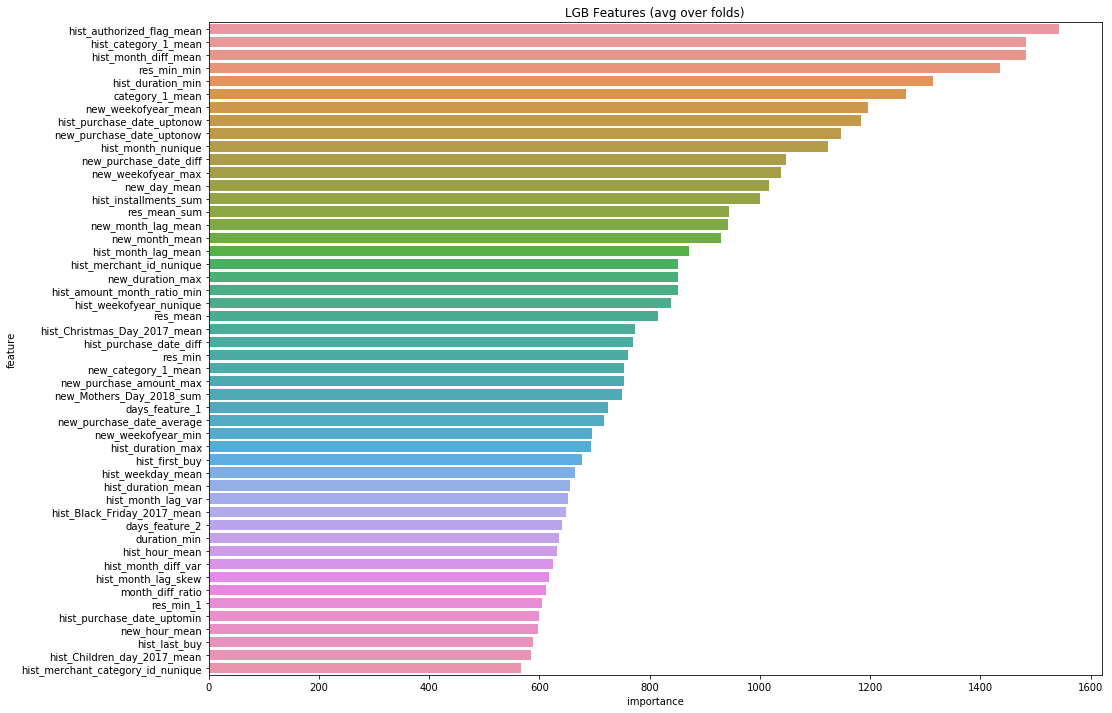

In [294]:
model, pred = model_train_easy(train_df, target, test_df)

In [ ]:
########################################################################################################################################

In [ ]:
########################################################################################################################################

In [296]:
train_df_bst22 = train_df
test_df_bst22 = test_df

In [337]:
train_df

,feature_1,feature_2,feature_3,quarter,elapsed_time,days_feature_1,days_feature_1_ratio,days_feature_2,days_feature_2_ratio,days_feature_3,...,res_sum_sum,res_max_max,res_min_min,res_std_std,res_mean_sum_1,res_sum_sum_1,res_max_1,res_min_1,res_std_1,card_id
0,0.013145,0.00875,0.011430,2,604,3020,0.008280,1208,0.003311,604,...,39.526751,23.223858,0.320180,5.914473,0.162526,2.275371,1.009733,0.013921,0.246837,C_ID_92a2005557
1,0.010710,0.01138,0.010284,1,755,3020,0.005300,755,0.001325,0,...,1.086441,0.564952,0.014755,0.141601,0.015424,0.215929,0.129014,0.002459,0.032853,C_ID_3d0044924f
2,0.010610,0.00875,0.010284,3,908,1816,0.002203,1816,0.002203,0,...,5.959544,1.191391,0.070519,0.353175,0.354937,4.969116,1.191391,0.070519,0.356086,C_ID_d639edf6cd
3,0.010710,0.01417,0.010284,3,512,2048,0.007812,1536,0.005860,0,...,9.253918,1.567290,0.171411,0.332657,0.122462,1.714463,0.223899,0.024487,0.049176,C_ID_186d6a6901
4,0.008060,0.01417,0.010284,4,451,451,0.002218,1353,0.006653,0,...,10.883915,2.143335,0.192881,0.473626,0.105044,1.470611,0.142131,0.005358,0.048562,C_ID_cdbd2c0db2
5,0.010710,0.00875,0.010284,3,877,3508,0.004562,1754,0.002281,0,...,17.747992,6.497601,0.564952,1.631232,0.309603,4.334446,1.624400,0.127664,0.411067,C_ID_0894217f2f
6,0.010480,0.00875,0.011430,4,786,2358,0.003817,1572,0.002544,786,...,4.190276,0.758728,0.101640,0.211484,0.059861,0.838055,0.151746,0.020328,0.042297,C_ID_7e63323c00
7,0.010480,0.00875,0.011430,3,512,1536,0.005860,1024,0.003906,512,...,7.124576,0.636661,0.126500,0.180778,0.120331,1.684628,0.154302,0.042167,0.033816,C_ID_dfa21fc124
8,0.010610,0.01138,0.010284,3,543,1086,0.003683,543,0.001842,0,...,11.243647,2.943997,0.148401,0.653107,0.289661,4.055256,1.471998,0.074200,0.370277,C_ID_fe0fdac8ea
9,0.010610,0.00875,0.010284,3,908,1816,0.002203,1816,0.002203,0,...,4.559910,0.900027,0.078923,0.251701,0.108569,1.519970,0.300009,0.026308,0.083900,C_ID_bf62c0b49d


In [336]:
train_df = train_df_bst22
test_df = test_df_bst22

In [338]:
hist_lag0 = hist[hist['month_lag'] == 0].groupby('card_id')['purchase_amount'].agg(['max', 'min']).reset_index()
hist_lag0.columns = ['card_id', 'lag0_max', 'lag0_min']

hist_lag1 = hist[hist['month_lag'] == -1].groupby('card_id')['purchase_amount'].agg(['max', 'min']).reset_index()
hist_lag1.columns = ['card_id','lag1_max', 'lag1_min']

hist_lag2 = hist[hist['month_lag'] == -2].groupby('card_id')['purchase_amount'].agg(['max', 'min']).reset_index()
hist_lag2.columns = ['card_id','lag2_max', 'lag2_min']

hist_lag3 = hist[hist['month_lag'] == -3].groupby('card_id')['purchase_amount'].agg(['max', 'min']).reset_index()
hist_lag3.columns = ['card_id','lag3_max', 'lag3_min']

hist_lag4 = hist[hist['month_lag'] == -4].groupby('card_id')['purchase_amount'].agg(['max', 'min']).reset_index()
hist_lag4.columns = ['card_id','lag4_max', 'lag4_min']

hist_lag5 = hist[hist['month_lag'] == -5].groupby('card_id')['purchase_amount'].agg(['max', 'min']).reset_index()
hist_lag5.columns = ['card_id','lag5_max', 'lag5_min']

hist_lag6 = hist[hist['month_lag'] == -6].groupby('card_id')['purchase_amount'].agg(['max', 'min']).reset_index()
hist_lag6.columns = ['card_id','lag6_max', 'lag6_min']

hist_lag7 = hist[hist['month_lag'] == -7].groupby('card_id')['purchase_amount'].agg(['max', 'min']).reset_index()
hist_lag7.columns = ['card_id','lag7_max', 'lag7_min']

hist_lag8 = hist[hist['month_lag'] == -8].groupby('card_id')['purchase_amount'].agg(['max', 'min']).reset_index()
hist_lag8.columns = ['card_id','lag8_max', 'lag8_min']

hist_lag9 = hist[hist['month_lag'] == -9].groupby('card_id')['purchase_amount'].agg(['max', 'min']).reset_index()
hist_lag9.columns = ['card_id','lag9_max', 'lag9_min']

hist_lag10 = hist[hist['month_lag'] == -10].groupby('card_id')['purchase_amount'].agg(['max', 'min']).reset_index()
hist_lag10.columns = ['card_id','lag10_max', 'lag10_min']

hist_lag11 = hist[hist['month_lag'] == -11].groupby('card_id')['purchase_amount'].agg(['max', 'min']).reset_index()
hist_lag11.columns = ['card_id','lag11_max', 'lag11_min']

hist_lag12 = hist[hist['month_lag'] == -12].groupby('card_id')['purchase_amount'].agg(['max', 'min']).reset_index()
hist_lag12.columns = ['card_id','lag12_max', 'lag12_min']

hist_lag13 = hist[hist['month_lag'] == -13].groupby('card_id')['purchase_amount'].agg(['max', 'min']).reset_index()
hist_lag13.columns = ['card_id','lag13_max', 'lag13_min']


new_purch = new.groupby('card_id')['purchase_amount'].agg(['max', 'min']).reset_index()
new_purch.columns = ['card_id', 'new_max', 'new_min']


In [339]:
new_hist_lag0 = pd.merge(new_purch, hist_lag0, on='card_id', how='left')
new_hist_lag0['res_max_0'] = new_hist_lag0['new_max'] / new_hist_lag0['lag0_max']
new_hist_lag0['res_min_0'] = new_hist_lag0['new_min'] / new_hist_lag0['lag0_min']

new_hist_lag0['res_max_min_0'] = new_hist_lag0['new_max'] / new_hist_lag0['lag0_min']

lag_0 = pd.DataFrame({'card_id': new_hist_lag0['card_id'], 
                      'res_max_0': new_hist_lag0['res_max_0'], 'res_min_0': new_hist_lag0['res_min_0'],
                    'res_max_min_0': new_hist_lag0['res_max_min_0'] })
lag_0.fillna(lag_0.iloc[:, 1:].median(), inplace=True)


In [340]:
new_hist_lag1 = pd.merge(new_purch, hist_lag1, on='card_id', how='left')
new_hist_lag1['res_max_1'] = new_hist_lag1['new_max'] / new_hist_lag1['lag1_max']
new_hist_lag1['res_min_1'] = new_hist_lag1['new_min'] / new_hist_lag1['lag1_min']

new_hist_lag1['res_max_min_1'] = new_hist_lag1['new_max'] / new_hist_lag1['lag1_min']

lag_1 = pd.DataFrame({'card_id': new_hist_lag1['card_id'], 
                      'res_max_1': new_hist_lag1['res_max_1'], 'res_min_1': new_hist_lag1['res_min_1'],
                    'res_max_min_1': new_hist_lag1['res_max_min_1'] })
lag_1.fillna(lag_1.iloc[:, 1:].median(), inplace=True)

In [341]:
new_hist_lag2 = pd.merge(new_purch, hist_lag2, on='card_id', how='left')
new_hist_lag2['res_max_2'] = new_hist_lag2['new_max'] / new_hist_lag2['lag2_max']
new_hist_lag2['res_min_2'] = new_hist_lag2['new_min'] / new_hist_lag2['lag2_min']

new_hist_lag2['res_max_min_2'] = new_hist_lag2['new_max'] / new_hist_lag2['lag2_min']

lag_2 = pd.DataFrame({'card_id': new_hist_lag2['card_id'], 
                      'res_max_2': new_hist_lag2['res_max_2'], 'res_min_2': new_hist_lag2['res_min_2'],
                    'res_max_min_2': new_hist_lag2['res_max_min_2'] })
lag_2.fillna(lag_2.iloc[:, 1:].median(), inplace=True)

In [342]:
new_hist_lag3 = pd.merge(new_purch, hist_lag3, on='card_id', how='left')
new_hist_lag3['res_max_3'] = new_hist_lag3['new_max'] / new_hist_lag3['lag3_max']
new_hist_lag3['res_min_3'] = new_hist_lag3['new_min'] / new_hist_lag3['lag3_min']

new_hist_lag3['res_max_min_3'] = new_hist_lag3['new_max'] / new_hist_lag3['lag3_min']

lag_3 = pd.DataFrame({'card_id': new_hist_lag3['card_id'], 
                      'res_max_3': new_hist_lag3['res_max_3'], 'res_min_3': new_hist_lag3['res_min_3'],
                    'res_max_min_3': new_hist_lag3['res_max_min_3'] })
lag_3.fillna(lag_3.iloc[:, 1:].median(), inplace=True)

In [343]:
new_hist_lag4 = pd.merge(new_purch, hist_lag4, on='card_id', how='left')
new_hist_lag4['res_max_4'] = new_hist_lag4['new_max'] / new_hist_lag4['lag4_max']
new_hist_lag4['res_min_4'] = new_hist_lag4['new_min'] / new_hist_lag4['lag4_min']

new_hist_lag4['res_max_min_4'] = new_hist_lag4['new_max'] / new_hist_lag4['lag4_min']

lag_4 = pd.DataFrame({'card_id': new_hist_lag4['card_id'], 
                      'res_max_4': new_hist_lag4['res_max_4'], 'res_min_4': new_hist_lag4['res_min_4'],
                    'res_max_min_4': new_hist_lag4['res_max_min_4'] })
lag_4.fillna(lag_4.iloc[:, 1:].median(), inplace=True)

In [344]:
new_hist_lag5 = pd.merge(new_purch, hist_lag5, on='card_id', how='left')
new_hist_lag5['res_max_5'] = new_hist_lag5['new_max'] / new_hist_lag5['lag5_max']
new_hist_lag5['res_min_5'] = new_hist_lag5['new_min'] / new_hist_lag5['lag5_min']

new_hist_lag5['res_max_min_5'] = new_hist_lag5['new_max'] / new_hist_lag5['lag5_min']

lag_5 = pd.DataFrame({'card_id': new_hist_lag5['card_id'], 
                      'res_max_5': new_hist_lag5['res_max_5'], 'res_min_5': new_hist_lag5['res_min_5'],
                    'res_max_min_5': new_hist_lag5['res_max_min_5'] })
lag_5.fillna(lag_5.iloc[:, 1:].median(), inplace=True)

In [345]:
new_hist_lag6 = pd.merge(new_purch, hist_lag6, on='card_id', how='left')
new_hist_lag6['res_max_6'] = new_hist_lag6['new_max'] / new_hist_lag6['lag6_max']
new_hist_lag6['res_min_6'] = new_hist_lag6['new_min'] / new_hist_lag6['lag6_min']

new_hist_lag6['res_max_min_6'] = new_hist_lag6['new_max'] / new_hist_lag6['lag6_min']

lag_6 = pd.DataFrame({'card_id': new_hist_lag6['card_id'], 
                      'res_max_6': new_hist_lag6['res_max_6'], 'res_min_6': new_hist_lag6['res_min_6'],
                    'res_max_min_6': new_hist_lag6['res_max_min_6'] })
lag_6.fillna(lag_6.iloc[:, 1:].median(), inplace=True)

In [346]:
new_hist_lag7 = pd.merge(new_purch, hist_lag7, on='card_id', how='left')
new_hist_lag7['res_max_7'] = new_hist_lag7['new_max'] / new_hist_lag7['lag7_max']
new_hist_lag7['res_min_7'] = new_hist_lag7['new_min'] / new_hist_lag7['lag7_min']

new_hist_lag7['res_max_min_7'] = new_hist_lag7['new_max'] / new_hist_lag7['lag7_min']

lag_7 = pd.DataFrame({'card_id': new_hist_lag7['card_id'], 
                      'res_max_7': new_hist_lag7['res_max_7'], 'res_min_7': new_hist_lag7['res_min_7'],
                    'res_max_min_7': new_hist_lag7['res_max_min_7'] })
lag_7.fillna(lag_7.iloc[:, 1:].median(), inplace=True)

In [347]:
new_hist_lag8 = pd.merge(new_purch, hist_lag8, on='card_id', how='left')
new_hist_lag8['res_max_8'] = new_hist_lag8['new_max'] / new_hist_lag8['lag8_max']
new_hist_lag8['res_min_8'] = new_hist_lag8['new_min'] / new_hist_lag8['lag8_min']

new_hist_lag8['res_max_min_8'] = new_hist_lag8['new_max'] / new_hist_lag8['lag8_min']

lag_8 = pd.DataFrame({'card_id': new_hist_lag8['card_id'], 
                      'res_max_8': new_hist_lag8['res_max_8'], 'res_min_8': new_hist_lag8['res_min_8'],
                    'res_max_min_8': new_hist_lag8['res_max_min_8'] })
lag_8.fillna(lag_8.iloc[:, 1:].median(), inplace=True)

In [348]:
new_hist_lag9 = pd.merge(new_purch, hist_lag9, on='card_id', how='left')
new_hist_lag9['res_max_9'] = new_hist_lag9['new_max'] / new_hist_lag9['lag9_max']
new_hist_lag9['res_min_9'] = new_hist_lag9['new_min'] / new_hist_lag9['lag9_min']

new_hist_lag9['res_max_min_9'] = new_hist_lag9['new_max'] / new_hist_lag9['lag9_min']

lag_9 = pd.DataFrame({'card_id': new_hist_lag9['card_id'], 
                      'res_max_9': new_hist_lag9['res_max_9'], 'res_min_9': new_hist_lag9['res_min_9'],
                    'res_max_min_9': new_hist_lag9['res_max_min_9'] })
lag_9.fillna(lag_9.iloc[:, 1:].median(), inplace=True)

In [349]:
new_hist_lag10 = pd.merge(new_purch, hist_lag10, on='card_id', how='left')
new_hist_lag10['res_max_10'] = new_hist_lag10['new_max'] / new_hist_lag10['lag10_max']
new_hist_lag10['res_min_10'] = new_hist_lag10['new_min'] / new_hist_lag10['lag10_min']

new_hist_lag10['res_max_min_10'] = new_hist_lag10['new_max'] / new_hist_lag10['lag10_min']

lag_10 = pd.DataFrame({'card_id': new_hist_lag10['card_id'], 
                      'res_max_10': new_hist_lag10['res_max_10'], 'res_min_10': new_hist_lag10['res_min_10'],
                    'res_max_min_10': new_hist_lag10['res_max_min_10'] })
lag_10.fillna(lag_10.iloc[:, 1:].median(), inplace=True)

In [350]:
new_hist_lag11 = pd.merge(new_purch, hist_lag11, on='card_id', how='left')
new_hist_lag11['res_max_11'] = new_hist_lag11['new_max'] / new_hist_lag11['lag11_max']
new_hist_lag11['res_min_11'] = new_hist_lag11['new_min'] / new_hist_lag11['lag11_min']

new_hist_lag11['res_max_min_11'] = new_hist_lag11['new_max'] / new_hist_lag11['lag11_min']

lag_11 = pd.DataFrame({'card_id': new_hist_lag11['card_id'], 
                      'res_max_11': new_hist_lag11['res_max_11'], 'res_min_11': new_hist_lag11['res_min_11'],
                    'res_max_min_11': new_hist_lag11['res_max_min_11'] })
lag_11.fillna(lag_11.iloc[:, 1:].median(), inplace=True)

In [351]:
new_hist_lag12 = pd.merge(new_purch, hist_lag12, on='card_id', how='left')
new_hist_lag12['res_max_12'] = new_hist_lag12['new_max'] / new_hist_lag12['lag12_max']
new_hist_lag12['res_min_12'] = new_hist_lag12['new_min'] / new_hist_lag12['lag12_min']

new_hist_lag12['res_max_min_12'] = new_hist_lag12['new_max'] / new_hist_lag12['lag12_min']

lag_12 = pd.DataFrame({'card_id': new_hist_lag12['card_id'], 
                      'res_max_12': new_hist_lag12['res_max_12'], 'res_min_12': new_hist_lag12['res_min_12'],
                    'res_max_min_12': new_hist_lag12['res_max_min_12'] })
lag_12.fillna(lag_12.iloc[:, 1:].median(), inplace=True)

In [352]:
new_hist_lag13 = pd.merge(new_purch, hist_lag13, on='card_id', how='left')
new_hist_lag13['res_max_13'] = new_hist_lag13['new_max'] / new_hist_lag13['lag13_max']
new_hist_lag13['res_min_13'] = new_hist_lag13['new_min'] / new_hist_lag13['lag13_min']

new_hist_lag13['res_max_min_13'] = new_hist_lag13['new_max'] / new_hist_lag13['lag13_min']

lag_13 = pd.DataFrame({'card_id': new_hist_lag13['card_id'], 
                      'res_max_13': new_hist_lag13['res_max_13'], 'res_min_13': new_hist_lag13['res_min_13'],
                    'res_max_min_13': new_hist_lag13['res_max_min_13'] })
lag_13.fillna(lag_13.iloc[:, 1:].median(), inplace=True)

In [353]:
lag = pd.concat([lag_0, lag_1, lag_2, lag_3, lag_4, lag_5,
                 lag_6, lag_7, lag_8, lag_9, lag_10, lag_11, lag_12, lag_13], axis=0)




In [354]:
lag.head(5)

,card_id,res_max_0,res_max_1,res_max_10,res_max_11,res_max_12,res_max_13,res_max_2,res_max_3,res_max_4,...,res_min_12,res_min_13,res_min_2,res_min_3,res_min_4,res_min_5,res_min_6,res_min_7,res_min_8,res_min_9
0,C_ID_00007093c1,0.120000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,C_ID_0001238066,1.393573,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,C_ID_0001506ef0,0.014085,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,C_ID_0001793786,1.787632,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,C_ID_000183fdda,0.327483,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [355]:
lag['res_max'] = 0

sc2 = lag_0.shape[0]
lag['res_max'].iloc[:sc2] = lag['res_max_0'].iloc[:sc2]

sc1 = lag_0.shape[0]
sc2 = sc1 + lag_1.shape[0]
lag['res_max'].iloc[sc1:sc2] = lag['res_max_1'].iloc[sc1:sc2]

sc1 = sc2
sc2 = sc2 + lag_2.shape[0]
lag['res_max'].iloc[sc1:sc2] = lag['res_max_2'].iloc[sc1:sc2]

sc1 = sc2
sc2 = sc2 + lag_3.shape[0]
lag['res_max'].iloc[sc1:sc2] = lag['res_max_3'].iloc[sc1:sc2]

sc1 = sc2
sc2 = sc2 + lag_4.shape[0]
lag['res_max'].iloc[sc1:sc2] = lag['res_max_4'].iloc[sc1:sc2]

sc1 = sc2
sc2 = sc2 + lag_5.shape[0]
lag['res_max'].iloc[sc1:sc2] = lag['res_max_5'].iloc[sc1:sc2]

sc1 = sc2
sc2 = sc2 + lag_6.shape[0]
lag['res_max'].iloc[sc1:sc2] = lag['res_max_6'].iloc[sc1:sc2]

sc1 = sc2
sc2 = sc2 + lag_7.shape[0]
lag['res_max'].iloc[sc1:sc2] = lag['res_max_7'].iloc[sc1:sc2]

sc1 = sc2
sc2 = sc2 + lag_8.shape[0]
lag['res_max'].iloc[sc1:sc2] = lag['res_max_8'].iloc[sc1:sc2]

sc1 = sc2
sc2 = sc2 + lag_9.shape[0]
lag['res_max'].iloc[sc1:sc2] = lag['res_max_9'].iloc[sc1:sc2]

sc1 = sc2
sc2 = sc2 + lag_10.shape[0]
lag['res_max'].iloc[sc1:sc2] = lag['res_max_10'].iloc[sc1:sc2]

sc1 = sc2
sc2 = sc2 + lag_11.shape[0]
lag['res_max'].iloc[sc1:sc2] = lag['res_max_11'].iloc[sc1:sc2]

sc1 = sc2
sc2 = sc2 + lag_12.shape[0]
lag['res_max'].iloc[sc1:sc2] = lag['res_max_12'].iloc[sc1:sc2]

sc1 = sc2
sc2 = sc2 + lag_13.shape[0]
lag['res_max'].iloc[sc1:sc2] = lag['res_max_13'].iloc[sc1:sc2]

# lag['res_max'].iloc[lag_4.shape[0]:lag_5.shape[0]] = lag['res_max_5'].iloc[lag_4.shape[0]:lag_5.shape[0]]
# lag['res_max'].iloc[lag_5.shape[0]:lag_6.shape[0]] = lag['res_max_6'].iloc[lag_5.shape[0]:lag_6.shape[0]]
# lag['res_max'].iloc[lag_6.shape[0]:lag_7.shape[0]] = lag['res_max_7'].iloc[lag_6.shape[0]:lag_7.shape[0]]
# lag['res_max'].iloc[lag_7.shape[0]:lag_8.shape[0]] = lag['res_max_8'].iloc[lag_7.shape[0]:lag_8.shape[0]]
# lag['res_max'].iloc[lag_8.shape[0]:lag_9.shape[0]] = lag['res_max_9'].iloc[lag_8.shape[0]:lag_9.shape[0]]
# lag['res_max'].iloc[lag_9.shape[0]:lag_10.shape[0]] = lag['res_max_10'].iloc[lag_9.shape[0]:lag_10.shape[0]]
# lag['res_max'].iloc[lag_10.shape[0]:lag_11.shape[0]] = lag['res_max_11'].iloc[lag_10.shape[0]:lag_11.shape[0]]
# lag['res_max'].iloc[lag_11.shape[0]:lag_12.shape[0]] = lag['res_max_12'].iloc[lag_11.shape[0]:lag_12.shape[0]]
# lag['res_max'].iloc[lag_11.shape[0]:lag_13.shape[0]] = lag['res_max_13'].iloc[lag_12.shape[0]:lag_13.shape[0]]

In [356]:
lag['res_min'] = 0

sc2 = lag_0.shape[0]
lag['res_min'].iloc[:sc2] = lag['res_min_0'].iloc[:sc2]

sc1 = lag_0.shape[0]
sc2 = sc1 + lag_1.shape[0]
lag['res_min'].iloc[sc1:sc2] = lag['res_min_1'].iloc[sc1:sc2]

sc1 = sc2
sc2 = sc2 + lag_2.shape[0]
lag['res_min'].iloc[sc1:sc2] = lag['res_min_2'].iloc[sc1:sc2]

sc1 = sc2
sc2 = sc2 + lag_3.shape[0]
lag['res_min'].iloc[sc1:sc2] = lag['res_min_3'].iloc[sc1:sc2]

sc1 = sc2
sc2 = sc2 + lag_4.shape[0]
lag['res_min'].iloc[sc1:sc2] = lag['res_min_4'].iloc[sc1:sc2]

sc1 = sc2
sc2 = sc2 + lag_5.shape[0]
lag['res_min'].iloc[sc1:sc2] = lag['res_min_5'].iloc[sc1:sc2]

sc1 = sc2
sc2 = sc2 + lag_6.shape[0]
lag['res_min'].iloc[sc1:sc2] = lag['res_min_6'].iloc[sc1:sc2]

sc1 = sc2
sc2 = sc2 + lag_7.shape[0]
lag['res_min'].iloc[sc1:sc2] = lag['res_min_7'].iloc[sc1:sc2]

sc1 = sc2
sc2 = sc2 + lag_8.shape[0]
lag['res_min'].iloc[sc1:sc2] = lag['res_min_8'].iloc[sc1:sc2]

sc1 = sc2
sc2 = sc2 + lag_9.shape[0]
lag['res_min'].iloc[sc1:sc2] = lag['res_min_9'].iloc[sc1:sc2]

sc1 = sc2
sc2 = sc2 + lag_10.shape[0]
lag['res_min'].iloc[sc1:sc2] = lag['res_min_10'].iloc[sc1:sc2]

sc1 = sc2
sc2 = sc2 + lag_11.shape[0]
lag['res_min'].iloc[sc1:sc2] = lag['res_min_11'].iloc[sc1:sc2]

sc1 = sc2
sc2 = sc2 + lag_12.shape[0]
lag['res_min'].iloc[sc1:sc2] = lag['res_min_12'].iloc[sc1:sc2]

sc1 = sc2
sc2 = sc2 + lag_13.shape[0]
lag['res_min'].iloc[sc1:sc2] = lag['res_min_13'].iloc[sc1:sc2]

In [357]:
lag['res_max_min'] = 0

sc2 = lag_0.shape[0]
lag['res_max_min'].iloc[:sc2] = lag['res_max_min_0'].iloc[:sc2]

sc1 = lag_0.shape[0]
sc2 = sc1 + lag_1.shape[0]
lag['res_max_min'].iloc[sc1:sc2] = lag['res_max_min_1'].iloc[sc1:sc2]

sc1 = sc2
sc2 = sc2 + lag_2.shape[0]
lag['res_max_min'].iloc[sc1:sc2] = lag['res_max_min_2'].iloc[sc1:sc2]

sc1 = sc2
sc2 = sc2 + lag_3.shape[0]
lag['res_max_min'].iloc[sc1:sc2] = lag['res_max_min_3'].iloc[sc1:sc2]

sc1 = sc2
sc2 = sc2 + lag_4.shape[0]
lag['res_max_min'].iloc[sc1:sc2] = lag['res_max_min_4'].iloc[sc1:sc2]

sc1 = sc2
sc2 = sc2 + lag_5.shape[0]
lag['res_max_min'].iloc[sc1:sc2] = lag['res_max_min_5'].iloc[sc1:sc2]

sc1 = sc2
sc2 = sc2 + lag_6.shape[0]
lag['res_max_min'].iloc[sc1:sc2] = lag['res_max_min_6'].iloc[sc1:sc2]

sc1 = sc2
sc2 = sc2 + lag_7.shape[0]
lag['res_max_min'].iloc[sc1:sc2] = lag['res_max_min_7'].iloc[sc1:sc2]

sc1 = sc2
sc2 = sc2 + lag_8.shape[0]
lag['res_max_min'].iloc[sc1:sc2] = lag['res_max_min_8'].iloc[sc1:sc2]

sc1 = sc2
sc2 = sc2 + lag_9.shape[0]
lag['res_max_min'].iloc[sc1:sc2] = lag['res_max_min_9'].iloc[sc1:sc2]

sc1 = sc2
sc2 = sc2 + lag_10.shape[0]
lag['res_max_min'].iloc[sc1:sc2] = lag['res_max_min_10'].iloc[sc1:sc2]

sc1 = sc2
sc2 = sc2 + lag_11.shape[0]
lag['res_max_min'].iloc[sc1:sc2] = lag['res_max_min_11'].iloc[sc1:sc2]

sc1 = sc2
sc2 = sc2 + lag_12.shape[0]
lag['res_max_min'].iloc[sc1:sc2] = lag['res_max_min_12'].iloc[sc1:sc2]

sc1 = sc2
sc2 = sc2 + lag_13.shape[0]
lag['res_max_min'].iloc[sc1:sc2] = lag['res_max_min_13'].iloc[sc1:sc2]

In [358]:
lag_f = 0
lag_f = lag.groupby('card_id')['res_max'].agg(['mean', 'sum']).reset_index()
lag_f.columns = ['card_id', 'res_mean', 'res_sum']

lag_f_min = lag.groupby('card_id')['res_min'].agg(['mean', 'sum']).reset_index()
lag_f_min.columns = ['card_id', 'res_max_min', 'res_min_min']

lag_f_max_min = lag.groupby('card_id')['res_max_min'].agg(['mean', 'sum']).reset_index()
lag_f_max_min.columns = ['card_id', 'res_max_min_1', 'res_min_min_1']

lag_f.head(5)

,card_id,res_mean,res_sum
0,C_ID_00007093c1,0.221080,3.095122
1,C_ID_0001238066,1.242536,17.395506
2,C_ID_0001506ef0,0.300162,4.202272
3,C_ID_0001793786,1.313266,18.385718
4,C_ID_000183fdda,0.656932,9.197053


In [323]:
train_df, test_df = add_card_id()

In [359]:
train_df = pd.merge(train_df, lag_f, on='card_id', how='left')
test_df = pd.merge(test_df, lag_f, on='card_id', how='left')

train_df = pd.merge(train_df, lag_f_sum, on='card_id', how='left')
test_df = pd.merge(test_df, lag_f_sum, on='card_id', how='left')

train_df = pd.merge(train_df, lag_f_mean_sum, on='card_id', how='left')
test_df = pd.merge(test_df, lag_f_mean_sum, on='card_id', how='left')

In [332]:
train_df.shape

(201917, 237)

In [360]:
train_df, test_df = drop_card_id()

Training until validation scores don't improve for 500 rounds.
[100]	training's rmse: 3.72058
[200]	training's rmse: 3.65793
[300]	training's rmse: 3.62096
[400]	training's rmse: 3.59527
[500]	training's rmse: 3.57618
[600]	training's rmse: 3.56004
[700]	training's rmse: 3.54592
[800]	training's rmse: 3.53355
[900]	training's rmse: 3.52219
[1000]	training's rmse: 3.51223
[1100]	training's rmse: 3.50241
[1200]	training's rmse: 3.4936
[1300]	training's rmse: 3.4849
[1400]	training's rmse: 3.47644
[1500]	training's rmse: 3.46775
[1600]	training's rmse: 3.45991
[1700]	training's rmse: 3.45168
[1800]	training's rmse: 3.444
[1900]	training's rmse: 3.43649
[2000]	training's rmse: 3.42895
Did not meet early stopping. Best iteration is:
[2000]	training's rmse: 3.42895


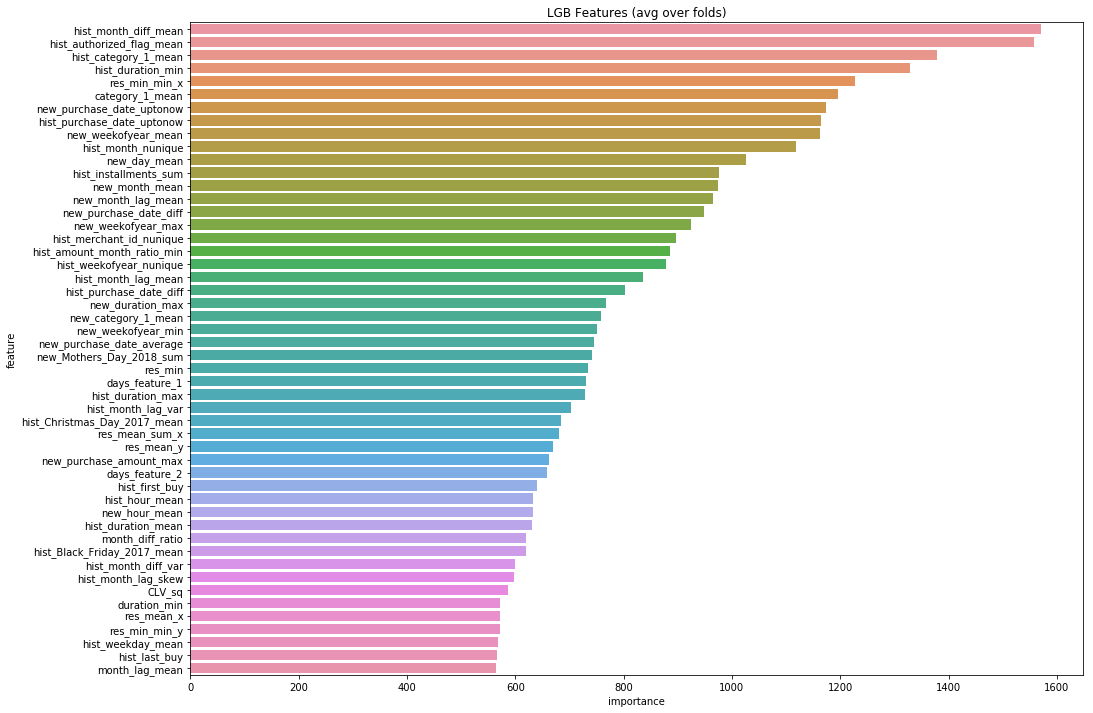

In [361]:
model, pred = model_train_easy(train_df, target, test_df)

In [ ]:
#############################

In [363]:
train_df_bsthep22 = train_df
test_df_bsthep22 = test_df

In [466]:
train_df, test_df = train_df_bsthep22, test_df_bsthep22

In [427]:
train_df.shape

(201917, 234)

In [373]:
hist_up = pd.read_csv('historical_transactions_up.csv')

In [374]:
hist_up.head(5)

,authorized_flag,card_id,city_id,category_1,installments,category_3,merchant_category_id,merchant_id,month_lag,purchase_amount,purchase_date,category_2,state_id,subsector_id,imputed_merchant_id
0,Y,C_ID_4e6213e9bc,88,N,0,A,80,M_ID_e020e9b302,-8,29.00,2017-06-25 15:33:07,1.0,16,37,NaN
1,Y,C_ID_4e6213e9bc,88,N,0,A,367,M_ID_86ec983688,-7,9.17,2017-07-15 12:10:45,1.0,16,16,NaN
2,Y,C_ID_4e6213e9bc,88,N,0,A,80,M_ID_979ed661fc,-6,17.65,2017-08-09 22:04:29,1.0,16,37,NaN
3,Y,C_ID_4e6213e9bc,88,N,0,A,560,M_ID_e6d5ae8ea6,-5,7.69,2017-09-02 10:06:26,1.0,16,34,NaN
4,Y,C_ID_4e6213e9bc,88,N,0,A,80,M_ID_e020e9b302,-11,16.00,2017-03-10 01:14:19,1.0,16,37,NaN


In [470]:
hist_merch = pd.DataFrame({'card_id': hist_up['card_id'], 'merch_id': hist_up['merchant_id'],
                          'purchase_amount': hist_up['purchase_amount'],
                          'month_lag': hist_up['month_lag']})

In [429]:
hist_merch.head(5)

,card_id,merch_id,purchase_amount,month_lag
0,C_ID_4e6213e9bc,M_ID_e020e9b302,29.00,-8
1,C_ID_4e6213e9bc,M_ID_86ec983688,9.17,-7
2,C_ID_4e6213e9bc,M_ID_979ed661fc,17.65,-6
3,C_ID_4e6213e9bc,M_ID_e6d5ae8ea6,7.69,-5
4,C_ID_4e6213e9bc,M_ID_e020e9b302,16.00,-11


In [471]:
merch_group = hist_merch.groupby('merch_id')['purchase_amount'].agg(['mean', 'sum', 'min', 'max', 'std']).reset_index()
merch_group.columns = ['merch_id', 'merch_mean', 'merch_sum', 'merch_min', 'merch_max', 'merch_std']

merch_group.head(5)

,merch_id,merch_mean,merch_sum,merch_min,merch_max,merch_std
0,M_ID_000025127f,11.055556,99.50,5.5,18.00,3.395258
1,M_ID_0000699140,63.240175,3604.69,11.0,452.39,68.684098
2,M_ID_00006a5552,75.000000,75.00,75.0,75.00,NaN
3,M_ID_000087311e,414.445455,9117.80,9.0,1933.00,497.527797
4,M_ID_0000ab0b2d,35.459667,1063.79,2.0,286.51,53.889194


In [474]:
hist_merch = pd.merge(hist_merch, merch_group, on='merch_id', how='left')

In [475]:
hist_merch.head(5)

,card_id,merch_id,purchase_amount,month_lag,merch_mean,merch_sum,merch_min,merch_max,merch_std
0,C_ID_4e6213e9bc,M_ID_e020e9b302,29.00,-8,44.111648,1003584.10,0.01,520006.08,3447.586624
1,C_ID_4e6213e9bc,M_ID_86ec983688,9.17,-7,67.773628,1665604.67,0.49,1715.57,95.660367
2,C_ID_4e6213e9bc,M_ID_979ed661fc,17.65,-6,24.408820,17379.08,1.80,218.73,26.073893
3,C_ID_4e6213e9bc,M_ID_e6d5ae8ea6,7.69,-5,8.466897,1964.32,1.90,63.06,7.732113
4,C_ID_4e6213e9bc,M_ID_e020e9b302,16.00,-11,44.111648,1003584.10,0.01,520006.08,3447.586624


In [476]:
hist_merch_merge = hist_merch.drop(columns=['merch_id', 'purchase_amount', 'month_lag'])
hist_merch_merge.head(5)

,card_id,merch_mean,merch_sum,merch_min,merch_max,merch_std
0,C_ID_4e6213e9bc,44.111648,1003584.10,0.01,520006.08,3447.586624
1,C_ID_4e6213e9bc,67.773628,1665604.67,0.49,1715.57,95.660367
2,C_ID_4e6213e9bc,24.408820,17379.08,1.80,218.73,26.073893
3,C_ID_4e6213e9bc,8.466897,1964.32,1.90,63.06,7.732113
4,C_ID_4e6213e9bc,44.111648,1003584.10,0.01,520006.08,3447.586624


In [477]:
hist_merch_merge.fillna(hist_merch_merge.iloc[:,1:].median(), inplace=True)

In [478]:
card_merch_merge = hist_merch_merge.groupby('card_id')['merch_mean'].agg(['mean', 'sum', 'std']).reset_index()
card_merch_merge.columns = ['card_id', 'merch_mean', 'merch_sum', 'merch_std']

card_merch_sum_merge = hist_merch_merge.groupby('card_id')['merch_sum'].agg(['max', 'min', 'mean', 'sum', 'std']).reset_index()
card_merch_sum_merge.columns = ['card_id', 'merch_sum_mean', 'merch_sum_sum', 'mean_1', 'sum_1', 'std_1']


display(card_merch_merge.head(5))
print()
display(card_merch_sum_merge.head(5))

,card_id,merch_mean,merch_sum,merch_std
0,C_ID_00007093c1,280.465997,41789.433614,1091.316965
1,C_ID_0001238066,131.924044,16226.657373,206.250497
2,C_ID_0001506ef0,131.156687,8656.341372,103.102864
3,C_ID_0001793786,150.864465,32586.724503,190.402848
4,C_ID_000183fdda,161.222277,23216.007934,211.003884


,card_id,merch_sum_mean,merch_sum_sum,mean_1,sum_1,std_1
0,C_ID_00007093c1,3.120010e+06,257.9,6.607800e+05,9.845622e+07,1.040224e+06
1,C_ID_0001238066,3.984602e+07,52.5,1.234547e+06,1.518493e+08,4.356868e+06
2,C_ID_0001506ef0,1.051488e+08,280.0,4.630901e+06,3.056394e+08,1.808078e+07
3,C_ID_0001793786,1.051488e+08,359.5,3.033558e+06,6.552486e+08,1.730484e+07
4,C_ID_000183fdda,1.051488e+08,208.6,4.456260e+06,6.417015e+08,1.976297e+07


In [479]:
card_merch_merge_min = hist_merch_merge.groupby('card_id')['merch_min'].agg(['mean', 'sum', 'std']).reset_index()
card_merch_merge_min.columns = ['card_id', 'merch_mea2', 'merch_sum2', 'merch_std2']

card_merch_merge_max = hist_merch_merge.groupby('card_id')['merch_max'].agg(['mean', 'sum', 'std']).reset_index()
card_merch_merge_max.columns = ['card_id', 'merch_mean3', 'merch_sum3', 'merch_std3']

card_merch_merge_std = hist_merch_merge.groupby('card_id')['merch_std'].agg(['mean', 'sum', 'std']).reset_index()
card_merch_merge_std.columns = ['card_id', 'merch_mean4', 'merch_sum4', 'merch_std4']

In [395]:
np.sum(hist_merch_merge.isnull())

card_id       0
merch_mean    0
merch_sum     0
dtype: int64

In [399]:
hist_merch_merge.shape

(29112361, 3)

In [462]:
train_df, test_df = add_card_id()

In [480]:
train_df = pd.merge(train_df, card_merch_merge, on='card_id', how='left')
train_df = pd.merge(train_df, card_merch_sum_merge, on='card_id', how='left')

test_df = pd.merge(test_df, card_merch_sum_merge, on='card_id', how='left')
test_df = pd.merge(test_df, card_merch_merge, on='card_id', how='left')

#####

train_df = pd.merge(train_df, card_merch_merge_min, on='card_id', how='left')
test_df = pd.merge(test_df, card_merch_merge_min, on='card_id', how='left')

train_df = pd.merge(train_df, card_merch_merge_max, on='card_id', how='left')
test_df = pd.merge(test_df, card_merch_merge_max, on='card_id', how='left')

train_df = pd.merge(train_df, card_merch_merge_std, on='card_id', how='left')
test_df = pd.merge(test_df, card_merch_merge_std, on='card_id', how='left')

In [483]:
train_df, test_df = drop_card_id()

In [481]:
train_df.shape

(201917, 251)

In [425]:
target.shape

(201917,)

Training until validation scores don't improve for 500 rounds.
[100]	training's rmse: 3.71978
[200]	training's rmse: 3.65694
[300]	training's rmse: 3.61997
[400]	training's rmse: 3.59415
[500]	training's rmse: 3.57511
[600]	training's rmse: 3.55899
[700]	training's rmse: 3.54465
[800]	training's rmse: 3.53217
[900]	training's rmse: 3.5208
[1000]	training's rmse: 3.51031
[1100]	training's rmse: 3.50073
[1200]	training's rmse: 3.49142
[1300]	training's rmse: 3.48223
[1400]	training's rmse: 3.47354
[1500]	training's rmse: 3.46516
[1600]	training's rmse: 3.45658
[1700]	training's rmse: 3.4484
[1800]	training's rmse: 3.43993
[1900]	training's rmse: 3.43209
[2000]	training's rmse: 3.42429
Did not meet early stopping. Best iteration is:
[2000]	training's rmse: 3.42429


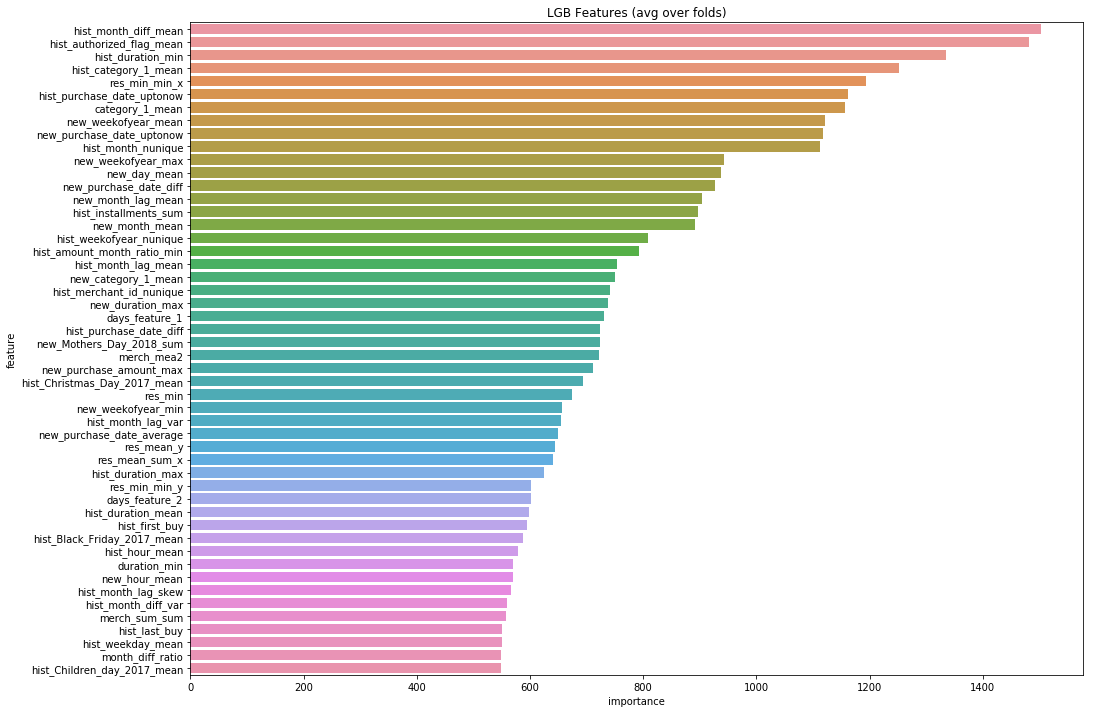

In [484]:
model, pred = model_train_easy(train_df, target, test_df)

In [ ]:
#######################################################################################################################

In [ ]:
# hep6 Добавить новых продавцов , фичу нагернереннную с помощью purche amount

In [ ]:
#####################################################################################################################

In [487]:
# train_df.to_csv('train_df_up2.csv', index=False)

In [488]:
# test_df.to_csv('test_df.csv', index=False)

In [489]:
params = {
            #'gpu_use_dp': False, 
            #'gpu_platform_id': 0, 
            #'gpu_device_id': 0, 
            #'device': 'gpu', 
#             'n_estimators': 30000,
            'objective': 'regression_l2', 
            'boosting_type': 'gbdt', 
            'n_jobs': 4, 'max_depth': 7, 
            'n_estimators': 2200, 
            'subsample_freq': 2, 
            'subsample_for_bin': 200000, 
            'min_data_per_group': 100, 
            'max_cat_to_onehot': 4, 
            'cat_l2': 10.0, 
            'cat_smooth': 10.0, 
            'max_cat_threshold': 32, 
            'metric_freq': 10, 
            'verbosity': -1, 
            'metric': 'rmse', 
            'colsample_bytree': 0.5, 
            'learning_rate': 0.0061033234451294376, 
            'min_child_samples': 80, 
            'min_child_weight': 100.0, 
            'min_split_gain': 1e-06, 
            'num_leaves': 47, 
            'reg_alpha': 10.0, 
            'reg_lambda': 10.0, 
            'subsample': 0.9}


Training until validation scores don't improve for 500 rounds.
[100]	training's rmse: 3.71978
[200]	training's rmse: 3.65694
[300]	training's rmse: 3.61997
[400]	training's rmse: 3.59415
[500]	training's rmse: 3.57511
[600]	training's rmse: 3.55899
[700]	training's rmse: 3.54465
[800]	training's rmse: 3.53217
[900]	training's rmse: 3.5208
[1000]	training's rmse: 3.51031
[1100]	training's rmse: 3.50073
[1200]	training's rmse: 3.49142
[1300]	training's rmse: 3.48223
[1400]	training's rmse: 3.47354
[1500]	training's rmse: 3.46516
[1600]	training's rmse: 3.45658
[1700]	training's rmse: 3.4484
[1800]	training's rmse: 3.43993
[1900]	training's rmse: 3.43209
[2000]	training's rmse: 3.42429
[2100]	training's rmse: 3.41656
[2200]	training's rmse: 3.40934
Did not meet early stopping. Best iteration is:
[2200]	training's rmse: 3.40934


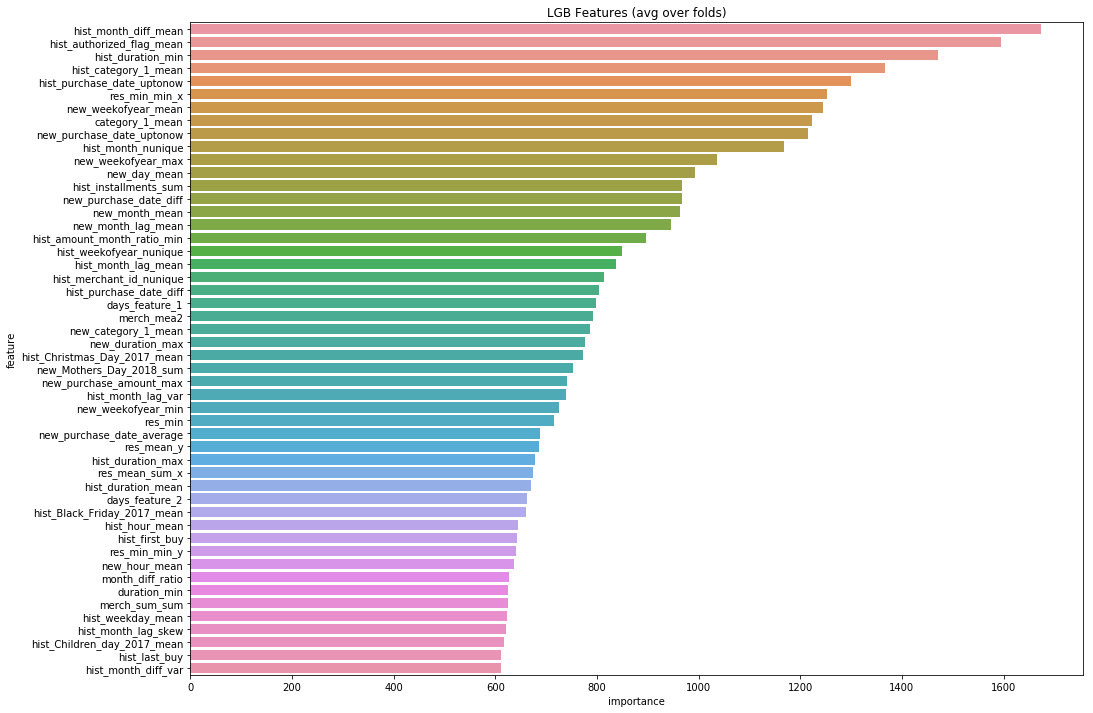

In [490]:
model, pred = model_train_easy(train_df, target, test_df)

In [492]:
params = {
            #'gpu_use_dp': False, 
            #'gpu_platform_id': 0, 
            #'gpu_device_id': 0, 
            #'device': 'gpu', 
#             'n_estimators': 30000,
            'objective': 'regression_l2', 
            'boosting_type': 'gbdt', 
            'n_jobs': 4, 'max_depth': 7, 
            'n_estimators': 2500, 
            'subsample_freq': 2, 
            'subsample_for_bin': 200000, 
            'min_data_per_group': 100, 
            'max_cat_to_onehot': 4, 
            'cat_l2': 10.0, 
            'cat_smooth': 10.0, 
            'max_cat_threshold': 32, 
            'metric_freq': 10, 
            'verbosity': -1, 
            'metric': 'rmse', 
            'colsample_bytree': 0.5, 
            'learning_rate': 0.0061033234451294376, 
            'min_child_samples': 80, 
            'min_child_weight': 100.0, 
            'min_split_gain': 1e-06, 
            'num_leaves': 47, 
            'reg_alpha': 10.0, 
            'reg_lambda': 10.0, 
            'subsample': 0.9}


Training until validation scores don't improve for 500 rounds.
[100]	training's rmse: 3.71978
[200]	training's rmse: 3.65694
[300]	training's rmse: 3.61997
[400]	training's rmse: 3.59415
[500]	training's rmse: 3.57511
[600]	training's rmse: 3.55899
[700]	training's rmse: 3.54465
[800]	training's rmse: 3.53217
[900]	training's rmse: 3.5208
[1000]	training's rmse: 3.51031
[1100]	training's rmse: 3.50073
[1200]	training's rmse: 3.49142
[1300]	training's rmse: 3.48223
[1400]	training's rmse: 3.47354
[1500]	training's rmse: 3.46516
[1600]	training's rmse: 3.45658
[1700]	training's rmse: 3.4484
[1800]	training's rmse: 3.43993
[1900]	training's rmse: 3.43209
[2000]	training's rmse: 3.42429
[2100]	training's rmse: 3.41656
[2200]	training's rmse: 3.40934
[2300]	training's rmse: 3.40175
[2400]	training's rmse: 3.39436
[2500]	training's rmse: 3.38679
Did not meet early stopping. Best iteration is:
[2500]	training's rmse: 3.38679


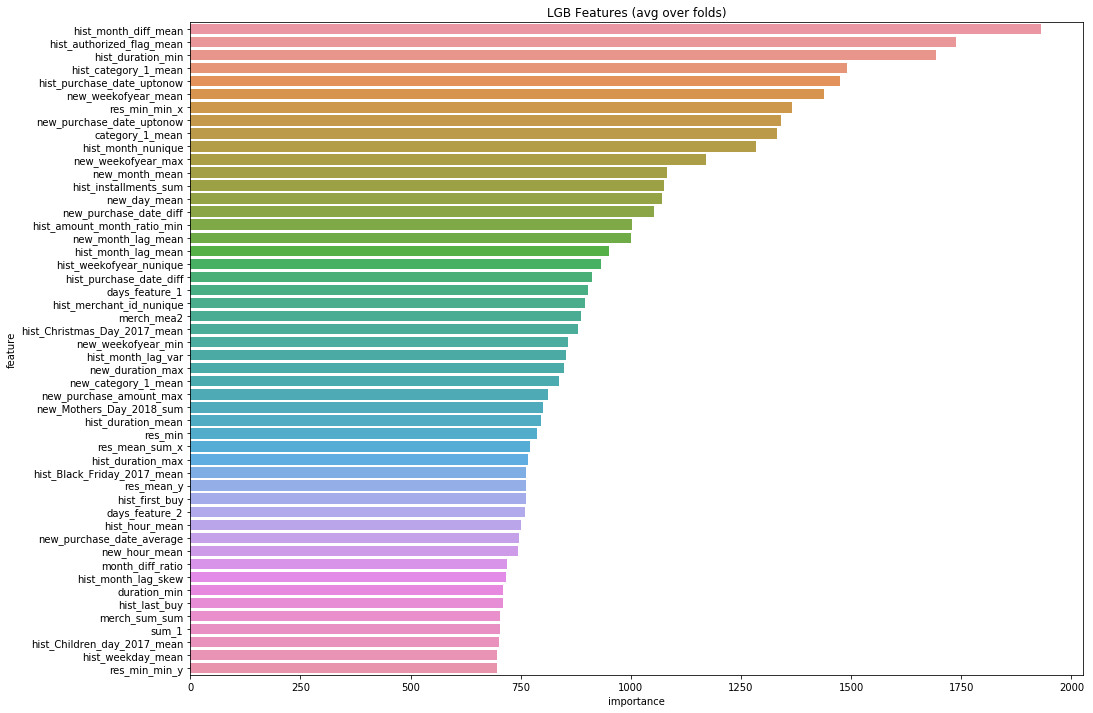

In [493]:
model, pred = model_train_easy(train_df, target, test_df)

In [ ]:
params = {
            #'gpu_use_dp': False, 
            #'gpu_platform_id': 0, 
            #'gpu_device_id': 0, 
            #'device': 'gpu', 
#             'n_estimators': 30000,
            'objective': 'regression_l2', 
            'boosting_type': 'gbdt', 
            'n_jobs': 4, 'max_depth': 7, 
            'n_estimators': 3000, 
            'subsample_freq': 2, 
            'subsample_for_bin': 200000, 
            'min_data_per_group': 100, 
            'max_cat_to_onehot': 4, 
            'cat_l2': 10.0, 
            'cat_smooth': 10.0, 
            'max_cat_threshold': 32, 
            'metric_freq': 10, 
            'verbosity': -1, 
            'metric': 'rmse', 
            'colsample_bytree': 0.5, 
            'learning_rate': 0.0061033234451294376, 
            'min_child_samples': 80, 
            'min_child_weight': 100.0, 
            'min_split_gain': 1e-06, 
            'num_leaves': 47, 
            'reg_alpha': 10.0, 
            'reg_lambda': 10.0, 
            'subsample': 0.9}


In [ ]:
model, pred = model_train_easy(train_df, target, test_df)

In [44]:
card_id_test = pd.read_csv('data/test.csv')['card_id']

In [129]:
pred = model.predict(test_df.drop(columns=['card_id']))

In [132]:
card_id = pd.read_csv('data/test.csv')['card_id']

In [133]:
card_id

0         C_ID_0ab67a22ab
1         C_ID_130fd0cbdd
2         C_ID_b709037bc5
3         C_ID_d27d835a9f
4         C_ID_2b5e3df5c2
5         C_ID_5814b4f13c
6         C_ID_a1b3c75277
7         C_ID_f7cada36d3
8         C_ID_9d2bc8dfc4
9         C_ID_6d8dba8475
10        C_ID_4859ac9ed5
11        C_ID_0e281e8ad6
12        C_ID_8375dfdaa2
13        C_ID_79d149c008
14        C_ID_7f1041e8e1
15        C_ID_f72513589e
16        C_ID_a7f2d6984e
17        C_ID_15489b42d3
18        C_ID_e457bbd71d
19        C_ID_3f74e10c7e
20        C_ID_48243da9c4
21        C_ID_7ea1fcf117
22        C_ID_22e4a47c72
23        C_ID_5d30729184
24        C_ID_b54cfad8b2
25        C_ID_4b82e26faa
26        C_ID_60a453531a
27        C_ID_0c9315feec
28        C_ID_1e28804d36
29        C_ID_68de79f7e2
               ...       
123593    C_ID_cd42a5db89
123594    C_ID_715b9a183d
123595    C_ID_9b25df3309
123596    C_ID_043b3c2ccd
123597    C_ID_7685eae7b2
123598    C_ID_7ee1a21a95
123599    C_ID_2bf12fed6b
123600    C_

In [134]:
subm = pd.DataFrame({'card_id': card_id, 'target': pred})

In [136]:
subm.to_csv('lolecs.csv', index=False)

In [160]:
train_df.drop(columns=['res_mean', 'res_sum', 'res_mean_sum', 'res_sum_sum',
       'res_mean_sum_1', 'res_sum_sum_1'], inplace=True)
test_df.drop(columns=['res_mean', 'res_sum', 'res_mean_sum', 'res_sum_sum',
       'res_mean_sum_1', 'res_sum_sum_1'], inplace=True)

In [84]:
train_df.head(5)

,feature_1,feature_2,feature_3,quarter,elapsed_time,days_feature_1,days_feature_1_ratio,days_feature_2,days_feature_2_ratio,days_feature_3,...,res_max,res_min,res_std,res_mean_sum_y,res_sum_sum_y,res_max_sum,res_min_sum,res_std_sum,res_mean_max,res_sum_max
0,0.013145,0.00875,0.011430,2,604,3020,0.008280,1208,0.003311,604,...,1.083798,0.817779,0.077975,1.069408,14.971707,6.394151,0.403457,1.550849,0.530355,7.424971
1,0.010710,0.01138,0.010284,1,755,3020,0.005300,755,0.001325,0,...,2.059442,0.991272,0.325590,0.385811,5.401358,0.776748,0.124243,0.195041,-0.676948,-9.477271
2,0.010610,0.00875,0.010284,3,908,1816,0.002203,1816,0.002203,0,...,1.680949,0.983631,0.180812,0.501780,7.024921,1.059035,0.145385,0.341979,1.071958,15.007412
3,0.010710,0.01417,0.010284,3,512,2048,0.007812,1536,0.005860,0,...,2.476011,0.931750,0.398316,0.727057,10.178801,2.476011,0.218826,0.572942,0.849228,11.889195
4,0.008060,0.01417,0.010284,4,451,451,0.002218,1353,0.006653,0,...,1.177145,-1.945959,0.786119,0.483931,6.775027,2.017963,-2.001558,0.824960,0.515763,7.220689


In [ ]:
'sum', 'mean', 'max', 'min', 'std'

In [45]:
hist_lag0 = hist[hist['month_lag'] == 0].groupby('card_id')['purchase_amount'].agg(['sum', 'mean', 'max', 'min', 'std']).reset_index()
hist_lag0.columns = ['card_id', 'lag0_sum', 'lag0_mean', 'lag0_max', 'lag0_min', 'lag0_std']

hist_lag1 = hist[hist['month_lag'] == -1].groupby('card_id')['purchase_amount'].agg(['sum', 'mean', 'max', 'min', 'std']).reset_index()
hist_lag1.columns = ['card_id', 'lag1_sum', 'lag1_mean', 'lag1_max', 'lag1_min', 'lag1_std']

hist_lag2 = hist[hist['month_lag'] == -2].groupby('card_id')['purchase_amount'].agg(['sum', 'mean', 'max', 'min', 'std']).reset_index()
hist_lag2.columns = ['card_id', 'lag2_sum', 'lag2_mean', 'lag2_max', 'lag2_min', 'lag2_std']

hist_lag3 = hist[hist['month_lag'] == -3].groupby('card_id')['purchase_amount'].agg(['sum', 'mean', 'max', 'min', 'std']).reset_index()
hist_lag3.columns = ['card_id', 'lag3_sum', 'lag3_mean', 'lag3_max', 'lag3_min', 'lag3_std']

hist_lag4 = hist[hist['month_lag'] == -4].groupby('card_id')['purchase_amount'].agg(['sum', 'mean', 'max', 'min', 'std']).reset_index()
hist_lag4.columns = ['card_id', 'lag4_sum', 'lag4_mean', 'lag4_max', 'lag4_min', 'lag4_std']

hist_lag5 = hist[hist['month_lag'] == -5].groupby('card_id')['purchase_amount'].agg(['sum', 'mean', 'max', 'min', 'std']).reset_index()
hist_lag5.columns = ['card_id', 'lag5_sum', 'lag5_mean', 'lag5_max', 'lag5_min', 'lag5_std']

hist_lag6 = hist[hist['month_lag'] == -6].groupby('card_id')['purchase_amount'].agg(['sum', 'mean', 'max', 'min', 'std']).reset_index()
hist_lag6.columns = ['card_id', 'lag6_sum', 'lag6_mean', 'lag6_max', 'lag6_min', 'lag6_std']

hist_lag7 = hist[hist['month_lag'] == -7].groupby('card_id')['purchase_amount'].agg(['sum', 'mean', 'max', 'min', 'std']).reset_index()
hist_lag7.columns = ['card_id', 'lag7_sum', 'lag7_mean', 'lag7_max', 'lag7_min', 'lag7_std']

hist_lag8 = hist[hist['month_lag'] == -8].groupby('card_id')['purchase_amount'].agg(['sum', 'mean', 'max', 'min', 'std']).reset_index()
hist_lag8.columns = ['card_id', 'lag8_sum', 'lag8_mean', 'lag8_max', 'lag8_min', 'lag8_std']

hist_lag9 = hist[hist['month_lag'] == -9].groupby('card_id')['purchase_amount'].agg(['sum', 'mean', 'max', 'min', 'std']).reset_index()
hist_lag9.columns = ['card_id', 'lag9_sum', 'lag9_mean', 'lag9_max', 'lag9_min', 'lag9_std']

hist_lag10 = hist[hist['month_lag'] == -10].groupby('card_id')['purchase_amount'].agg(['sum', 'mean', 'max', 'min', 'std']).reset_index()
hist_lag10.columns = ['card_id', 'lag10_sum', 'lag10_mean', 'lag10_max', 'lag10_min', 'lag10_std']

hist_lag11 = hist[hist['month_lag'] == -11].groupby('card_id')['purchase_amount'].agg(['sum', 'mean', 'max', 'min', 'std']).reset_index()
hist_lag11.columns = ['card_id', 'lag11_sum', 'lag11_mean', 'lag11_max', 'lag11_min', 'lag11_std']

hist_lag12 = hist[hist['month_lag'] == -12].groupby('card_id')['purchase_amount'].agg(['sum', 'mean', 'max', 'min', 'std']).reset_index()
hist_lag12.columns = ['card_id', 'lag12_sum', 'lag12_mean', 'lag12_max', 'lag12_min', 'lag12_std']

hist_lag13 = hist[hist['month_lag'] == -13].groupby('card_id')['purchase_amount'].agg(['sum', 'mean', 'max', 'min', 'std']).reset_index()
hist_lag13.columns = ['card_id', 'lag13_sum', 'lag13_mean', 'lag13_max', 'lag13_min', 'lag13_std']


new_purch = new.groupby('card_id')['purchase_amount'].agg(['sum', 'mean', 'max', 'min', 'std']).reset_index()
new_purch.columns = ['card_id', 'new_sum', 'new_mean', 'new_max', 'new_min', 'new_std']


In [46]:
new_hist_lag0 = pd.merge(new_purch, hist_lag0, on='card_id', how='left')
new_hist_lag0['res_mean_0'] = new_hist_lag0['new_mean'] / new_hist_lag0['lag0_mean']
new_hist_lag0['res_sum_0'] = new_hist_lag0['new_sum'] / new_hist_lag0['lag0_sum']
new_hist_lag0['res_max_0'] = new_hist_lag0['new_max'] / new_hist_lag0['lag0_max']
new_hist_lag0['res_min_0'] = new_hist_lag0['new_min'] / new_hist_lag0['lag0_min']
new_hist_lag0['res_std_0'] = new_hist_lag0['new_std'] / new_hist_lag0['lag0_std']
lag_0 = pd.DataFrame({'card_id': new_hist_lag0['card_id'], 
                      'res_mean_0': new_hist_lag0['res_mean_0'], 
                      'res_sum_0': new_hist_lag0['res_sum_0'],
                     'res_max_0': new_hist_lag0['res_max_0'],
                     'res_min_0': new_hist_lag0['res_min_0'],
                     'res_std_0': new_hist_lag0['res_std_0']})
lag_0.fillna(lag_0.iloc[:, 1:].median(), inplace=True)
lag_0.replace(np.inf, lag_0.iloc[:, 1:].median(), inplace=True)


In [47]:
new_hist_lag1 = pd.merge(new_purch, hist_lag1, on='card_id', how='left')
new_hist_lag1['res_mean_1'] = new_hist_lag1['new_mean'] / new_hist_lag1['lag1_mean']
new_hist_lag1['res_sum_1'] = new_hist_lag1['new_sum'] / new_hist_lag1['lag1_sum']
new_hist_lag1['res_max_1'] = new_hist_lag1['new_max'] / new_hist_lag1['lag1_max']
new_hist_lag1['res_min_1'] = new_hist_lag1['new_min'] / new_hist_lag1['lag1_min']
new_hist_lag1['res_std_1'] = new_hist_lag1['new_std'] / new_hist_lag1['lag1_std']
lag_1 = pd.DataFrame({'card_id': new_hist_lag1['card_id'], 
                      'res_mean_1': new_hist_lag1['res_mean_1'], 
                      'res_sum_1': new_hist_lag1['res_sum_1'],
                     'res_max_1': new_hist_lag1['res_max_1'],
                     'res_min_1': new_hist_lag1['res_min_1'],
                     'res_std_1': new_hist_lag1['res_std_1']})
lag_1.fillna(lag_1.iloc[:, 1:].median(), inplace=True)
lag_1.replace(np.inf, lag_1.iloc[:, 1:].median(), inplace=True)


In [48]:
new_hist_lag2 = pd.merge(new_purch, hist_lag2, on='card_id', how='left')
new_hist_lag2['res_mean_2'] = new_hist_lag2['new_mean'] / new_hist_lag2['lag2_mean']
new_hist_lag2['res_sum_2'] = new_hist_lag2['new_sum'] / new_hist_lag2['lag2_sum']
new_hist_lag2['res_max_2'] = new_hist_lag2['new_max'] / new_hist_lag2['lag2_max']
new_hist_lag2['res_min_2'] = new_hist_lag2['new_min'] / new_hist_lag2['lag2_min']
new_hist_lag2['res_std_2'] = new_hist_lag2['new_std'] / new_hist_lag2['lag2_std']
lag_2 = pd.DataFrame({'card_id': new_hist_lag2['card_id'], 
                      'res_mean_2': new_hist_lag2['res_mean_2'], 
                      'res_sum_2': new_hist_lag2['res_sum_2'],
                     'res_max_2': new_hist_lag2['res_max_2'],
                     'res_min_2': new_hist_lag2['res_min_2'],
                     'res_std_2': new_hist_lag2['res_std_2']})
lag_2.fillna(lag_2.iloc[:, 1:].median(), inplace=True)
lag_2.replace(np.inf, lag_2.iloc[:, 1:].median(), inplace=True)


In [49]:
new_hist_lag3 = pd.merge(new_purch, hist_lag3, on='card_id', how='left')
new_hist_lag3['res_mean_3'] = new_hist_lag3['new_mean'] / new_hist_lag3['lag3_mean']
new_hist_lag3['res_sum_3'] = new_hist_lag3['new_sum'] / new_hist_lag3['lag3_sum']
new_hist_lag3['res_max_3'] = new_hist_lag3['new_max'] / new_hist_lag3['lag3_max']
new_hist_lag3['res_min_3'] = new_hist_lag3['new_min'] / new_hist_lag3['lag3_min']
new_hist_lag3['res_std_3'] = new_hist_lag3['new_std'] / new_hist_lag3['lag3_std']
lag_3 = pd.DataFrame({'card_id': new_hist_lag3['card_id'], 
                      'res_mean_3': new_hist_lag3['res_mean_3'], 
                      'res_sum_3': new_hist_lag3['res_sum_3'],
                     'res_max_3': new_hist_lag3['res_max_3'],
                     'res_min_3': new_hist_lag3['res_min_3'],
                     'res_std_3': new_hist_lag3['res_std_3']})
lag_3.fillna(lag_3.iloc[:, 1:].median(), inplace=True)
lag_3.replace(np.inf, lag_3.iloc[:, 1:].median(), inplace=True)


In [50]:
new_hist_lag4 = pd.merge(new_purch, hist_lag4, on='card_id', how='left')
new_hist_lag4['res_mean_4'] = new_hist_lag4['new_mean'] / new_hist_lag4['lag4_mean']
new_hist_lag4['res_sum_4'] = new_hist_lag4['new_sum'] / new_hist_lag4['lag4_sum']
new_hist_lag4['res_max_4'] = new_hist_lag4['new_max'] / new_hist_lag4['lag4_max']
new_hist_lag4['res_min_4'] = new_hist_lag4['new_min'] / new_hist_lag4['lag4_min']
new_hist_lag4['res_std_4'] = new_hist_lag4['new_std'] / new_hist_lag4['lag4_std']
lag_4 = pd.DataFrame({'card_id': new_hist_lag4['card_id'], 
                      'res_mean_4': new_hist_lag4['res_mean_4'], 
                      'res_sum_4': new_hist_lag4['res_sum_4'],
                     'res_max_4': new_hist_lag4['res_max_4'],
                     'res_min_4': new_hist_lag4['res_min_4'],
                     'res_std_4': new_hist_lag4['res_std_4']})
lag_4.fillna(lag_4.iloc[:, 1:].median(), inplace=True)
lag_4.replace(np.inf, lag_4.iloc[:, 1:].median(), inplace=True)


In [51]:
new_hist_lag5 = pd.merge(new_purch, hist_lag5, on='card_id', how='left')
new_hist_lag5['res_mean_5'] = new_hist_lag5['new_mean'] / new_hist_lag5['lag5_mean']
new_hist_lag5['res_sum_5'] = new_hist_lag5['new_sum'] / new_hist_lag5['lag5_sum']
new_hist_lag5['res_max_5'] = new_hist_lag5['new_max'] / new_hist_lag5['lag5_max']
new_hist_lag5['res_min_5'] = new_hist_lag5['new_min'] / new_hist_lag5['lag5_min']
new_hist_lag5['res_std_5'] = new_hist_lag5['new_std'] / new_hist_lag5['lag5_std']
lag_5 = pd.DataFrame({'card_id': new_hist_lag5['card_id'], 
                      'res_mean_5': new_hist_lag5['res_mean_5'], 
                      'res_sum_5': new_hist_lag5['res_sum_5'],
                     'res_max_5': new_hist_lag5['res_max_5'],
                     'res_min_5': new_hist_lag5['res_min_5'],
                     'res_std_5': new_hist_lag5['res_std_5']})
lag_5.fillna(lag_5.iloc[:, 1:].median(), inplace=True)
lag_5.replace(np.inf, lag_5.iloc[:, 1:].median(), inplace=True)


In [52]:
new_hist_lag6 = pd.merge(new_purch, hist_lag6, on='card_id', how='left')
new_hist_lag6['res_mean_6'] = new_hist_lag6['new_mean'] / new_hist_lag6['lag6_mean']
new_hist_lag6['res_sum_6'] = new_hist_lag6['new_sum'] / new_hist_lag6['lag6_sum']
new_hist_lag6['res_max_6'] = new_hist_lag6['new_max'] / new_hist_lag6['lag6_max']
new_hist_lag6['res_min_6'] = new_hist_lag6['new_min'] / new_hist_lag6['lag6_min']
new_hist_lag6['res_std_6'] = new_hist_lag6['new_std'] / new_hist_lag6['lag6_std']
lag_6 = pd.DataFrame({'card_id': new_hist_lag6['card_id'], 
                      'res_mean_6': new_hist_lag6['res_mean_6'], 
                      'res_sum_6': new_hist_lag6['res_sum_6'],
                     'res_max_6': new_hist_lag6['res_max_6'],
                     'res_min_6': new_hist_lag6['res_min_6'],
                     'res_std_6': new_hist_lag6['res_std_6']})
lag_6.fillna(lag_6.iloc[:, 1:].median(), inplace=True)
lag_6.replace(np.inf, lag_6.iloc[:, 1:].median(), inplace=True)


In [53]:
new_hist_lag7 = pd.merge(new_purch, hist_lag7, on='card_id', how='left')
new_hist_lag7['res_mean_7'] = new_hist_lag7['new_mean'] / new_hist_lag7['lag7_mean']
new_hist_lag7['res_sum_7'] = new_hist_lag7['new_sum'] / new_hist_lag7['lag7_sum']
new_hist_lag7['res_max_7'] = new_hist_lag7['new_max'] / new_hist_lag7['lag7_max']
new_hist_lag7['res_min_7'] = new_hist_lag7['new_min'] / new_hist_lag7['lag7_min']
new_hist_lag7['res_std_7'] = new_hist_lag7['new_std'] / new_hist_lag7['lag7_std']
lag_7 = pd.DataFrame({'card_id': new_hist_lag7['card_id'], 
                      'res_mean_7': new_hist_lag7['res_mean_7'], 
                      'res_sum_7': new_hist_lag7['res_sum_7'],
                     'res_max_7': new_hist_lag7['res_max_7'],
                     'res_min_7': new_hist_lag7['res_min_7'],
                     'res_std_7': new_hist_lag7['res_std_7']})
lag_7.fillna(lag_7.iloc[:, 1:].median(), inplace=True)
lag_7.replace(np.inf, lag_7.iloc[:, 1:].median(), inplace=True)


In [54]:
new_hist_lag8 = pd.merge(new_purch, hist_lag8, on='card_id', how='left')
new_hist_lag8['res_mean_8'] = new_hist_lag8['new_mean'] / new_hist_lag8['lag8_mean']
new_hist_lag8['res_sum_8'] = new_hist_lag8['new_sum'] / new_hist_lag8['lag8_sum']
new_hist_lag8['res_max_8'] = new_hist_lag8['new_max'] / new_hist_lag8['lag8_max']
new_hist_lag8['res_min_8'] = new_hist_lag8['new_min'] / new_hist_lag8['lag8_min']
new_hist_lag8['res_std_8'] = new_hist_lag8['new_std'] / new_hist_lag8['lag8_std']
lag_8 = pd.DataFrame({'card_id': new_hist_lag8['card_id'], 
                      'res_mean_8': new_hist_lag8['res_mean_8'], 
                      'res_sum_8': new_hist_lag8['res_sum_8'],
                     'res_max_8': new_hist_lag8['res_max_8'],
                     'res_min_8': new_hist_lag8['res_min_8'],
                     'res_std_8': new_hist_lag8['res_std_8']})
lag_8.fillna(lag_8.iloc[:, 1:].median(), inplace=True)
lag_8.replace(np.inf, lag_8.iloc[:, 1:].median(), inplace=True)


In [55]:
new_hist_lag9 = pd.merge(new_purch, hist_lag9, on='card_id', how='left')
new_hist_lag9['res_mean_9'] = new_hist_lag9['new_mean'] / new_hist_lag9['lag9_mean']
new_hist_lag9['res_sum_9'] = new_hist_lag9['new_sum'] / new_hist_lag9['lag9_sum']
new_hist_lag9['res_max_9'] = new_hist_lag9['new_max'] / new_hist_lag9['lag9_max']
new_hist_lag9['res_min_9'] = new_hist_lag9['new_min'] / new_hist_lag9['lag9_min']
new_hist_lag9['res_std_9'] = new_hist_lag9['new_std'] / new_hist_lag9['lag9_std']
lag_9 = pd.DataFrame({'card_id': new_hist_lag9['card_id'], 
                      'res_mean_9': new_hist_lag9['res_mean_9'], 
                      'res_sum_9': new_hist_lag9['res_sum_9'],
                     'res_max_9': new_hist_lag9['res_max_9'],
                     'res_min_9': new_hist_lag9['res_min_9'],
                     'res_std_9': new_hist_lag9['res_std_9']})
lag_9.fillna(lag_9.iloc[:, 1:].median(), inplace=True)
lag_9.replace(np.inf, lag_9.iloc[:, 1:].median(), inplace=True)


In [56]:
new_hist_lag10 = pd.merge(new_purch, hist_lag10, on='card_id', how='left')
new_hist_lag10['res_mean_10'] = new_hist_lag10['new_mean'] / new_hist_lag10['lag10_mean']
new_hist_lag10['res_sum_10'] = new_hist_lag10['new_sum'] / new_hist_lag10['lag10_sum']
new_hist_lag10['res_max_10'] = new_hist_lag10['new_max'] / new_hist_lag10['lag10_max']
new_hist_lag10['res_min_10'] = new_hist_lag10['new_min'] / new_hist_lag10['lag10_min']
new_hist_lag10['res_std_10'] = new_hist_lag10['new_std'] / new_hist_lag10['lag10_std']
lag_10 = pd.DataFrame({'card_id': new_hist_lag10['card_id'], 
                      'res_mean_10': new_hist_lag10['res_mean_10'], 
                      'res_sum_10': new_hist_lag10['res_sum_10'],
                     'res_max_10': new_hist_lag10['res_max_10'],
                     'res_min_10': new_hist_lag10['res_min_10'],
                     'res_std_10': new_hist_lag10['res_std_10']})
lag_10.fillna(lag_10.iloc[:, 1:].median(), inplace=True)
lag_10.replace(np.inf, lag_10.iloc[:, 1:].median(), inplace=True)


In [302]:
new_hist_lag11 = pd.merge(new_purch, hist_lag11, on='card_id', how='left')
new_hist_lag11['res_mean_11'] = new_hist_lag11['new_mean'] / new_hist_lag11['lag11_mean']
new_hist_lag11['res_sum_11'] = new_hist_lag11['new_sum'] / new_hist_lag11['lag11_sum']
new_hist_lag11['res_max_11'] = new_hist_lag11['new_max'] / new_hist_lag11['lag11_max']
new_hist_lag11['res_min_11'] = new_hist_lag11['new_min'] / new_hist_lag11['lag11_min']
new_hist_lag11['res_std_11'] = new_hist_lag11['new_std'] / new_hist_lag11['lag11_std']
lag_11 = pd.DataFrame({'card_id': new_hist_lag11['card_id'], 
                      'res_mean_11': new_hist_lag11['res_mean_11'], 
                      'res_sum_11': new_hist_lag11['res_sum_11'],
                     'res_max_11': new_hist_lag11['res_max_11'],
                     'res_min_11': new_hist_lag11['res_min_11'],
                     'res_std_11': new_hist_lag11['res_std_11']})
lag_11.fillna(lag_11.iloc[:, 1:].median(), inplace=True)
lag_11.replace(np.inf, lag_11.iloc[:, 1:].median(), inplace=True)


In [57]:
new_hist_lag12 = pd.merge(new_purch, hist_lag12, on='card_id', how='left')
new_hist_lag12['res_mean_12'] = new_hist_lag12['new_mean'] / new_hist_lag12['lag12_mean']
new_hist_lag12['res_sum_12'] = new_hist_lag12['new_sum'] / new_hist_lag12['lag12_sum']
new_hist_lag12['res_max_12'] = new_hist_lag12['new_max'] / new_hist_lag12['lag12_max']
new_hist_lag12['res_min_12'] = new_hist_lag12['new_min'] / new_hist_lag12['lag12_min']
new_hist_lag12['res_std_12'] = new_hist_lag12['new_std'] / new_hist_lag12['lag12_std']
lag_12 = pd.DataFrame({'card_id': new_hist_lag12['card_id'], 
                      'res_mean_12': new_hist_lag12['res_mean_12'], 
                      'res_sum_12': new_hist_lag12['res_sum_12'],
                     'res_max_12': new_hist_lag12['res_max_12'],
                     'res_min_12': new_hist_lag12['res_min_12'],
                     'res_std_12': new_hist_lag12['res_std_12']})
lag_12.fillna(lag_12.iloc[:, 1:].median(), inplace=True)
lag_12.replace(np.inf, lag_12.iloc[:, 1:].median(), inplace=True)


In [58]:
new_hist_lag13 = pd.merge(new_purch, hist_lag13, on='card_id', how='left')
new_hist_lag13['res_mean_13'] = new_hist_lag13['new_mean'] / new_hist_lag13['lag13_mean']
new_hist_lag13['res_sum_13'] = new_hist_lag13['new_sum'] / new_hist_lag13['lag13_sum']
new_hist_lag13['res_max_13'] = new_hist_lag13['new_max'] / new_hist_lag13['lag13_max']
new_hist_lag13['res_min_13'] = new_hist_lag13['new_min'] / new_hist_lag13['lag13_min']
new_hist_lag13['res_std_13'] = new_hist_lag13['new_std'] / new_hist_lag13['lag13_std']
lag_13 = pd.DataFrame({'card_id': new_hist_lag13['card_id'], 
                      'res_mean_13': new_hist_lag13['res_mean_13'], 
                      'res_sum_13': new_hist_lag13['res_sum_13'],
                     'res_max_13': new_hist_lag13['res_max_13'],
                     'res_min_13': new_hist_lag13['res_min_13'],
                     'res_std_13': new_hist_lag13['res_std_13']})
lag_13.fillna(lag_13.iloc[:, 1:].median(), inplace=True)
lag_13.replace(np.inf, lag_13.iloc[:, 1:].median(), inplace=True)


In [59]:
lag = pd.concat([lag_0, lag_1, lag_2, lag_3, lag_4, lag_5,
                 lag_6, lag_7, lag_8, lag_9, lag_10, lag_11, lag_12, lag_13], axis=0)

In [60]:
lag['res_mean'] = 0

sc2 = lag_0.shape[0]
lag['res_mean'].iloc[:sc2] = lag['res_mean_0'].iloc[:sc2]

sc1 = lag_0.shape[0]
sc2 = sc1 + lag_1.shape[0]
lag['res_mean'].iloc[sc1:sc2] = lag['res_mean_1'].iloc[sc1:sc2]

sc1 = sc2
sc2 = sc2 + lag_2.shape[0]
lag['res_mean'].iloc[sc1:sc2] = lag['res_mean_2'].iloc[sc1:sc2]

sc1 = sc2
sc2 = sc2 + lag_3.shape[0]
lag['res_mean'].iloc[sc1:sc2] = lag['res_mean_3'].iloc[sc1:sc2]

sc1 = sc2
sc2 = sc2 + lag_4.shape[0]
lag['res_mean'].iloc[sc1:sc2] = lag['res_mean_4'].iloc[sc1:sc2]

sc1 = sc2
sc2 = sc2 + lag_5.shape[0]
lag['res_mean'].iloc[sc1:sc2] = lag['res_mean_5'].iloc[sc1:sc2]

sc1 = sc2
sc2 = sc2 + lag_6.shape[0]
lag['res_mean'].iloc[sc1:sc2] = lag['res_mean_6'].iloc[sc1:sc2]

sc1 = sc2
sc2 = sc2 + lag_7.shape[0]
lag['res_mean'].iloc[sc1:sc2] = lag['res_mean_7'].iloc[sc1:sc2]

sc1 = sc2
sc2 = sc2 + lag_8.shape[0]
lag['res_mean'].iloc[sc1:sc2] = lag['res_mean_8'].iloc[sc1:sc2]

sc1 = sc2
sc2 = sc2 + lag_9.shape[0]
lag['res_mean'].iloc[sc1:sc2] = lag['res_mean_9'].iloc[sc1:sc2]

sc1 = sc2
sc2 = sc2 + lag_10.shape[0]
lag['res_mean'].iloc[sc1:sc2] = lag['res_mean_10'].iloc[sc1:sc2]

sc1 = sc2
sc2 = sc2 + lag_11.shape[0]
lag['res_mean'].iloc[sc1:sc2] = lag['res_mean_11'].iloc[sc1:sc2]

sc1 = sc2
sc2 = sc2 + lag_12.shape[0]
lag['res_mean'].iloc[sc1:sc2] = lag['res_mean_12'].iloc[sc1:sc2]

sc1 = sc2
sc2 = sc2 + lag_13.shape[0]
lag['res_mean'].iloc[sc1:sc2] = lag['res_mean_13'].iloc[sc1:sc2]

# lag['res_mean'].iloc[lag_4.shape[0]:lag_5.shape[0]] = lag['res_mean_5'].iloc[lag_4.shape[0]:lag_5.shape[0]]
# lag['res_mean'].iloc[lag_5.shape[0]:lag_6.shape[0]] = lag['res_mean_6'].iloc[lag_5.shape[0]:lag_6.shape[0]]
# lag['res_mean'].iloc[lag_6.shape[0]:lag_7.shape[0]] = lag['res_mean_7'].iloc[lag_6.shape[0]:lag_7.shape[0]]
# lag['res_mean'].iloc[lag_7.shape[0]:lag_8.shape[0]] = lag['res_mean_8'].iloc[lag_7.shape[0]:lag_8.shape[0]]
# lag['res_mean'].iloc[lag_8.shape[0]:lag_9.shape[0]] = lag['res_mean_9'].iloc[lag_8.shape[0]:lag_9.shape[0]]
# lag['res_mean'].iloc[lag_9.shape[0]:lag_10.shape[0]] = lag['res_mean_10'].iloc[lag_9.shape[0]:lag_10.shape[0]]
# lag['res_mean'].iloc[lag_10.shape[0]:lag_11.shape[0]] = lag['res_mean_11'].iloc[lag_10.shape[0]:lag_11.shape[0]]
# lag['res_mean'].iloc[lag_11.shape[0]:lag_12.shape[0]] = lag['res_mean_12'].iloc[lag_11.shape[0]:lag_12.shape[0]]
# lag['res_mean'].iloc[lag_11.shape[0]:lag_13.shape[0]] = lag['res_mean_13'].iloc[lag_12.shape[0]:lag_13.shape[0]]

In [61]:
lag['res_sum'] = 0

sc2 = lag_0.shape[0]
lag['res_sum'].iloc[:sc2] = lag['res_sum_0'].iloc[:sc2]

sc1 = lag_0.shape[0]
sc2 = sc1 + lag_1.shape[0]
lag['res_sum'].iloc[sc1:sc2] = lag['res_sum_1'].iloc[sc1:sc2]

sc1 = sc2
sc2 = sc2 + lag_2.shape[0]
lag['res_sum'].iloc[sc1:sc2] = lag['res_sum_2'].iloc[sc1:sc2]

sc1 = sc2
sc2 = sc2 + lag_3.shape[0]
lag['res_sum'].iloc[sc1:sc2] = lag['res_sum_3'].iloc[sc1:sc2]

sc1 = sc2
sc2 = sc2 + lag_4.shape[0]
lag['res_sum'].iloc[sc1:sc2] = lag['res_sum_4'].iloc[sc1:sc2]

sc1 = sc2
sc2 = sc2 + lag_5.shape[0]
lag['res_sum'].iloc[sc1:sc2] = lag['res_sum_5'].iloc[sc1:sc2]

sc1 = sc2
sc2 = sc2 + lag_6.shape[0]
lag['res_sum'].iloc[sc1:sc2] = lag['res_sum_6'].iloc[sc1:sc2]

sc1 = sc2
sc2 = sc2 + lag_7.shape[0]
lag['res_sum'].iloc[sc1:sc2] = lag['res_sum_7'].iloc[sc1:sc2]

sc1 = sc2
sc2 = sc2 + lag_8.shape[0]
lag['res_sum'].iloc[sc1:sc2] = lag['res_sum_8'].iloc[sc1:sc2]

sc1 = sc2
sc2 = sc2 + lag_9.shape[0]
lag['res_sum'].iloc[sc1:sc2] = lag['res_sum_9'].iloc[sc1:sc2]

sc1 = sc2
sc2 = sc2 + lag_10.shape[0]
lag['res_sum'].iloc[sc1:sc2] = lag['res_sum_10'].iloc[sc1:sc2]

sc1 = sc2
sc2 = sc2 + lag_11.shape[0]
lag['res_sum'].iloc[sc1:sc2] = lag['res_sum_11'].iloc[sc1:sc2]

sc1 = sc2
sc2 = sc2 + lag_12.shape[0]
lag['res_sum'].iloc[sc1:sc2] = lag['res_sum_12'].iloc[sc1:sc2]

sc1 = sc2
sc2 = sc2 + lag_13.shape[0]
lag['res_sum'].iloc[sc1:sc2] = lag['res_sum_13'].iloc[sc1:sc2]

In [62]:
lag['res_max'] = 0

sc2 = lag_0.shape[0]
lag['res_max'].iloc[:sc2] = lag['res_max_0'].iloc[:sc2]

sc1 = lag_0.shape[0]
sc2 = sc1 + lag_1.shape[0]
lag['res_max'].iloc[sc1:sc2] = lag['res_max_1'].iloc[sc1:sc2]

sc1 = sc2
sc2 = sc2 + lag_2.shape[0]
lag['res_max'].iloc[sc1:sc2] = lag['res_max_2'].iloc[sc1:sc2]

sc1 = sc2
sc2 = sc2 + lag_3.shape[0]
lag['res_max'].iloc[sc1:sc2] = lag['res_max_3'].iloc[sc1:sc2]

sc1 = sc2
sc2 = sc2 + lag_4.shape[0]
lag['res_max'].iloc[sc1:sc2] = lag['res_max_4'].iloc[sc1:sc2]

sc1 = sc2
sc2 = sc2 + lag_5.shape[0]
lag['res_max'].iloc[sc1:sc2] = lag['res_max_5'].iloc[sc1:sc2]

sc1 = sc2
sc2 = sc2 + lag_6.shape[0]
lag['res_max'].iloc[sc1:sc2] = lag['res_max_6'].iloc[sc1:sc2]

sc1 = sc2
sc2 = sc2 + lag_7.shape[0]
lag['res_max'].iloc[sc1:sc2] = lag['res_max_7'].iloc[sc1:sc2]

sc1 = sc2
sc2 = sc2 + lag_8.shape[0]
lag['res_max'].iloc[sc1:sc2] = lag['res_max_8'].iloc[sc1:sc2]

sc1 = sc2
sc2 = sc2 + lag_9.shape[0]
lag['res_max'].iloc[sc1:sc2] = lag['res_max_9'].iloc[sc1:sc2]

sc1 = sc2
sc2 = sc2 + lag_10.shape[0]
lag['res_max'].iloc[sc1:sc2] = lag['res_max_10'].iloc[sc1:sc2]

sc1 = sc2
sc2 = sc2 + lag_11.shape[0]
lag['res_max'].iloc[sc1:sc2] = lag['res_max_11'].iloc[sc1:sc2]

sc1 = sc2
sc2 = sc2 + lag_12.shape[0]
lag['res_max'].iloc[sc1:sc2] = lag['res_max_12'].iloc[sc1:sc2]

sc1 = sc2
sc2 = sc2 + lag_13.shape[0]
lag['res_max'].iloc[sc1:sc2] = lag['res_max_13'].iloc[sc1:sc2]

KeyError: 'res_max_11'

In [ ]:
lag['res_min'] = 0

sc2 = lag_0.shape[0]
lag['res_min'].iloc[:sc2] = lag['res_min_0'].iloc[:sc2]

sc1 = lag_0.shape[0]
sc2 = sc1 + lag_1.shape[0]
lag['res_min'].iloc[sc1:sc2] = lag['res_min_1'].iloc[sc1:sc2]

sc1 = sc2
sc2 = sc2 + lag_2.shape[0]
lag['res_min'].iloc[sc1:sc2] = lag['res_min_2'].iloc[sc1:sc2]

sc1 = sc2
sc2 = sc2 + lag_3.shape[0]
lag['res_min'].iloc[sc1:sc2] = lag['res_min_3'].iloc[sc1:sc2]

sc1 = sc2
sc2 = sc2 + lag_4.shape[0]
lag['res_min'].iloc[sc1:sc2] = lag['res_min_4'].iloc[sc1:sc2]

sc1 = sc2
sc2 = sc2 + lag_5.shape[0]
lag['res_min'].iloc[sc1:sc2] = lag['res_min_5'].iloc[sc1:sc2]

sc1 = sc2
sc2 = sc2 + lag_6.shape[0]
lag['res_min'].iloc[sc1:sc2] = lag['res_min_6'].iloc[sc1:sc2]

sc1 = sc2
sc2 = sc2 + lag_7.shape[0]
lag['res_min'].iloc[sc1:sc2] = lag['res_min_7'].iloc[sc1:sc2]

sc1 = sc2
sc2 = sc2 + lag_8.shape[0]
lag['res_min'].iloc[sc1:sc2] = lag['res_min_8'].iloc[sc1:sc2]

sc1 = sc2
sc2 = sc2 + lag_9.shape[0]
lag['res_min'].iloc[sc1:sc2] = lag['res_min_9'].iloc[sc1:sc2]

sc1 = sc2
sc2 = sc2 + lag_10.shape[0]
lag['res_min'].iloc[sc1:sc2] = lag['res_min_10'].iloc[sc1:sc2]

sc1 = sc2
sc2 = sc2 + lag_11.shape[0]
lag['res_min'].iloc[sc1:sc2] = lag['res_min_11'].iloc[sc1:sc2]

sc1 = sc2
sc2 = sc2 + lag_12.shape[0]
lag['res_min'].iloc[sc1:sc2] = lag['res_min_12'].iloc[sc1:sc2]

sc1 = sc2
sc2 = sc2 + lag_13.shape[0]
lag['res_min'].iloc[sc1:sc2] = lag['res_min_13'].iloc[sc1:sc2]

In [ ]:
lag['res_std'] = 0

sc2 = lag_0.shape[0]
lag['res_std'].iloc[:sc2] = lag['res_std_0'].iloc[:sc2]

sc1 = lag_0.shape[0]
sc2 = sc1 + lag_1.shape[0]
lag['res_std'].iloc[sc1:sc2] = lag['res_std_1'].iloc[sc1:sc2]

sc1 = sc2
sc2 = sc2 + lag_2.shape[0]
lag['res_std'].iloc[sc1:sc2] = lag['res_std_2'].iloc[sc1:sc2]

sc1 = sc2
sc2 = sc2 + lag_3.shape[0]
lag['res_std'].iloc[sc1:sc2] = lag['res_std_3'].iloc[sc1:sc2]

sc1 = sc2
sc2 = sc2 + lag_4.shape[0]
lag['res_std'].iloc[sc1:sc2] = lag['res_std_4'].iloc[sc1:sc2]

sc1 = sc2
sc2 = sc2 + lag_5.shape[0]
lag['res_std'].iloc[sc1:sc2] = lag['res_std_5'].iloc[sc1:sc2]

sc1 = sc2
sc2 = sc2 + lag_6.shape[0]
lag['res_std'].iloc[sc1:sc2] = lag['res_std_6'].iloc[sc1:sc2]

sc1 = sc2
sc2 = sc2 + lag_7.shape[0]
lag['res_std'].iloc[sc1:sc2] = lag['res_std_7'].iloc[sc1:sc2]

sc1 = sc2
sc2 = sc2 + lag_8.shape[0]
lag['res_std'].iloc[sc1:sc2] = lag['res_std_8'].iloc[sc1:sc2]

sc1 = sc2
sc2 = sc2 + lag_9.shape[0]
lag['res_std'].iloc[sc1:sc2] = lag['res_std_9'].iloc[sc1:sc2]

sc1 = sc2
sc2 = sc2 + lag_10.shape[0]
lag['res_std'].iloc[sc1:sc2] = lag['res_std_10'].iloc[sc1:sc2]

sc1 = sc2
sc2 = sc2 + lag_11.shape[0]
lag['res_std'].iloc[sc1:sc2] = lag['res_std_11'].iloc[sc1:sc2]

sc1 = sc2
sc2 = sc2 + lag_12.shape[0]
lag['res_std'].iloc[sc1:sc2] = lag['res_std_12'].iloc[sc1:sc2]

sc1 = sc2
sc2 = sc2 + lag_13.shape[0]
lag['res_std'].iloc[sc1:sc2] = lag['res_std_13'].iloc[sc1:sc2]

In [ ]:
lag.columns

In [63]:
lag_f = lag.groupby('card_id')['res_mean'].agg(['mean', 'sum', 'max', 'min', 'std']).reset_index()
lag_f.columns = ['card_id', 'res_mean', 'res_sum', 'res_max', 'res_min', 'res_std']

lag_f.head(5)

,card_id,res_mean,res_sum,res_max,res_min,res_std
0,C_ID_00007093c1,1.336887,18.716416,1.991172,0.991272,0.321951
1,C_ID_0001238066,0.972047,13.608664,1.093372,0.876824,0.051587
2,C_ID_0001506ef0,-1.158810,-16.223344,6.660213,-42.097901,11.894385
3,C_ID_0001793786,0.320839,4.491751,0.991272,-0.038731,0.447102
4,C_ID_000183fdda,2.199241,30.789371,15.848026,0.947290,3.944008


In [64]:
lag_f_sum = lag.groupby('card_id')['res_sum'].agg(['mean', 'sum', 'max', 'min', 'std']).reset_index()
lag_f_sum.columns = ['card_id', 'res_mean_sum', 'res_sum_sum', 'res_max_sum', 'res_min_sum', 'res_std_sum']

lag_f_sum.head(5)

,card_id,res_mean_sum,res_sum_sum,res_max_sum,res_min_sum,res_std_sum
0,C_ID_00007093c1,0.320535,4.487486,0.995586,0.127460,0.230174
1,C_ID_0001238066,1.531877,21.446282,11.398713,0.490684,2.877356
2,C_ID_0001506ef0,-1.631519,-22.841272,6.660213,-42.097901,11.792284
3,C_ID_0001793786,0.138546,1.939649,0.520280,-0.554242,0.318078
4,C_ID_000183fdda,2.662753,37.278546,29.054714,0.421433,7.606537


In [65]:
train_df, test_df = add_card_id()

In [66]:
train_df = pd.merge(train_df, lag_f, on='card_id', how='left')
train_df = pd.merge(train_df, lag_f_sum, on='card_id', how='left')

test_df = pd.merge(test_df, lag_f, on='card_id', how='left')
test_df = pd.merge(test_df, lag_f_sum, on='card_id', how='left')

In [67]:
train_df, test_df = drop_card_id()

In [320]:
train_df.drop(columns=['res_max', 'res_min', 'res_std', 'res_max_sum', 'res_min_sum', 'res_std_sum'], inplace=True)
test_df.drop(columns=['res_max', 'res_min', 'res_std', 'res_max_sum', 'res_min_sum', 'res_std_sum'], inplace=True)

In [323]:
train_df.fillna(train_df.median(), inplace=True)
test_df.fillna(test_df.median(), inplace=True)

Training until validation scores don't improve for 500 rounds.
[100]	training's rmse: 3.72401
[200]	training's rmse: 3.6632
[300]	training's rmse: 3.62621
[400]	training's rmse: 3.60054
[500]	training's rmse: 3.58083
[600]	training's rmse: 3.56521
[700]	training's rmse: 3.55078
[800]	training's rmse: 3.53849
[900]	training's rmse: 3.52695
[1000]	training's rmse: 3.51665
[1100]	training's rmse: 3.50684
[1200]	training's rmse: 3.49715
[1300]	training's rmse: 3.4887
[1400]	training's rmse: 3.48049
[1500]	training's rmse: 3.47216
[1600]	training's rmse: 3.46423
[1700]	training's rmse: 3.45638
[1800]	training's rmse: 3.44861
[1900]	training's rmse: 3.44111
[2000]	training's rmse: 3.43338
Did not meet early stopping. Best iteration is:
[2000]	training's rmse: 3.43338


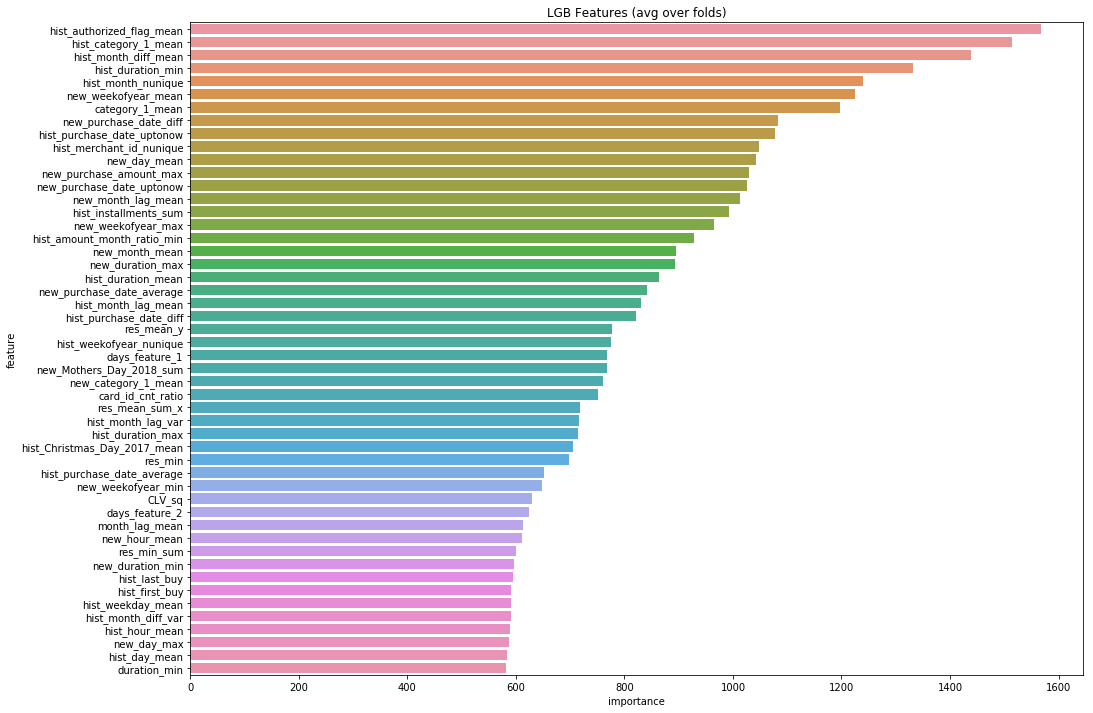

In [68]:
pred, model = model_train_easy(train_df, target, test_df)

In [69]:
train_df, test_df = add_card_id()

In [70]:
lag_f_max = lag.groupby('card_id')['res_max'].agg(['mean', 'sum']).reset_index()
lag_f_max.columns = ['card_id', 'res_mean_max', 'res_sum_max']

In [71]:
lag_f_min = lag.groupby('card_id')['res_min'].agg(['mean', 'sum']).reset_index()
lag_f_min.columns = ['card_id', 'res_mean_min', 'res_sum_min']

KeyError: 'Column not found: res_min'

In [72]:
lag_f_std = lag.groupby('card_id')['res_std'].agg(['mean', 'sum']).reset_index()
lag_f_std.columns = ['card_id', 'res_mean_std', 'res_sum_std']

KeyError: 'Column not found: res_std'

In [73]:
train_df = pd.merge(train_df, lag_f_max, on='card_id', how='left')
# train_df = pd.merge(train_df, lag_f_min, on='card_id', how='left')

test_df = pd.merge(test_df, lag_f_max, on='card_id', how='left')
# test_df = pd.merge(test_df, lag_f_min, on='card_id', how='left')

# train_df = pd.merge(train_df, lag_f_std, on='card_id', how='left')
# test_df = pd.merge(test_df, lag_f_std, on='card_id', how='left')


In [74]:
train_df = train_df.fillna(train_df.median())
test_df = test_df.fillna(test_df.median())

In [275]:
print((train_df.shape))
print(test_df.shape)

(201917, 221)
(123623, 221)


In [75]:
train_df, test_df = drop_card_id()

Training until validation scores don't improve for 500 rounds.
[100]	training's rmse: 3.72011
[200]	training's rmse: 3.65326
[300]	training's rmse: 3.61075
[400]	training's rmse: 3.58069
[500]	training's rmse: 3.55683
[600]	training's rmse: 3.53747
[700]	training's rmse: 3.52108
[800]	training's rmse: 3.50576
[900]	training's rmse: 3.49186
[1000]	training's rmse: 3.47899
[1100]	training's rmse: 3.46683
[1200]	training's rmse: 3.45535
[1300]	training's rmse: 3.44447
[1400]	training's rmse: 3.43404
[1500]	training's rmse: 3.42372
[1600]	training's rmse: 3.41357
[1700]	training's rmse: 3.40374
[1800]	training's rmse: 3.39402
[1900]	training's rmse: 3.38466
[2000]	training's rmse: 3.37525
[2100]	training's rmse: 3.36628
[2200]	training's rmse: 3.35784
[2300]	training's rmse: 3.34885
[2400]	training's rmse: 3.34053
[2500]	training's rmse: 3.33189
[2600]	training's rmse: 3.32331
[2700]	training's rmse: 3.31514
[2800]	training's rmse: 3.30685
[2900]	training's rmse: 3.29866
[3000]	training's 

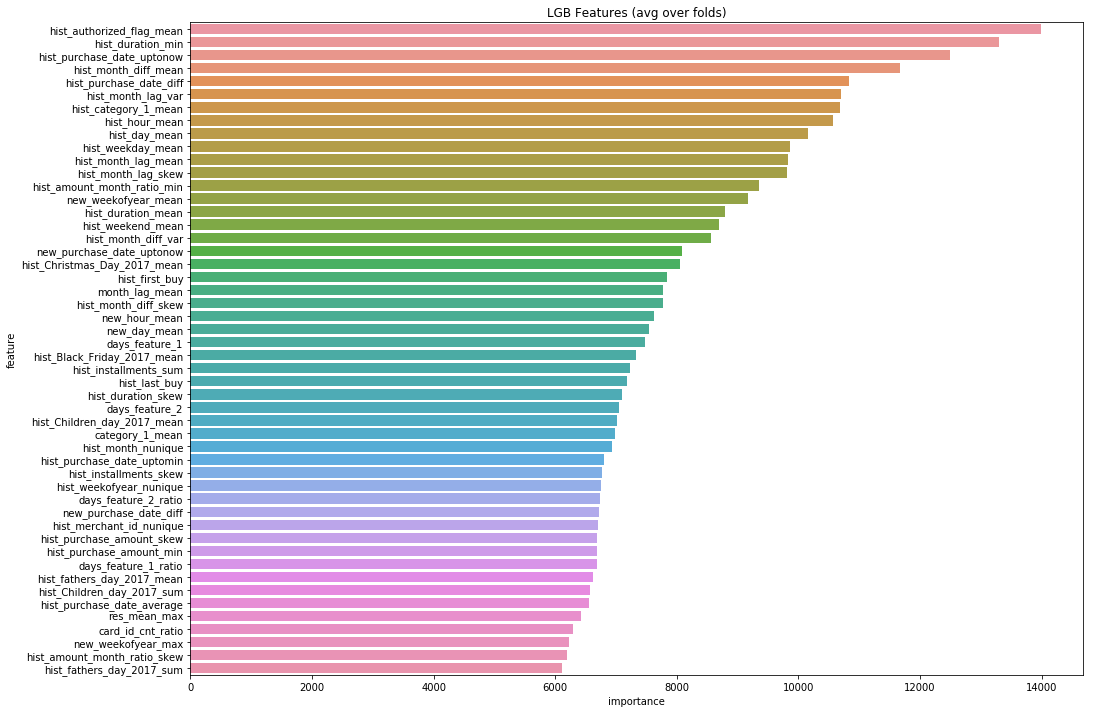

In [82]:
pred, model = model_train_easy(train_df, target, test_df)

In [ ]:
[2000]	training's rmse: 3.42912

In [289]:
train_df.drop(columns=['res_mean', 'res_sum',
       'res_mean_sum', 'res_sum_sum', 'res_mean_max_x', 'res_sum_max_x',
       'res_mean_min_x', 'res_sum_min_x', 'res_mean_max_y', 'res_sum_max_y',
       'res_mean_min_y', 'res_sum_min_y', 'res_mean_std', 'res_sum_std'], inplace=True)
test_df.drop(columns=['res_mean', 'res_sum',
       'res_mean_sum', 'res_sum_sum', 'res_mean_max_x', 'res_sum_max_x',
       'res_mean_min_x', 'res_sum_min_x', 'res_mean_max_y', 'res_sum_max_y',
       'res_mean_min_y', 'res_sum_min_y', 'res_mean_std', 'res_sum_std'], inplace=True)

In [196]:
hist

,authorized_flag,card_id,city_id,category_1,installments,category_3,merchant_category_id,merchant_id,month_lag,purchase_amount,purchase_date,category_2,state_id,subsector_id
0,Y,C_ID_4e6213e9bc,88,N,0,A,80,M_ID_e020e9b302,-8,29.00,2017-06-25 15:33:07,1.0,16,37
1,Y,C_ID_4e6213e9bc,88,N,0,A,367,M_ID_86ec983688,-7,9.17,2017-07-15 12:10:45,1.0,16,16
2,Y,C_ID_4e6213e9bc,88,N,0,A,80,M_ID_979ed661fc,-6,17.65,2017-08-09 22:04:29,1.0,16,37
3,Y,C_ID_4e6213e9bc,88,N,0,A,560,M_ID_e6d5ae8ea6,-5,7.69,2017-09-02 10:06:26,1.0,16,34
4,Y,C_ID_4e6213e9bc,88,N,0,A,80,M_ID_e020e9b302,-11,16.00,2017-03-10 01:14:19,1.0,16,37
5,Y,C_ID_4e6213e9bc,333,N,0,A,80,M_ID_50af771f8d,0,8.00,2018-02-24 08:45:05,1.0,9,37
6,Y,C_ID_4e6213e9bc,88,N,0,A,278,M_ID_5e8220e564,-11,20.00,2017-03-21 00:10:51,1.0,16,37
7,Y,C_ID_4e6213e9bc,3,N,0,A,80,M_ID_9d41786a50,-3,59.80,2017-11-18 20:05:55,1.0,16,37
8,Y,C_ID_4e6213e9bc,88,N,0,A,80,M_ID_979ed661fc,-8,5.95,2017-06-01 22:02:56,1.0,16,37
9,Y,C_ID_4e6213e9bc,88,N,0,A,80,M_ID_74ba14b5fc,-11,21.00,2017-03-16 15:41:22,1.0,16,37


In [204]:
merch = pd.read_csv('data/merchants.csv')

In [205]:
missing = hist[(hist['merchant_id']=='')\
                                  & (hist['month_lag']==0)].shape[0]
total = hist[(hist['month_lag']==0)].shape[0]
print(f"Missing: {missing}, total: {total}, missing ratio: {missing/total}")

Missing: 0, total: 3470946, missing ratio: 0.0


In [207]:
hist

,authorized_flag,card_id,city_id,category_1,installments,category_3,merchant_category_id,merchant_id,month_lag,purchase_amount,purchase_date,category_2,state_id,subsector_id
0,Y,C_ID_4e6213e9bc,88,N,0,A,80,M_ID_e020e9b302,-8,29.00,2017-06-25 15:33:07,1.0,16,37
1,Y,C_ID_4e6213e9bc,88,N,0,A,367,M_ID_86ec983688,-7,9.17,2017-07-15 12:10:45,1.0,16,16
2,Y,C_ID_4e6213e9bc,88,N,0,A,80,M_ID_979ed661fc,-6,17.65,2017-08-09 22:04:29,1.0,16,37
3,Y,C_ID_4e6213e9bc,88,N,0,A,560,M_ID_e6d5ae8ea6,-5,7.69,2017-09-02 10:06:26,1.0,16,34
4,Y,C_ID_4e6213e9bc,88,N,0,A,80,M_ID_e020e9b302,-11,16.00,2017-03-10 01:14:19,1.0,16,37
5,Y,C_ID_4e6213e9bc,333,N,0,A,80,M_ID_50af771f8d,0,8.00,2018-02-24 08:45:05,1.0,9,37
6,Y,C_ID_4e6213e9bc,88,N,0,A,278,M_ID_5e8220e564,-11,20.00,2017-03-21 00:10:51,1.0,16,37
7,Y,C_ID_4e6213e9bc,3,N,0,A,80,M_ID_9d41786a50,-3,59.80,2017-11-18 20:05:55,1.0,16,37
8,Y,C_ID_4e6213e9bc,88,N,0,A,80,M_ID_979ed661fc,-8,5.95,2017-06-01 22:02:56,1.0,16,37
9,Y,C_ID_4e6213e9bc,88,N,0,A,80,M_ID_74ba14b5fc,-11,21.00,2017-03-16 15:41:22,1.0,16,37


In [ ]:
merch